<h1><center> 
DeepLearning-Based RNA Toehold Switch Functionality Predictor Using One-Hot CNN
</center></h1>

<center>
Nicolaas M Angenent-Mari<sup>1,2*</sup> Alexander S. Garruss<sup>2,3*</sup>,, Luis R. Soenksen<sup>1,2*</sup>, Diogo M. Camacho<sup>2*</sup>, Katherine M Collins<sup>1*</sup>, George Church<sup>1,2,3,4</sup>, Timothy K. Lu<sup>1,4</sup>, and James J. Collins<sup>1,2,3,4</sup>
</center>


<center><font color=gray><font size="1.5">
<sup>1</sup>Massachusetts Institute of Technology, <sup>2</sup>Wyss Institute for Biologically Inspired Engineering, <sup>3</sup>Harvard John A. Paulson School of Engineering and Applied Sciences, and <sup>4</sup>Broad Institute of MIT and Harvard. *Contributed equally
</font></font></center>


##### Abstract:
<font color=black><font size="2">
A benchmark tool in the field of synthetic biology is the RNA “Toehold-Switch”, a riboregulator that responds to a programmable target to change its secondary structure through strand displacement with up-regulation of a desired protein. Recent advances have streamlined the synthesis of these modules; however, in vitro and in vivo functionality remain highly unpredictable due to complex interactions unanticipated by standard base-pairing models. We are developing and testing aa high-quality library of 244,000 toehold sequences to train and optimize a Convolutional Neural Net (CNN) deep-learning architecture based on RNA tensors to enable accurate biological predictions of novel toehold sensor functionality.
</font></font>

---------------------------------------------------------------------------------------------

References:

> Randal S. Olson, Ryan J. Urbanowicz, Peter C. Andrews, Nicole A. Lavender, La Creis Kidd, and Jason H. Moore (2016). Automating biomedical data science through tree-based pipeline optimization. Applications of Evolutionary Computation, pages 123-137.

>Randal S. Olson, Nathan Bartley, Ryan J. Urbanowicz, and Jason H. Moore (2016). Evaluation of a Tree-based Pipeline Optimization Tool for Automating Data Science. Proceedings of GECCO 2016, pages 485-492.

---------------------------------------------------------------------------------------------

#### DATA STRUCTURE (INPUT / OUTPU)
> Data is loaded from a Toehold Sensor Database (data/2019-03-30_toehold_dataset_proc_with_params.csv) which is comma delimited table  having the following columns of DNA encoded sub-sequences: organism, sequence_class, sequence_id, pre_seq	promoter, trigger, loop1, switch, loop2, stem1, atg, stem2m linkerm post_linker, output	
> #### Input tensor is defined as (DS=Data_Style):
> **DS_1)**  Toehold DNA Sequence <br>
> *NOTE:  Base toehold string sequence [0-144]
> *       GGG  - Trigger - Loop1 - Switch  - Loop2 - Stem1 -  AUG  -  Stem2  -  Linker - Post-linker
> *     [-3,-1]  [0,-29]  [30-49]  [50-79]  [80-90] [91,96] [97,99] [100,108] [109,134]  [135,144]
> *     
> *     For training we select our input sequence vector start with GGG and concatenate everything from "Loop1" to "post-linker"... which is seq_SwitchOFF_GFP  = ggg + seq[30:145].
> *     Also, pre_seq & promoter sub-sequences are NEVER used because they are not converted into mRNA (is in the plasmid but > *     it is never in the functional toehold module), so it won't contribute in secondary structure at all. For this example > *     in particular we use DS_1.*

> #### Output vector is defined as:
> **OUT_1)** ON, Off & ON-OFF State values derived from the experimental testing of toehold switch RNA sequence

#### PROBLEM DEFINITION
> To investigate if a deep learning network can be used to predict toehold switch ON/OFF functionality, because in that case it would suggest the network is learning secondary structure prediction that would be transferable to other RNA based problems.

--------------------------------------------------------------------------------------------------------------------------------------------------------

### STEP 0)   Loading, Import Modules & Core helper functions
#### This code requires the following pre-installs:
> ##### Biopython
> In anaconda env: `conda install -c anaconda biopython` or `pip install biopython`<br>
> Ref: https://github.com/biopython/biopython
> ##### ViennaRNA
> In anaconda env: `conda install -c bioconda viennarna`<br>
> Ref: https://github.com/ViennaRNA/ViennaRNA
> ##### Pysster (Python 3.5+)
> In anaconda env: `pip3 install pysster`<br>
> Ref: https://github.com/budach/pysste

In [1]:
## Import Libraries
# General system libraries
import os
import gc
import cv2
import math
import h5py
import locale
import inspect
import argparse
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from subprocess import call

# Math & Visualization Libs
import math
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

# Multiprocessing
import multiprocessing

# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# > Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# > ViennaRNA Lib
import RNA

#RNAssp
import src.RNAssp.rna as rnassp

# Import Tensorflow
import tensorflow as tf

# Import Json
import json
import codecs

# Import Keras
from keras import optimizers
from keras import applications
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.models import model_from_json, load_model
from keras.layers import Activation, Conv1D, Conv2D, Reshape, BatchNormalization, Dropout, Flatten, Dense, merge, Input, Lambda, InputLayer, Convolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

#Import Keras-Vis for Saliency
from vis.utils import utils
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation, visualize_saliency, visualize_cam, overlay
    ## NOTE: Install in conda enviroment: pip install git+https://github.com/raghakot/keras-vis.git -U

# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc
    ## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
        # watch -n0.5 nvidia-smi
    ## NOTE: If not present, activate GPU persistence mode in terminal with
        # sudo nvidia-smi -pm 1
    ## If you do not see any GPU usage try uncommenting the following line:
        # sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

# Progress Bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")

#Visualization mode
#%matplotlib ipympl

Using TensorFlow backend.


In [2]:
## Define helper function to copy full directory for backups
def copy_full_dir(source, target):
    call(['cp', '-a', source, target]) # Unix
    
#Get number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
ngpus = len(get_available_gpus())
print('Available GPUs: '+ str(ngpus))

Available GPUs: 4


-----------------------------------------------------------------------------------------------------------------------------

### 1) Import Dataset & Define Raw Input(s)/Output(s)
> Full data CSV read, includes all necessary information to train and test

In [3]:
# Create Data folder if not existent
data_folder = "data/"
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
    
## Define general path to store all generated models
core_models_path = 'models/'
# Create Data folder if not existent
if not os.path.isdir(core_models_path):
    os.makedirs(core_models_path)

# Define path to load desired Toehold dataset file (.csv)
data_filename = "2019-07-08_toehold_dataset_proc_with_params_QC1_1.csv"
data_path = data_folder + data_filename
data = pd.read_csv(data_path)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed) # Seed can be any number

In [4]:
### Datata Sequence ID selection
id_data = data['sequence_id']

### Toehold Switch dataset input/output columns for selection
input_cols = 'seq_SwitchON_GFP'
output_cols = ['ON', 'OFF', 'ON_OFF']
qc_levels = [1.1]
doTrain = True
loss_init = 'mae' #'logcosh', #'mse', 'mae', 'r2'
n_foldCV = 10
verbose_init = True
evaluate  = True
display_init = True

### Define data scaler (if any)
scaler_init = True
scaler = QuantileTransformer(output_distribution='uniform')

### DEFINE MODEL NAME (e.g. MLP, CNN, LSTM, etc.)
model_name = 'CNN_1D'

#Show sample of dataframe structure
data.head()

off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   
3  AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...   
4  AACCAAACACACAAACGCACAAAAAAAATGGAAAACAGTTACTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...        smallpox   
4  ACATATTAGTAACTGTTTTCCATTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
3  smallpox_tile_6492  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
4  smallpox_tile_2624  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   

                          trigger                 loop1  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
2  CTAAATTAACAATAGTAGTAATTTTTTTTT  AACCAAACACACAAACGCAC   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTT  AACCAAACACACAAACGCAC   
4  ACATATTAGTAACTGTTTTCCATTTTTTTT  AACCAAACACACAAACGCAC   

                           switch        loop2    ...     Cbn1_off  Cbn2_off  \
0  AAAAAAAAAAAAAAAAAATGGAAAACAGTT  AACAGAGGAGA    ...     0.000000  1.000000   
1  AAAAAAAAAAAAATGGAAAACAGTTACTAA  AACAGAGGAGA    ...          NaN       NaN   
2  AAAAAAAAATTACTACTATTGTTAATTTAG  AACAGAGGAGA    ...     1.000000  0.000000   
3  AAAAAAAATAACGTAGGACTACTACTTGGA  AACAGAGGAGA    ...     0.883458  0.116542   
4  AAAAAAAATGGAAAACAGTTACTAATATGT  AACAGAGGAGA    ...     0.815066  0.000000   

   Cbn3_off Cbn4_off        ON       OFF    ON_OFF QC_ON QC_OFF QC_ON_OFF  
0  0.000000      0.0       NaN  0.333333       NaN   NaN    NaN       NaN  
1       NaN      NaN       NaN       NaN       NaN   NaN    NaN       NaN  
2  0.000000      0.0  0.068295  0.000000  0.068295   2.0    1.1       1.1  
3  0.000000      0.0  0.000000  0.038847 -0.038847   1.1    2.0       1.1  
4  0.184934      0.0  0.080666  0.123289 -0.042624   2.0    3.0       2.0  

[5 rows x 99 columns]

-----------------------------------------------------------------------------------------------------------------------------

### 2) Definition of Pre-Processing Input(s)/Output(s) functions

> Define helper functions for one-hot encoding and Generation of Connectivity Map Tensors

> Definition of full input and output vectors for the network

In [5]:
# Helper function to pass string DNA/RNA sequence to one-hot
def dna2onehot(seq):
    #get sequence into an array
    seq_array = np.array(list(seq))
    
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
                                   
    #reshape because that's what OneHotEncoder likes
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    
    return onehot_encoded_seq

In [6]:
# INPUT / OUTPUT DEFINITION, PROCESSING & LOADING
def pre_process_data (data, input_cols, output_cols, export_path, qc_level_threshold=1, scaler_init=False, display=True):
    ## OUTPUT / INPUT DEFINITION, PROCESSING & LOADING
    
    #Init process bar
    tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences

    # Define path to store input / output arrays
    tmp_data_path = 'data/tmp/'
    # Create Data folder if not existent
    if not os.path.isdir(tmp_data_path):
        os.makedirs(tmp_data_path)

    # GENERATE & SAVE FULL INPUT VECTORS (only if not exists because it is a large file)
    tmp_data_input_path = (tmp_data_path + 'data_input_file_1d_' + input_cols + '.h5')
    if not os.path.exists(tmp_data_input_path):
        # Data Input selection & Generation if absent (or delete it to re-calculate)
        n_batch_samples = 10000 #We constrain process batches to this number to allow for progressive saving of large files
        n_batches = math.ceil(len(data[input_cols])/n_batch_samples)
        
        if n_batches>1:
            print('Processing in batches...')
            
        # Process and Append Save:
        with h5py.File(tmp_data_input_path, 'a') as hf:
            is_first=True
            for data_tmp in np.split(data[input_cols], n_batches):
                df_data_input_tmp = data_tmp.progress_apply(dna2onehot)
                data_input_tmp = np.array(list(df_data_input_tmp.values))
                if is_first==True:
                    dset = hf.create_dataset("input",  data=data_input_tmp, maxshape=(None, data_input_tmp.shape[1], data_input_tmp.shape[2]), chunks=(n_batches,data_input_tmp.shape[1], data_input_tmp.shape[2])) 
                    is_first=False
                else:
                    dset.resize((dset.shape[0]+data_input_tmp.shape[0],data_input_tmp.shape[1],data_input_tmp.shape[2]))  
                    dset[-data_input_tmp.shape[0]:,:,:] = data_input_tmp
    
    # GENERATE & SAVE FULL OUTPUT VECTORS
    output_ids = "_".join(str(x) for x in output_cols)
    tmp_data_output_path = (tmp_data_path + 'data_output_file_QC_' + str(qc_level_threshold).replace('.','-') + '_' + output_ids + '.h5')
    
    # Data Output selection (QC filtered, OutColumns Only & Drop NaNs)
    df_data_output = data[data.QC_ON_OFF >= qc_level_threshold]
    df_data_output= df_data_output[output_cols]
    df_data_output = df_data_output.dropna(subset=output_cols)
    data_output = df_data_output.as_matrix().astype('float32')
    #Save:
    with h5py.File(tmp_data_output_path, 'w') as hf:
        hf.create_dataset("output",  data=data_output)

    # LOAD FULL INPUT ARRAY in memory and QC filter
    with h5py.File(tmp_data_input_path, 'r') as hf:
        data_input = hf['input'][:]
        data_input = data_input[df_data_output.index.values][:][:]
    
    # LOAD FULL OUTPUT ARRAY in memory and QC filter
    with h5py.File(tmp_data_output_path, 'r') as hf:
        data_output = hf['output'][:]
        data_output_orig = data_output
        #Pre-process data (scaler)
        if scaler_init==True:
            data_output = scaler.fit_transform(data_output)
    
    # LOAD FULL LIST OF SEQUENCES after filtering
    data_seqs = data[input_cols][df_data_output.index.values]
    
    
    # Display processed data if desired
    if display==True:
        ### Show example of processed dataset
        ## Display number of retrieved sequences
        print("Number of sequences retrieved: "+str(len(data_input)))
        print()

        #Select ID to show
        toehold_id = 0

        ## Plot Example input toehold matrix 
        print('EXAMPLE OF INPUT ONE-HOT TOEHOLD')
        onehot_encoded_seq = dna2onehot(data_seqs.iloc[toehold_id])
        print(onehot_encoded_seq.transpose())
        print()
        
        # Display input size
        print("Input Size: " + str(onehot_encoded_seq.shape))
        print()

        # Display example of Output vector
        print('EXAMPLE OF OUTPUT VECTOR')
        print(' ' + str(data_output[toehold_id]))
        print()

        # Display Output Values
        for index,item in enumerate(output_cols):
            # Display Output Values
            plt.figure()
            print('Distribution of ' + str(item) + ' Values')
            sns.distplot(data_output[:,index], kde=True, rug=False)
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_dist.png", bbox_inches='tight', dpi=300)
        
        if scaler_init==True:           
            ## COMPUTE EFFECT OF SCALER
            # Difference between the transformed toehold output values and original toehold output values, 
            # then compute the absolute percentage difference for diplay
            test_metrics = np.zeros((data_output_orig.shape[1],3))
            diff = data_output_orig - data_output
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            
            # Plot: Scaled Output values vs. Original values and get R2 value
            for index,item in enumerate(output_cols):
                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(data_output_orig[:,index], data_output[:,index])
                
                # Display Output Values
                x=np.squeeze(data_output_orig[:,index])
                y=np.squeeze(data_output[:,index])
                
                # Display Output Values
                print('')
                print("" + item + " Mean_absolute_error (TRANSFORMATION): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('TRANSFORMED Values vs. ORIGINAL values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$ORIGINAL$", "$TRANSFORMED$");

                # save the figure
                g.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_data_scaling_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(export_path + '/scaling_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(export_path + '/scaling_data',data_output_orig,data_output) 
            
    return data_input, data_output

-----------------------------------------------------------------------------------------------------------------------------

### 3) Definition of Model Architecture Function
> Funtion to create keras model architecture
> Helper functions to save and evaluate models

In [7]:
### Function to create Keras CNN for regression prediction
def create_cnn(width, height, filters=[32, 64, 128], regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (width, height) #DNA/RNA input sequence (one hot encoded)
    chanDim = -1
    dropout_init = 0.2
    
    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv1D(f, 3, padding="same", kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.0005))(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling1D(pool_size=2)(x)
    
    # flatten the volume, then FC => RELU => BN => DROPOUT (optional)
    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    
    # apply another FC layer, this one to potentially match the number of nodes 
    # in a parallel network (i.e MLP with rational parameters)
    x = Dense(16, activation="relu")(x)
    
    # check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)

    # Construct the Model
    model = Model(inputs, x) 
    
    # Return the model
    return model

In [8]:
# Helper functions to save/load model and training history
def saveHist(path,history):
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
        
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

def save_model(model, identifier):
    ## MODEL SAVING ON WORKING FOLDER
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights_'+str(identifier)+'.h5')
    with open(os.path.abspath(model_path)+'/model_architecture_'+str(identifier)+'.json', 'w') as f:
        f.write(model.to_json())

    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model_'+str(identifier)+'.h5')

In [9]:
#Definition of R2 metric for testing
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

#Definition of Custom metric as loss related to Coefficient of Determination (R2) 
#  CoD = 1 - MSE / (variance of inputs), and since this is going to be a loss we want 
#  improvement to point towards zero, so we choose mse/variance of inputs
def custom_r2_loss(y_true, y_pred): 
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (SS_res/(SS_tot + K.epsilon()))

#Definition of Custom metric as loss related to Weigted Mean Absolute error
#  Improvement points towards zero, but penalizes loss for small values and improves it for larger values
def custom_wmae_loss(y_true, y_pred): 
    from keras import backend as K
    weightedMAE = K.abs((y_true-y_pred)*y_true) #Increase loss for large ON or OFF values -- Skews focus of distribution right
    return weightedMAE

### 4) Definition of BASE Model Generator (with Training using Manual Verification Dataset & Evaluation)
> For use with a priori training (suggested: 75%) & testing (suggested: 25%) split, with internal training validation from the training set (10% or the 75%)
> For evaluation on unseen testing data (suggested: 25%) 
> This generator function generates and saves model in target path

In [10]:
### Define our final model architecture (layers & optimizor) and then compile it
def generate_model(model_path, trainX, testX, trainY, testY, verbose_init, evaluate=True):
    
    ## DEEP-LEARNING TRAINING PARAMETERS(e.g. verbose, patients, epoch size, batch size) to constrain process
    verbose_init = verbose_init #Zero is no keras verbose
    patience_init = 20 # Number of epochs to wait for no model improvement before early stopping a training
    epochs_init = 300 # Max number of epochs to perform (to cap training time)
    batch_size_init = 64*(1+ngpus) # number of samples that will be propagated through the network at every epoch dependent on the number of GPUs
    validation_spit_init = 0.1 # Percentage of testing data to use in internal validation during training
    
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_path):
        os.makedirs(model_path)
        
    ## Callbacks for training:
    #  Save the model weights to the same file, if and only if the validation accuracy improves.
    checkpoint_file_name = "model_checkpoint_weights.h5"
    model_checkpoint_path = os.path.join(os.path.abspath(model_path), checkpoint_file_name)
    
    if verbose_init==True:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = verbose_init, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = verbose_init),
                          TQDMNotebookCallback()] # Adds Keras integration with TQDM progress bars.
    else:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = False, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = False)]    
    
    ## Create Model (Change for MLP, CNN, ETC)
    # -------------------------------------------------------------------------------------------------------------------------------------
    # Define CNN model input shape
    (width, height) = np.shape(trainX[0])
    
    # Define core model on CPU
    with tf.device("/cpu:0"):  
        model = create_cnn(width, height, regress=True)
        
    ## Initialize the optimizer and Compile model:
    #   Custom metric is used (see above), if we use "Mean absolute percentage error" that
    #   implies that we seek to minimize the absolute percentage difference between 
    #   our *predictions* and *actual* output values. We also calculate other 
    #   valuable metrics for regression evaluation 
    opt = Adam(lr=0.001, epsilon=None, decay=1e-3/200, amsgrad=False) # epsilon=1e-1 for POISSON loss
    
    if loss_init=="r2":
        model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
    elif loss_init =="wmae":
        model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
    else:
        model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
    # -------------------------------------------------------------------------------------------------------------------------------------  
        
    ## Parallel computing (if multiple GPUs are available)
    # Define model for training (CPU, Single GPU or Multi-GPU depending on availability of resources)
    if ngpus<=1:
        print("[INFO] training with Single GPU or CPU...")
        model_history = model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)

    else:
        print("[INFO] training with {} GPUs...".format(ngpus))
        # make the model parallel
        parallel_model = multi_gpu_model(model, gpus=ngpus)
        
        if loss_init=="r2":
            parallel_model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
        elif loss_init =="wmae":
            parallel_model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
        else:
            parallel_model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
        model_history = parallel_model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)    
                    

    ## MODEL SAVING
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights.h5')
    with open(os.path.abspath(model_path)+'/model_architecture.json', 'w') as f:
        f.write(model.to_json())
    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model.h5')
    # Save model graph to file
    model_graph_path = model_path + '/model_graph.png'
    plot_model(model, to_file=model_graph_path, show_shapes=True, show_layer_names=True)
    # Save training history
    saveHist(model_path + '/model_history', model_history)
        
    ## MODEL LOADING (to ensure it works)
    # Option 1: Load latest model via Weights + Architecture
    #with open(os.path.abspath(model_path)+'/model_architecture.json', 'r') as f:
    #    model = model_from_json(f.read())
    #    model.load_weights(os.path.abspath(model_path)+'/model_weights.h5')
    # Option 2: Load latest model via entire model at once
    if loss_init=="r2":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_r2_loss': custom_r2_loss})
    elif loss_init =="wmae":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_wmae_loss': custom_wmae_loss})
    else:
        model = load_model(os.path.abspath(model_path)+'/model.h5')
    
    # Load model training history
    model_history = loadHist(model_path + '/model_history')
    
    # Init prediction output matrix
    testX_Preds = np.zeros_like(testY) #Empty matrix for full prediction evaluation
    # Init performance metrics matrix
    test_metrics = np.zeros((trainY.shape[1],3)) #Empty matrix for model performance metrics
    
    # GENERATE PREDICTIONS
    if testX.size > 0:
        ## Make predictions on testing data:
        print("Predicting functionality of Test Toeholds ...")
        print("")
        #Predictions in scaled space
        testX_Preds = model.predict(testX)
        
        if scaler_init == True:
            testY = scaler.inverse_transform(testY)
            testX_Preds = scaler.inverse_transform(testX_Preds)
        
        ## EVALUATE PERFORMANCE OF MODEL
        if evaluate==True:
            ## Plot training metrics per fold:
            plt.figure ()
            ax1 = plt.subplot(221)
            ax2 = plt.subplot(222)
            ax3 = plt.subplot(223)
            ax4 = plt.subplot(224)
            # Plot MSE metric
            ax1.set_title("Mean squared error")
            ax1.plot(model_history['mean_squared_error'])
            # Plot MAE metric
            ax2.set_title("Mean absolute error")
            ax2.plot(model_history['mean_absolute_error'])
            # Plot MAPE metric
            ax3.set_title("Mean absolute percentage error")
            ax3.plot(model_history['mean_absolute_percentage_error'])
            # Plot CP metric
            ax4.set_title("Cosine Proximity")
            ax4.plot(model_history['cosine_proximity'])
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(model_path + "/model_training_metrics.png", bbox_inches='tight', dpi=300)

            ## Plot compiled training metrics per fold:
            plt.figure()
            plt.style.use("default")
            N = np.arange(0, len(model_history["loss"]))
            # Plot used Loss metric
            plt.plot(N, model_history["loss"], label="train_loss")
            plt.plot(N, model_history["val_loss"], label="test_loss")
            # Plot used Accuracy metric (applicable only if categorical model)
            plt.plot(N, model_history["acc"], label="train_acc")
            plt.plot(N, model_history["val_acc"], label="test_acc")
            # Plot MSE metric
            plt.plot(N, model_history["mean_squared_error"], label="train_mse")
            plt.plot(N, model_history["val_mean_squared_error"], label="test_mse")
            # Plot MAE metric
            plt.plot(N, model_history["mean_absolute_error"], label="train_mae")
            plt.plot(N, model_history["val_mean_absolute_error"], label="test_mae")
            # Plot MAPE metric
            plt.plot(N, model_history["mean_absolute_percentage_error"], label="train_mape")
            plt.plot(N, model_history["val_mean_absolute_percentage_error"], label="test_mape")
            # Plot CP metric
            plt.plot(N, model_history["cosine_proximity"], label="train_cp")
            plt.plot(N, model_history["val_cosine_proximity"], label="test_cp")
            plt.title("CNN Toehold Complementary Rep Data")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Place a legend to the right of this smaller subplot.
            # Save figure
            plt.savefig(model_path + "/model_training_compilation.png", bbox_inches='tight', dpi=300)
            
            
            ## COMPUTE PERFORMANCE METRICS
            # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
            # then compute the absolute percentage difference for diplay
            diff = testX_Preds - testY
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            # Plot: Predicted values vs. Experimental values and get R2 value
            for index,item in enumerate(output_cols):

                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(testX_Preds[:,index], testY[:,index])
                
                # Display Output Values
                x=np.squeeze(testX_Preds[:,index])
                y=np.squeeze(testY[:,index])
                
                # Display Output Values
                print("" + item + " Mean_absolute_error (TEST): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");

                # save the figure
                g.savefig(model_path + "/model_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(model_path + '/test_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(model_path + '/test_data',testX_Preds, testY) 
                
    return model, model_history, testX_Preds, test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 5)  Definition of k-Fold Cross Validated Model Generator (with Ensemble Training, Evaluation & Full Deployment)

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of the performance of a model on unseen data. 

> It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 

> The performance measure accross all models in the unseen data for each fold

> The performance is printed for each model and it is stored

> A final deployment model trained in all data (no testing) is provided for evaluation in future data

In [11]:
### Define our crossvalidation model generator (layers, optimizor, compilation, training, reporting, etc)
def generate_crossval_model(model_cv_path, X, Y, n_foldCV, verbose_init=True, evaluate=True):
    
    ## CROSSVALIDATION TRAINING
    # Define CV parameters
    n_foldCV = n_foldCV #Number of Crossvalidation bins
    cv_folds = list(StratifiedKFold(n_splits=n_foldCV, shuffle=True, random_state=seed).split(X,Y.argmax(1))) # Non repeating CV bins
    cv_preds = np.zeros_like(Y) #Empty matrix for full prediction evaluation
    cv_test_metrics = np.zeros((n_foldCV, Y.shape[1], 3))
    deploy_test_metrics = np.zeros((Y.shape[1],3))
    
    # Perform n-fold crossvalidated training and evaluation
    for j, (train_idx, test_idx) in enumerate(cv_folds):
        print('\nFold ',j)
        
        # Define folder for CV fold model
        model_cv_fold_path = model_cv_path + '/Fold' + str(j) 

        ## CrossValidation Strategy: 
        # We use all data for n-crossvalidation this will give us average metrics of performance in future data
        # for this all data will be devided into n bins. In every sequential fold we will use n-1 bins for training 
        # and the remaining bin for testing this split is done in such a way that all data is used for training and
        # testing at some point (sweet!). Testing points will be aggregated tenerate an average metric of performance
        # and all the datapoints will be put into a master agreement plot for visualization. 
        # A working model will be made using 75% of the data for training and 25% for further testing.
        # A deploy model will be also trained using all available data without testing
        trainX_cv = X[train_idx]
        trainY_cv = Y[train_idx]
        testX_cv = X[test_idx]
        testY_cv = Y[test_idx]
        # NOTE: Validation set is taken internally from the training set (10% of each fold), this is applied in the the model.fit function
        
        # Create & Train model each fold according to generator function
        model, model_history, testX_Preds, test_metrics = generate_model(model_cv_fold_path, trainX_cv, testX_cv, trainY_cv, testY_cv, verbose_init=verbose_init, evaluate=evaluate)
        
        # Record predicted values of each CV fold training to generate an ensemble reporting
        print("Predicting functionality of CV-Fold Test Toeholds & Model performance metrics ...")
        cv_preds[test_idx,:] = testX_Preds
        cv_test_metrics[j,:,:] = test_metrics
        
        ## MODEL MEMORY RELEASE
        del model_history
        del model
        for i in range(ngpus+1): gc.collect()
        
        ## Free-up keras memmory to prevent leaks
        K.clear_session()
    
    #Transform back data
    if scaler_init == True:
        Y = scaler.inverse_transform(Y)
    
    # SAVE METRICS (.npy file)
    np.save(model_cv_path + '/cv_test_metrics',cv_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_cv_path + '/cv_test_data',cv_preds, Y)
            
    
    ## DEFINE FOLDER FOR DEPLOY MODEL
    model_deploy_path = model_cv_path + '/deploy'
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_deploy_path):
        os.makedirs(model_deploy_path)
    print('')
    print('Generating deployment model...')
    
    # COMPUTE PERFORMANCE METRICS FOR DEPLOY MODEL
    # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
    # then compute the absolute percentage difference for diplay

    diff = cv_preds - Y
    abstDiff = np.abs(diff)
    # Compute the mean and standard deviation of the absolute difference:
    apd_mean = np.mean(abstDiff, axis=0)
    apd_std = np.std(abstDiff, axis=0)
    apd_r2 = np.zeros_like(apd_mean)

    ## EVALUATE ENSEMBLE CROSSVALIDATION PERFORMANCE OF MODEL
    if evaluate==True:
        for index,item in enumerate(output_cols): 
            # R2 (Coefficient of Determination)
            apd_r2[index] = r2(cv_preds[:,index], Y[:,index])
            # Display Output Values
            x_tot=np.squeeze(cv_preds[:,index])
            y_tot=np.squeeze(Y[:,index])
            print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
            print('Pearson Correlation: '+ str(stats.pearsonr(x_tot, y_tot)[0]))
            print('Spearman Correlation: '+ str(stats.spearmanr(x_tot, y_tot)[0]))
            print('R2: '+ str(apd_r2[index]))
            print('')
            
            if scaler_init == True:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
            else:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", stat_func=r2)
            g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
            g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
            g.ax_joint.collections[0].set_alpha(0)
            g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");
            
            # save the figure
            g.savefig(model_deploy_path + "/model_ensemble_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
    
            # Store model performance metrics for return   
            deploy_test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
            
    # SAVE METRICS (.npy file)
    np.save(model_deploy_path + '/deploy_test_metrics', deploy_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_deploy_path + '/deploy_test_data',cv_preds, Y)
    
    ## DEPLOYMENT MODEL TRAINING (with full dataset)
    # Partition the data into training (90%), validation (10%), testing (0%) splits 
    (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.0, random_state=seed)
    
    # Create model function according to generator function
    model, model_history, _ , _ = generate_model(model_deploy_path, trainX, testX, trainY, testY, verbose_init=True, evaluate=True)
                                                                                                                                               
    ## Return                                     
    return model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 6) Loop through all model(s) generation depending on: Model folder, Chosen input(s)/output(s), QC levels & k-fold bins

> Define helper function for master loop

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of performance

In [12]:
#Definer function for full model analysis and reporting
def execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate):
      
    #Iterate through all desired Data QC levels
    for j, qc_level in enumerate(qc_levels): 
        
        ### 1) Create all folders per iteration
        ## Define general path to store all generated models
        model_path = core_models_path + model_name.lower()+ '/' + model_name.upper() +'-' + str('-'.join(output_cols) + '-QC' + str(qc_level).replace('.','-') + '/')
        print ("Iteration " + str(j) + ") Building analysis in: " + model_path) 
        # Create Data folder if not existent
        if not os.path.isdir(model_path):
            os.makedirs(model_path)
        
        ## SAVE INIT PARAMETER SAVING ON WORKING FOLDER
        init_param_path = model_path + "init_parameters.txt"
        with open(init_param_path, "w+") as variable_file:
            variable_file.write("data_folder = " + str(data_folder)+ '\n' +\
                                "core_models_path = " + str(core_models_path)+ '\n' +\
                                "data_filename = " + str(data_filename)+ '\n' +\
                                "seed = " + str(seed)+ '\n' +\
                                "model_name = " + str(model_name)+ '\n' +\
                                "input_cols = " + str(input_cols)+ '\n' +\
                                "output_cols = " + str(output_cols)+ '\n' +\
                                "qc_level = " + str(qc_level)+ '\n' +\
                                "n_foldCV = " + str(n_foldCV)+ '\n' +\
                                "scaler = " + str(scaler)+ '\n' +\
                                "loss_init = " + str(loss_init)+ '\n' +\
                                "verbose_init = " + str(verbose_init)+ '\n' +\
                                "evaluate  =  " + str(evaluate)+ '\n' +\
                                "display_init =  " + str(display_init)+ '\n')
        
        ## Define path to store base model
        model_base_path = model_path + 'base'
        # Create Data folder if not existent
        if not os.path.isdir(model_base_path):
            os.makedirs(model_base_path)

        ## Define path to store crossvalidation models
        model_cv_path = model_path + 'crossval'
        # Create Data folder if not existent
        if not os.path.isdir(model_cv_path):
            os.makedirs(model_cv_path)

        ## Define path to store all generated model inputs
        model_input_path = model_path + 'input'
        # Create Data folder if not existent
        if not os.path.isdir(model_input_path):
            os.makedirs(model_input_path)
            
        ## Define path to store all generated model outputs
        model_output_path = model_path + 'output'
        # Create Data folder if not existent
        if not os.path.isdir(model_output_path):
            os.makedirs(model_output_path)
    
            
        ## LOAD PREPROCESSED INPUT / OUTPUT
        data_input, data_output = pre_process_data (data, input_cols, output_cols, model_input_path, qc_level_threshold=qc_level, scaler_init=scaler_init, display=display_init)
            
        ### 3) Model Training using Manual Verification Dataset & Evaluation
        # Training with a priori training (75%) & testing (25%) split, with internal training validation from the training set (10% or the 75%)
        # This also does valuation on unseen testing data (25%), and saves base model

        # Create manual model function according to generator function, train it and display architecture
        if doTrain==True:
            # Partition the data into training (75%) and testing (25%) splits
            (trainX, testX, trainY, testY) = train_test_split(data_input, data_output, test_size=0.25, random_state=seed)
            # Generate, Train, Evaluate, Save and Display Model
            model, model_history, testX_Preds, test_metrics = generate_model(model_base_path, trainX, testX, trainY, testY, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
        
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
        
            ## Free-up keras memmory to prevent leaks
            K.clear_session()

        ### 4) Model Training using k-Fold Cross Validation, Ensemble Evaluation & Full Deployment
        # The gold standard for machine learning model evaluation is k-fold cross validation
        # It provides a robust estimate of the performance of a model on unseen data. 
        # It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 
        # The performance measure accross all models in the unseen data for each fold
        # The performance is printed for each model and it is stored
        # A final deployment model trained in all data (no testing) is provided for evaluation in future data

        # Create crossvalidated model function according to generator function, train it and display architecture
        # Generate, Train, Evaluate, Save and Display Model
        if n_foldCV>0:
            model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics = generate_crossval_model(model_cv_path, data_input, data_output, n_foldCV=n_foldCV, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
            
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
                
            ## Free-up keras memmory to prevent leaks
            K.clear_session()
    
    ## MODEL SAVING ON DATED BACKUP FOLDER
    # Save the entire current model folder to a backup folder
    source_model_path = core_models_path + model_name + '/'
    backup_model_path = 'backup/' + source_model_path +  datetime.now().strftime('%Y%m%d') + '_' + datetime.now().strftime('%H%M')
    ## Create folder to store model (if not existent)
    if not os.path.isdir(backup_model_path):
        os.makedirs(backup_model_path)
    # Copy all contents to dated backup
    copy_full_dir(source_model_path, backup_model_path)

Iteration 0) Building analysis in: models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/
Number of sequences retrieved: 91534

EXAMPLE OF INPUT ONE-HOT TOEHOLD
[[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 

Epoch 1/300


61785/61785 [==============================] - 28s 449us/step - loss: 0.9926 - mean_squared_error: 0.1959 - mean_absolute_error: 0.3226 - mean_absolute_percentage_error: 12268373.8232 - cosine_proximity: -0.7090 - acc: 0.3734 - val_loss: 0.6293 - val_mean_squared_error: 0.1200 - val_mean_absolute_error: 0.2742 - val_mean_absolute_percentage_error: 21721071.6213 - val_cosine_proximity: -0.9193 - val_acc: 0.4807

Epoch 00001: val_loss improved from inf to 0.62931, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 2/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.4147 - mean_squared_error: 0.0627 - mean_absolute_error: 0.2004 - mean_absolute_percentage_error: 12791819.9050 - cosine_proximity: -0.9160 - acc: 0.3986 - val_loss: 31.2574 - val_mean_squared_error: 1260.8698 - val_mean_absolute_error: 31.1392 - val_mean_absolute_percentage_error: 554249975.9359 - val_cosine_proximity: 0.6018 - val_acc: 0.3953

Epoch 00002: val_loss did not improve from 0.62931
Epoch 3/300


61785/61785 [==============================] - 4s 72us/step - loss: 0.2887 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1853 - mean_absolute_percentage_error: 11990813.5615 - cosine_proximity: -0.9214 - acc: 0.4679 - val_loss: 0.7215 - val_mean_squared_error: 2.4327 - val_mean_absolute_error: 0.6272 - val_mean_absolute_percentage_error: 17885984.4894 - val_cosine_proximity: -0.6755 - val_acc: 0.4795

Epoch 00003: val_loss did not improve from 0.62931
Epoch 4/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.2527 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1805 - mean_absolute_percentage_error: 11927463.6511 - cosine_proximity: -0.9235 - acc: 0.4834 - val_loss: 0.2620 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1741 - val_mean_absolute_percentage_error: 10309952.7087 - val_cosine_proximity: -0.9286 - val_acc: 0.5068

Epoch 00004: val_loss improved from 0.62931 to 0.26202, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 5/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.2475 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1771 - mean_absolute_percentage_error: 11821780.2846 - cosine_proximity: -0.9251 - acc: 0.5056 - val_loss: 0.2574 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1762 - val_mean_absolute_percentage_error: 10226841.6788 - val_cosine_proximity: -0.9250 - val_acc: 0.4983

Epoch 00005: val_loss improved from 0.26202 to 0.25740, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 6/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.2258 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1740 - mean_absolute_percentage_error: 11783847.8828 - cosine_proximity: -0.9262 - acc: 0.5130 - val_loss: 0.9119 - val_mean_squared_error: 7.6710 - val_mean_absolute_error: 0.8787 - val_mean_absolute_percentage_error: 24330181.8237 - val_cosine_proximity: -0.7046 - val_acc: 0.4862

Epoch 00006: val_loss did not improve from 0.25740
Epoch 7/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.2003 - mean_squared_error: 0.0490 - mean_absolute_error: 0.1718 - mean_absolute_percentage_error: 11629396.1874 - cosine_proximity: -0.9274 - acc: 0.5256 - val_loss: 0.2033 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1788 - val_mean_absolute_percentage_error: 11287748.9811 - val_cosine_proximity: -0.9216 - val_acc: 0.5023

Epoch 00007: val_loss improved from 0.25740 to 0.20328, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 8/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1958 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 11663860.2347 - cosine_proximity: -0.9275 - acc: 0.5295 - val_loss: 0.2038 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1827 - val_mean_absolute_percentage_error: 8639312.8689 - val_cosine_proximity: -0.9193 - val_acc: 0.5020

Epoch 00008: val_loss did not improve from 0.20328
Epoch 9/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1905 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1696 - mean_absolute_percentage_error: 11620333.1567 - cosine_proximity: -0.9282 - acc: 0.5360 - val_loss: 0.2691 - val_mean_squared_error: 0.0946 - val_mean_absolute_error: 0.2443 - val_mean_absolute_percentage_error: 18666540.9090 - val_cosine_proximity: -0.9255 - val_acc: 0.3809

Epoch 00009: val_loss did not improve from 0.20328
Epoch 10/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.2074 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1708 - mean_absolute_percentage_error: 11633073.3844 - cosine_proximity: -0.9279 - acc: 0.5345 - val_loss: 0.2080 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.1872 - val_mean_absolute_percentage_error: 8132422.4741 - val_cosine_proximity: -0.9121 - val_acc: 0.4822

Epoch 00010: val_loss did not improve from 0.20328
Epoch 11/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1862 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 11504662.9964 - cosine_proximity: -0.9285 - acc: 0.5394 - val_loss: 0.1832 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1676 - val_mean_absolute_percentage_error: 10414361.4319 - val_cosine_proximity: -0.9285 - val_acc: 0.5425

Epoch 00011: val_loss improved from 0.20328 to 0.18322, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 12/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1856 - mean_squared_error: 0.0475 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 11530034.5802 - cosine_proximity: -0.9283 - acc: 0.5391 - val_loss: 0.1841 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1638 - val_mean_absolute_percentage_error: 10249979.0794 - val_cosine_proximity: -0.9321 - val_acc: 0.5672

Epoch 00012: val_loss did not improve from 0.18322
Epoch 13/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1821 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1668 - mean_absolute_percentage_error: 11406385.2773 - cosine_proximity: -0.9290 - acc: 0.5441 - val_loss: 0.1799 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 9387058.3838 - val_cosine_proximity: -0.9323 - val_acc: 0.5623

Epoch 00013: val_loss improved from 0.18322 to 0.17988, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 14/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1802 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1665 - mean_absolute_percentage_error: 11421173.6569 - cosine_proximity: -0.9289 - acc: 0.5426 - val_loss: 0.1752 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 10171937.6038 - val_cosine_proximity: -0.9311 - val_acc: 0.5474

Epoch 00014: val_loss improved from 0.17988 to 0.17520, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 15/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1792 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1659 - mean_absolute_percentage_error: 11444921.5926 - cosine_proximity: -0.9290 - acc: 0.5431 - val_loss: 0.1815 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1686 - val_mean_absolute_percentage_error: 11245881.7946 - val_cosine_proximity: -0.9296 - val_acc: 0.5387

Epoch 00015: val_loss did not improve from 0.17520
Epoch 16/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1783 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1655 - mean_absolute_percentage_error: 11443620.7936 - cosine_proximity: -0.9290 - acc: 0.5437 - val_loss: 0.1799 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1675 - val_mean_absolute_percentage_error: 10012731.9716 - val_cosine_proximity: -0.9298 - val_acc: 0.5506

Epoch 00016: val_loss did not improve from 0.17520
Epoch 17/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.1842 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1665 - mean_absolute_percentage_error: 11468497.4754 - cosine_proximity: -0.9288 - acc: 0.5420 - val_loss: 0.2005 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.1842 - val_mean_absolute_percentage_error: 15524822.0626 - val_cosine_proximity: -0.9267 - val_acc: 0.4842

Epoch 00017: val_loss did not improve from 0.17520
Epoch 18/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1800 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 11415737.6269 - cosine_proximity: -0.9294 - acc: 0.5430 - val_loss: 0.1775 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 12035941.2979 - val_cosine_proximity: -0.9321 - val_acc: 0.5611

Epoch 00018: val_loss did not improve from 0.17520
Epoch 19/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1784 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 11426799.8166 - cosine_proximity: -0.9290 - acc: 0.5432 - val_loss: 0.1839 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1710 - val_mean_absolute_percentage_error: 10098845.1894 - val_cosine_proximity: -0.9272 - val_acc: 0.5301

Epoch 00019: val_loss did not improve from 0.17520
Epoch 20/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1773 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11419629.8624 - cosine_proximity: -0.9292 - acc: 0.5429 - val_loss: 0.1792 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 13080057.5484 - val_cosine_proximity: -0.9320 - val_acc: 0.5412

Epoch 00020: val_loss did not improve from 0.17520
Epoch 21/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1759 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11305631.3112 - cosine_proximity: -0.9294 - acc: 0.5493 - val_loss: 0.1720 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 11570250.5186 - val_cosine_proximity: -0.9328 - val_acc: 0.5583

Epoch 00021: val_loss improved from 0.17520 to 0.17197, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 22/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1756 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 11318042.0327 - cosine_proximity: -0.9294 - acc: 0.5434 - val_loss: 0.1756 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 10692732.0218 - val_cosine_proximity: -0.9321 - val_acc: 0.5650

Epoch 00022: val_loss did not improve from 0.17197
Epoch 23/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1779 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1644 - mean_absolute_percentage_error: 11389119.9472 - cosine_proximity: -0.9291 - acc: 0.5460 - val_loss: 0.1752 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 11360950.5484 - val_cosine_proximity: -0.9304 - val_acc: 0.5534

Epoch 00023: val_loss did not improve from 0.17197
Epoch 24/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1791 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1640 - mean_absolute_percentage_error: 11406740.5337 - cosine_proximity: -0.9292 - acc: 0.5457 - val_loss: 0.1788 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11535423.5798 - val_cosine_proximity: -0.9323 - val_acc: 0.5729

Epoch 00024: val_loss did not improve from 0.17197
Epoch 25/300


61785/61785 [==============================] - 5s 77us/step - loss: 0.1763 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11262400.3336 - cosine_proximity: -0.9296 - acc: 0.5508 - val_loss: 0.1761 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1638 - val_mean_absolute_percentage_error: 12724770.1194 - val_cosine_proximity: -0.9328 - val_acc: 0.5589

Epoch 00025: val_loss did not improve from 0.17197
Epoch 26/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1754 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11285992.7568 - cosine_proximity: -0.9296 - acc: 0.5496 - val_loss: 0.1747 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 10524885.5266 - val_cosine_proximity: -0.9322 - val_acc: 0.5779

Epoch 00026: val_loss did not improve from 0.17197
Epoch 27/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1754 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1631 - mean_absolute_percentage_error: 11326563.7176 - cosine_proximity: -0.9295 - acc: 0.5488 - val_loss: 0.1789 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 12191409.8179 - val_cosine_proximity: -0.9312 - val_acc: 0.5566

Epoch 00027: val_loss did not improve from 0.17197
Epoch 28/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1752 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11261949.5138 - cosine_proximity: -0.9294 - acc: 0.5535 - val_loss: 0.1760 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 9909810.2724 - val_cosine_proximity: -0.9305 - val_acc: 0.5569

Epoch 00028: val_loss did not improve from 0.17197
Epoch 29/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1760 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1634 - mean_absolute_percentage_error: 11339037.3764 - cosine_proximity: -0.9296 - acc: 0.5499 - val_loss: 0.1719 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 11754036.0940 - val_cosine_proximity: -0.9332 - val_acc: 0.5529

Epoch 00029: val_loss improved from 0.17197 to 0.17186, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 30/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1753 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11321786.3072 - cosine_proximity: -0.9295 - acc: 0.5521 - val_loss: 0.1715 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 11626670.0350 - val_cosine_proximity: -0.9324 - val_acc: 0.5613

Epoch 00030: val_loss improved from 0.17186 to 0.17146, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 31/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1754 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11291890.0911 - cosine_proximity: -0.9298 - acc: 0.5510 - val_loss: 0.1739 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 11772401.4902 - val_cosine_proximity: -0.9326 - val_acc: 0.5751

Epoch 00031: val_loss did not improve from 0.17146
Epoch 32/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1753 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11315867.6133 - cosine_proximity: -0.9298 - acc: 0.5524 - val_loss: 0.1722 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 11183290.9192 - val_cosine_proximity: -0.9323 - val_acc: 0.5736

Epoch 00032: val_loss did not improve from 0.17146
Epoch 33/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1786 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11345150.2679 - cosine_proximity: -0.9298 - acc: 0.5497 - val_loss: 0.1821 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 9984012.3562 - val_cosine_proximity: -0.9282 - val_acc: 0.5404

Epoch 00033: val_loss did not improve from 0.17146
Epoch 34/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1754 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11259653.0115 - cosine_proximity: -0.9299 - acc: 0.5549 - val_loss: 0.1721 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 11552501.7633 - val_cosine_proximity: -0.9327 - val_acc: 0.5671

Epoch 00034: val_loss did not improve from 0.17146
Epoch 35/300


61785/61785 [==============================] - 5s 85us/step - loss: 0.1737 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1622 - mean_absolute_percentage_error: 11256369.1116 - cosine_proximity: -0.9299 - acc: 0.5544 - val_loss: 0.1754 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 10649183.2913 - val_cosine_proximity: -0.9304 - val_acc: 0.5599

Epoch 00035: val_loss did not improve from 0.17146
Epoch 36/300


61785/61785 [==============================] - 5s 79us/step - loss: 0.1743 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11330606.9535 - cosine_proximity: -0.9297 - acc: 0.5537 - val_loss: 0.1724 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 11311558.4610 - val_cosine_proximity: -0.9317 - val_acc: 0.5735

Epoch 00036: val_loss did not improve from 0.17146
Epoch 37/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1745 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11260767.4715 - cosine_proximity: -0.9297 - acc: 0.5523 - val_loss: 0.1733 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1609 - val_mean_absolute_percentage_error: 11473935.3700 - val_cosine_proximity: -0.9316 - val_acc: 0.5633

Epoch 00037: val_loss did not improve from 0.17146
Epoch 38/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1805 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11270097.8279 - cosine_proximity: -0.9296 - acc: 0.5529 - val_loss: 0.1874 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1709 - val_mean_absolute_percentage_error: 13637839.8689 - val_cosine_proximity: -0.9304 - val_acc: 0.5196

Epoch 00038: val_loss did not improve from 0.17146
Epoch 39/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1747 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11295965.1042 - cosine_proximity: -0.9303 - acc: 0.5552 - val_loss: 0.1767 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 10651494.0794 - val_cosine_proximity: -0.9288 - val_acc: 0.5553

Epoch 00039: val_loss did not improve from 0.17146
Epoch 40/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1736 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11320463.9220 - cosine_proximity: -0.9298 - acc: 0.5550 - val_loss: 0.1705 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 10959366.1253 - val_cosine_proximity: -0.9326 - val_acc: 0.5630

Epoch 00040: val_loss improved from 0.17146 to 0.17048, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 41/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1730 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11199695.4102 - cosine_proximity: -0.9300 - acc: 0.5567 - val_loss: 0.1745 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 11194402.6832 - val_cosine_proximity: -0.9317 - val_acc: 0.5703

Epoch 00041: val_loss did not improve from 0.17048
Epoch 42/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1734 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11289092.3159 - cosine_proximity: -0.9299 - acc: 0.5536 - val_loss: 0.1698 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 11403560.9425 - val_cosine_proximity: -0.9329 - val_acc: 0.5704

Epoch 00042: val_loss improved from 0.17048 to 0.16978, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 43/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1747 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11336348.1675 - cosine_proximity: -0.9300 - acc: 0.5546 - val_loss: 0.1735 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 12502475.5732 - val_cosine_proximity: -0.9326 - val_acc: 0.5613

Epoch 00043: val_loss did not improve from 0.16978
Epoch 44/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1737 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11363026.0599 - cosine_proximity: -0.9298 - acc: 0.5535 - val_loss: 0.1756 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 11968898.4523 - val_cosine_proximity: -0.9318 - val_acc: 0.5716

Epoch 00044: val_loss did not improve from 0.16978
Epoch 45/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1727 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11243237.3805 - cosine_proximity: -0.9301 - acc: 0.5580 - val_loss: 0.1716 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 11614226.6650 - val_cosine_proximity: -0.9330 - val_acc: 0.5696

Epoch 00045: val_loss did not improve from 0.16978
Epoch 46/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1730 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11235184.0267 - cosine_proximity: -0.9300 - acc: 0.5556 - val_loss: 0.1772 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 12941860.7560 - val_cosine_proximity: -0.9316 - val_acc: 0.5492

Epoch 00046: val_loss did not improve from 0.16978
Epoch 47/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1739 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11281547.9641 - cosine_proximity: -0.9301 - acc: 0.5568 - val_loss: 0.1755 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 11408549.8128 - val_cosine_proximity: -0.9299 - val_acc: 0.5521

Epoch 00047: val_loss did not improve from 0.16978
Epoch 48/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1730 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11288376.6437 - cosine_proximity: -0.9302 - acc: 0.5524 - val_loss: 0.1744 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 12862465.3416 - val_cosine_proximity: -0.9314 - val_acc: 0.5406

Epoch 00048: val_loss did not improve from 0.16978
Epoch 49/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1733 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11317099.9043 - cosine_proximity: -0.9300 - acc: 0.5565 - val_loss: 0.1722 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 11780389.5433 - val_cosine_proximity: -0.9323 - val_acc: 0.5795

Epoch 00049: val_loss did not improve from 0.16978
Epoch 50/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1729 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11351810.9849 - cosine_proximity: -0.9300 - acc: 0.5563 - val_loss: 0.1763 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 9919934.4290 - val_cosine_proximity: -0.9328 - val_acc: 0.5723

Epoch 00050: val_loss did not improve from 0.16978
Epoch 51/300


61785/61785 [==============================] - 5s 77us/step - loss: 0.1737 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11263040.5848 - cosine_proximity: -0.9302 - acc: 0.5548 - val_loss: 0.1768 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 12473702.7436 - val_cosine_proximity: -0.9314 - val_acc: 0.5691

Epoch 00051: val_loss did not improve from 0.16978
Epoch 52/300


61785/61785 [==============================] - 5s 77us/step - loss: 0.1734 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11323552.8274 - cosine_proximity: -0.9299 - acc: 0.5540 - val_loss: 0.1806 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1697 - val_mean_absolute_percentage_error: 10326701.6198 - val_cosine_proximity: -0.9316 - val_acc: 0.5602

Epoch 00052: val_loss did not improve from 0.16978
Epoch 53/300


61785/61785 [==============================] - 5s 82us/step - loss: 0.1733 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11279202.3472 - cosine_proximity: -0.9299 - acc: 0.5537 - val_loss: 0.1709 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 10743020.6089 - val_cosine_proximity: -0.9322 - val_acc: 0.5704

Epoch 00053: val_loss did not improve from 0.16978
Epoch 54/300


61785/61785 [==============================] - 6s 90us/step - loss: 0.1728 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11211867.1212 - cosine_proximity: -0.9303 - acc: 0.5569 - val_loss: 0.1708 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 11603874.8339 - val_cosine_proximity: -0.9331 - val_acc: 0.5809

Epoch 00054: val_loss did not improve from 0.16978
Epoch 55/300


61785/61785 [==============================] - 5s 80us/step - loss: 0.1742 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11295659.8559 - cosine_proximity: -0.9301 - acc: 0.5554 - val_loss: 0.1740 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1630 - val_mean_absolute_percentage_error: 10241498.7116 - val_cosine_proximity: -0.9308 - val_acc: 0.5572

Epoch 00055: val_loss did not improve from 0.16978
Epoch 56/300


61785/61785 [==============================] - 5s 77us/step - loss: 0.1731 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11235268.3223 - cosine_proximity: -0.9300 - acc: 0.5563 - val_loss: 0.1696 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 11359058.6329 - val_cosine_proximity: -0.9325 - val_acc: 0.5698

Epoch 00056: val_loss improved from 0.16978 to 0.16964, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 57/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1729 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11244405.9124 - cosine_proximity: -0.9302 - acc: 0.5560 - val_loss: 0.1701 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 11393957.4975 - val_cosine_proximity: -0.9312 - val_acc: 0.5712

Epoch 00057: val_loss did not improve from 0.16964
Epoch 58/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1730 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11248638.4828 - cosine_proximity: -0.9303 - acc: 0.5575 - val_loss: 0.1702 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 11428919.7028 - val_cosine_proximity: -0.9323 - val_acc: 0.5550

Epoch 00058: val_loss did not improve from 0.16964
Epoch 59/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1724 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11310680.1182 - cosine_proximity: -0.9302 - acc: 0.5582 - val_loss: 0.1704 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 10836036.0044 - val_cosine_proximity: -0.9317 - val_acc: 0.5700

Epoch 00059: val_loss did not improve from 0.16964
Epoch 60/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1720 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11224446.6884 - cosine_proximity: -0.9303 - acc: 0.5583 - val_loss: 0.1744 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1636 - val_mean_absolute_percentage_error: 10250587.1835 - val_cosine_proximity: -0.9308 - val_acc: 0.5631

Epoch 00060: val_loss did not improve from 0.16964
Epoch 61/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1734 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11261584.9295 - cosine_proximity: -0.9300 - acc: 0.5529 - val_loss: 0.1767 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 10464622.4450 - val_cosine_proximity: -0.9316 - val_acc: 0.5597

Epoch 00061: val_loss did not improve from 0.16964
Epoch 62/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1724 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11181600.9933 - cosine_proximity: -0.9303 - acc: 0.5558 - val_loss: 0.1703 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 10660812.7043 - val_cosine_proximity: -0.9324 - val_acc: 0.5693

Epoch 00062: val_loss did not improve from 0.16964
Epoch 63/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1721 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11236152.7795 - cosine_proximity: -0.9302 - acc: 0.5573 - val_loss: 0.1710 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 10987108.7072 - val_cosine_proximity: -0.9309 - val_acc: 0.5580

Epoch 00063: val_loss did not improve from 0.16964
Epoch 64/300


61785/61785 [==============================] - 5s 78us/step - loss: 0.1723 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11270993.3038 - cosine_proximity: -0.9303 - acc: 0.5570 - val_loss: 0.1777 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 10620862.6460 - val_cosine_proximity: -0.9316 - val_acc: 0.5563

Epoch 00064: val_loss did not improve from 0.16964
Epoch 65/300


61785/61785 [==============================] - 5s 77us/step - loss: 0.1726 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11243143.4494 - cosine_proximity: -0.9301 - acc: 0.5564 - val_loss: 0.1697 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 11259756.9862 - val_cosine_proximity: -0.9320 - val_acc: 0.5709

Epoch 00065: val_loss did not improve from 0.16964
Epoch 66/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1715 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11205559.1956 - cosine_proximity: -0.9303 - acc: 0.5584 - val_loss: 0.1710 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 11103642.9505 - val_cosine_proximity: -0.9313 - val_acc: 0.5630

Epoch 00066: val_loss did not improve from 0.16964
Epoch 67/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1719 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11142646.0110 - cosine_proximity: -0.9305 - acc: 0.5598 - val_loss: 0.1718 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 11751860.1580 - val_cosine_proximity: -0.9321 - val_acc: 0.5731

Epoch 00067: val_loss did not improve from 0.16964
Epoch 68/300


61785/61785 [==============================] - 5s 77us/step - loss: 0.1718 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11217530.4474 - cosine_proximity: -0.9300 - acc: 0.5550 - val_loss: 0.1693 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 11650383.4902 - val_cosine_proximity: -0.9330 - val_acc: 0.5704

Epoch 00068: val_loss improved from 0.16964 to 0.16926, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/base/model_checkpoint_weights.h5
Epoch 69/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1720 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11169406.6985 - cosine_proximity: -0.9303 - acc: 0.5588 - val_loss: 0.1722 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 11599299.5164 - val_cosine_proximity: -0.9333 - val_acc: 0.5725

Epoch 00069: val_loss did not improve from 0.16926
Epoch 70/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1715 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11158468.1217 - cosine_proximity: -0.9306 - acc: 0.5580 - val_loss: 0.1751 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 11375783.8900 - val_cosine_proximity: -0.9301 - val_acc: 0.5618

Epoch 00070: val_loss did not improve from 0.16926
Epoch 71/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1717 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11193408.7297 - cosine_proximity: -0.9305 - acc: 0.5575 - val_loss: 0.1701 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 12735830.0685 - val_cosine_proximity: -0.9311 - val_acc: 0.5585

Epoch 00071: val_loss did not improve from 0.16926
Epoch 72/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1718 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11270323.4948 - cosine_proximity: -0.9301 - acc: 0.5569 - val_loss: 0.1694 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 11610900.2360 - val_cosine_proximity: -0.9326 - val_acc: 0.5675

Epoch 00072: val_loss did not improve from 0.16926
Epoch 73/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1726 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11259054.3450 - cosine_proximity: -0.9302 - acc: 0.5557 - val_loss: 0.1716 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 11126699.6941 - val_cosine_proximity: -0.9326 - val_acc: 0.5688

Epoch 00073: val_loss did not improve from 0.16926
Epoch 74/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1718 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11287353.7940 - cosine_proximity: -0.9305 - acc: 0.5606 - val_loss: 0.1726 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 12071642.5506 - val_cosine_proximity: -0.9325 - val_acc: 0.5655

Epoch 00074: val_loss did not improve from 0.16926
Epoch 75/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1726 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11198099.9014 - cosine_proximity: -0.9303 - acc: 0.5541 - val_loss: 0.1715 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 10343918.5535 - val_cosine_proximity: -0.9303 - val_acc: 0.5642

Epoch 00075: val_loss did not improve from 0.16926
Epoch 76/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1717 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11218843.4747 - cosine_proximity: -0.9305 - acc: 0.5585 - val_loss: 0.1824 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1718 - val_mean_absolute_percentage_error: 10207256.0342 - val_cosine_proximity: -0.9273 - val_acc: 0.5331

Epoch 00076: val_loss did not improve from 0.16926
Epoch 77/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1719 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11217269.9132 - cosine_proximity: -0.9302 - acc: 0.5566 - val_loss: 0.1696 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 11678048.0597 - val_cosine_proximity: -0.9327 - val_acc: 0.5714

Epoch 00077: val_loss did not improve from 0.16926
Epoch 78/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1716 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11235883.0409 - cosine_proximity: -0.9303 - acc: 0.5581 - val_loss: 0.1748 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 10178731.2644 - val_cosine_proximity: -0.9292 - val_acc: 0.5432

Epoch 00078: val_loss did not improve from 0.16926
Epoch 79/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1713 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11179346.5940 - cosine_proximity: -0.9304 - acc: 0.5568 - val_loss: 0.1705 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 11211919.8951 - val_cosine_proximity: -0.9320 - val_acc: 0.5719

Epoch 00079: val_loss did not improve from 0.16926
Epoch 80/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1725 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11250105.6487 - cosine_proximity: -0.9302 - acc: 0.5595 - val_loss: 0.1711 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 11055480.6286 - val_cosine_proximity: -0.9316 - val_acc: 0.5671

Epoch 00080: val_loss did not improve from 0.16926
Epoch 81/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1721 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11279040.2335 - cosine_proximity: -0.9302 - acc: 0.5563 - val_loss: 0.1725 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 11062972.7647 - val_cosine_proximity: -0.9316 - val_acc: 0.5655

Epoch 00081: val_loss did not improve from 0.16926
Epoch 82/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1714 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11210812.0482 - cosine_proximity: -0.9306 - acc: 0.5586 - val_loss: 0.1716 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 11215561.6446 - val_cosine_proximity: -0.9309 - val_acc: 0.5608

Epoch 00082: val_loss did not improve from 0.16926
Epoch 83/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1715 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11246977.1848 - cosine_proximity: -0.9306 - acc: 0.5591 - val_loss: 0.1745 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 11054091.0371 - val_cosine_proximity: -0.9299 - val_acc: 0.5553

Epoch 00083: val_loss did not improve from 0.16926
Epoch 84/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1719 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11229385.9831 - cosine_proximity: -0.9304 - acc: 0.5626 - val_loss: 0.1709 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 11331235.8179 - val_cosine_proximity: -0.9312 - val_acc: 0.5570

Epoch 00084: val_loss did not improve from 0.16926
Epoch 85/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1715 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11195294.3311 - cosine_proximity: -0.9304 - acc: 0.5569 - val_loss: 0.1755 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 12583447.1406 - val_cosine_proximity: -0.9316 - val_acc: 0.5243

Epoch 00085: val_loss did not improve from 0.16926
Epoch 86/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1718 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11238105.4047 - cosine_proximity: -0.9303 - acc: 0.5567 - val_loss: 0.1713 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 11008351.3926 - val_cosine_proximity: -0.9325 - val_acc: 0.5722

Epoch 00086: val_loss did not improve from 0.16926
Epoch 87/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1715 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11168641.6749 - cosine_proximity: -0.9305 - acc: 0.5596 - val_loss: 0.1698 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 10411285.5688 - val_cosine_proximity: -0.9332 - val_acc: 0.5735

Epoch 00087: val_loss did not improve from 0.16926
Epoch 88/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1714 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11187826.0758 - cosine_proximity: -0.9304 - acc: 0.5579 - val_loss: 0.1716 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 11799738.3430 - val_cosine_proximity: -0.9332 - val_acc: 0.5688

Epoch 00088: val_loss did not improve from 0.16926
Epoch 00088: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13752955 (SD: 0.11857811)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8220277
Spearman Correlation: 0.8299811564232711
R2: 0.6757295

OFF Mean_absolute_error (TEST): 0.109752305 (SD: 0.12334057)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6798115
Spearman Correlation: 0.6684019732438926
R2: 0.46214366

ON_OFF Mean_absolute_error (TEST): 0.16501337 (SD: 0.1455076)

EXPERIM

Epoch 1/300


74141/74141 [==============================] - 10s 136us/step - loss: 0.9685 - mean_squared_error: 0.2158 - mean_absolute_error: 0.3357 - mean_absolute_percentage_error: 13826457.7339 - cosine_proximity: -0.7120 - acc: 0.3763 - val_loss: 0.9465 - val_mean_squared_error: 0.5128 - val_mean_absolute_error: 0.6454 - val_mean_absolute_percentage_error: 5832884.4540 - val_cosine_proximity: 0.6719 - val_acc: 0.3574

Epoch 00001: val_loss improved from inf to 0.94652, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 2/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.3866 - mean_squared_error: 0.0687 - mean_absolute_error: 0.2085 - mean_absolute_percentage_error: 12700582.2868 - cosine_proximity: -0.9053 - acc: 0.4358 - val_loss: 6.5085 - val_mean_squared_error: 57.8090 - val_mean_absolute_error: 6.4041 - val_mean_absolute_percentage_error: 114262564.1156 - val_cosine_proximity: 0.6023 - val_acc: 0.3765

Epoch 00002: val_loss did not improve from 0.94652
Epoch 3/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.2712 - mean_squared_error: 0.0535 - mean_absolute_error: 0.1818 - mean_absolute_percentage_error: 11729070.9416 - cosine_proximity: -0.9181 - acc: 0.4902 - val_loss: 2.4907 - val_mean_squared_error: 14.5209 - val_mean_absolute_error: 2.4302 - val_mean_absolute_percentage_error: 105616195.7524 - val_cosine_proximity: 0.0649 - val_acc: 0.3521

Epoch 00003: val_loss did not improve from 0.94652
Epoch 4/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.2256 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1735 - mean_absolute_percentage_error: 11467988.8542 - cosine_proximity: -0.9235 - acc: 0.5147 - val_loss: 0.2669 - val_mean_squared_error: 0.0736 - val_mean_absolute_error: 0.2221 - val_mean_absolute_percentage_error: 9325261.1156 - val_cosine_proximity: -0.9097 - val_acc: 0.5011

Epoch 00004: val_loss improved from 0.94652 to 0.26688, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 5/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.2174 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 11357126.6893 - cosine_proximity: -0.9255 - acc: 0.5332 - val_loss: 0.2585 - val_mean_squared_error: 0.0736 - val_mean_absolute_error: 0.2220 - val_mean_absolute_percentage_error: 9644606.7329 - val_cosine_proximity: -0.9130 - val_acc: 0.5225

Epoch 00005: val_loss improved from 0.26688 to 0.25852, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 6/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1990 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1680 - mean_absolute_percentage_error: 11238452.2051 - cosine_proximity: -0.9267 - acc: 0.5401 - val_loss: 0.1974 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1694 - val_mean_absolute_percentage_error: 14186791.3314 - val_cosine_proximity: -0.9271 - val_acc: 0.5164

Epoch 00006: val_loss improved from 0.25852 to 0.19737, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 7/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.2047 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1675 - mean_absolute_percentage_error: 11283955.9853 - cosine_proximity: -0.9275 - acc: 0.5468 - val_loss: 0.2166 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1727 - val_mean_absolute_percentage_error: 14217805.8655 - val_cosine_proximity: -0.9310 - val_acc: 0.5279

Epoch 00007: val_loss did not improve from 0.19737
Epoch 8/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1911 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 11221033.7426 - cosine_proximity: -0.9281 - acc: 0.5550 - val_loss: 0.1882 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1684 - val_mean_absolute_percentage_error: 12502264.0777 - val_cosine_proximity: -0.9320 - val_acc: 0.5782

Epoch 00008: val_loss improved from 0.19737 to 0.18824, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 9/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1822 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1638 - mean_absolute_percentage_error: 11065155.4785 - cosine_proximity: -0.9289 - acc: 0.5583 - val_loss: 0.1822 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 14220358.4054 - val_cosine_proximity: -0.9319 - val_acc: 0.5590

Epoch 00009: val_loss improved from 0.18824 to 0.18221, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 10/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1800 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11142825.6068 - cosine_proximity: -0.9291 - acc: 0.5595 - val_loss: 0.1775 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 13467985.9913 - val_cosine_proximity: -0.9325 - val_acc: 0.5723

Epoch 00010: val_loss improved from 0.18221 to 0.17747, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 11/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1777 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1619 - mean_absolute_percentage_error: 11130252.5384 - cosine_proximity: -0.9297 - acc: 0.5627 - val_loss: 0.1731 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 11501654.1913 - val_cosine_proximity: -0.9332 - val_acc: 0.5766

Epoch 00011: val_loss improved from 0.17747 to 0.17308, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 12/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.1772 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 10986817.7740 - cosine_proximity: -0.9300 - acc: 0.5652 - val_loss: 0.1793 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 13099383.7893 - val_cosine_proximity: -0.9318 - val_acc: 0.5458

Epoch 00012: val_loss did not improve from 0.17308
Epoch 13/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1759 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 10958584.2740 - cosine_proximity: -0.9298 - acc: 0.5645 - val_loss: 0.1730 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 10621124.6555 - val_cosine_proximity: -0.9330 - val_acc: 0.5811

Epoch 00013: val_loss improved from 0.17308 to 0.17295, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 14/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1751 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10956291.9186 - cosine_proximity: -0.9304 - acc: 0.5686 - val_loss: 0.1793 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 13514366.6150 - val_cosine_proximity: -0.9297 - val_acc: 0.5344

Epoch 00014: val_loss did not improve from 0.17295
Epoch 15/300


74141/74141 [==============================] - 6s 87us/step - loss: 0.1750 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 10997501.9561 - cosine_proximity: -0.9305 - acc: 0.5709 - val_loss: 0.1713 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12222596.0376 - val_cosine_proximity: -0.9333 - val_acc: 0.5773

Epoch 00015: val_loss improved from 0.17295 to 0.17133, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 16/300


74141/74141 [==============================] - 6s 82us/step - loss: 0.1750 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10937943.8331 - cosine_proximity: -0.9307 - acc: 0.5699 - val_loss: 0.1744 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 11148430.2331 - val_cosine_proximity: -0.9344 - val_acc: 0.5872

Epoch 00016: val_loss did not improve from 0.17133
Epoch 17/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1746 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10949803.3366 - cosine_proximity: -0.9308 - acc: 0.5686 - val_loss: 0.1745 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 11161508.5276 - val_cosine_proximity: -0.9307 - val_acc: 0.5703

Epoch 00017: val_loss did not improve from 0.17133
Epoch 18/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1739 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10853774.5994 - cosine_proximity: -0.9309 - acc: 0.5691 - val_loss: 0.1743 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 12025051.5276 - val_cosine_proximity: -0.9327 - val_acc: 0.5784

Epoch 00018: val_loss did not improve from 0.17133
Epoch 19/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1820 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10961407.6163 - cosine_proximity: -0.9306 - acc: 0.5698 - val_loss: 0.1769 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12426203.5798 - val_cosine_proximity: -0.9333 - val_acc: 0.5778

Epoch 00019: val_loss did not improve from 0.17133
Epoch 20/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1759 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10901554.0545 - cosine_proximity: -0.9312 - acc: 0.5718 - val_loss: 0.1867 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1704 - val_mean_absolute_percentage_error: 11022482.8373 - val_cosine_proximity: -0.9313 - val_acc: 0.5676

Epoch 00020: val_loss did not improve from 0.17133
Epoch 21/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.1735 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10856668.8463 - cosine_proximity: -0.9312 - acc: 0.5746 - val_loss: 0.1718 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 10766513.5902 - val_cosine_proximity: -0.9332 - val_acc: 0.5821

Epoch 00021: val_loss did not improve from 0.17133
Epoch 22/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.1727 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10880136.1061 - cosine_proximity: -0.9314 - acc: 0.5750 - val_loss: 0.1796 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 13436515.8014 - val_cosine_proximity: -0.9338 - val_acc: 0.5672

Epoch 00022: val_loss did not improve from 0.17133
Epoch 23/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1722 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10904530.4016 - cosine_proximity: -0.9313 - acc: 0.5717 - val_loss: 0.1705 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 12526234.1559 - val_cosine_proximity: -0.9339 - val_acc: 0.5676

Epoch 00023: val_loss improved from 0.17133 to 0.17054, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 24/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1727 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10883514.9533 - cosine_proximity: -0.9313 - acc: 0.5733 - val_loss: 0.1753 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 13467564.1966 - val_cosine_proximity: -0.9342 - val_acc: 0.5676

Epoch 00024: val_loss did not improve from 0.17054
Epoch 25/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1712 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10879816.3756 - cosine_proximity: -0.9315 - acc: 0.5709 - val_loss: 0.2034 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1891 - val_mean_absolute_percentage_error: 14612844.9119 - val_cosine_proximity: -0.9313 - val_acc: 0.5430

Epoch 00025: val_loss did not improve from 0.17054
Epoch 26/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.1716 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10867446.2346 - cosine_proximity: -0.9315 - acc: 0.5749 - val_loss: 0.1698 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 11008350.4392 - val_cosine_proximity: -0.9345 - val_acc: 0.5864

Epoch 00026: val_loss improved from 0.17054 to 0.16975, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 27/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1721 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10819427.9336 - cosine_proximity: -0.9317 - acc: 0.5740 - val_loss: 0.1697 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 12242047.5591 - val_cosine_proximity: -0.9343 - val_acc: 0.5811

Epoch 00027: val_loss improved from 0.16975 to 0.16969, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 28/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1709 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10877954.4614 - cosine_proximity: -0.9316 - acc: 0.5768 - val_loss: 0.1700 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 11896393.6409 - val_cosine_proximity: -0.9343 - val_acc: 0.5841

Epoch 00028: val_loss did not improve from 0.16969
Epoch 29/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1704 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10830467.0143 - cosine_proximity: -0.9318 - acc: 0.5769 - val_loss: 0.1716 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 11478629.8874 - val_cosine_proximity: -0.9322 - val_acc: 0.5659

Epoch 00029: val_loss did not improve from 0.16969
Epoch 30/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1704 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10869046.4867 - cosine_proximity: -0.9318 - acc: 0.5765 - val_loss: 0.1677 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 12167344.4188 - val_cosine_proximity: -0.9342 - val_acc: 0.5835

Epoch 00030: val_loss improved from 0.16969 to 0.16769, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 31/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1703 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10822692.2724 - cosine_proximity: -0.9317 - acc: 0.5750 - val_loss: 0.1693 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 11478641.3892 - val_cosine_proximity: -0.9344 - val_acc: 0.5890

Epoch 00031: val_loss did not improve from 0.16769
Epoch 32/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.1700 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10801892.3384 - cosine_proximity: -0.9318 - acc: 0.5763 - val_loss: 0.1680 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 10787729.1219 - val_cosine_proximity: -0.9340 - val_acc: 0.5689

Epoch 00032: val_loss did not improve from 0.16769
Epoch 33/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1706 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10823446.2336 - cosine_proximity: -0.9319 - acc: 0.5755 - val_loss: 0.1781 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 10972971.9269 - val_cosine_proximity: -0.9336 - val_acc: 0.5807

Epoch 00033: val_loss did not improve from 0.16769
Epoch 34/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1703 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10853382.5239 - cosine_proximity: -0.9320 - acc: 0.5768 - val_loss: 0.1731 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 11897186.4521 - val_cosine_proximity: -0.9334 - val_acc: 0.5606

Epoch 00034: val_loss did not improve from 0.16769
Epoch 35/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1705 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10743984.3663 - cosine_proximity: -0.9321 - acc: 0.5769 - val_loss: 0.1672 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1541 - val_mean_absolute_percentage_error: 12106321.2136 - val_cosine_proximity: -0.9352 - val_acc: 0.5799

Epoch 00035: val_loss improved from 0.16769 to 0.16722, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 36/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1705 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10812097.0936 - cosine_proximity: -0.9322 - acc: 0.5780 - val_loss: 0.1705 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12375674.4336 - val_cosine_proximity: -0.9342 - val_acc: 0.5845

Epoch 00036: val_loss did not improve from 0.16722
Epoch 37/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1696 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10759063.4312 - cosine_proximity: -0.9320 - acc: 0.5774 - val_loss: 0.1673 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 12219282.7966 - val_cosine_proximity: -0.9351 - val_acc: 0.5747

Epoch 00037: val_loss did not improve from 0.16722
Epoch 38/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1694 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10755324.0508 - cosine_proximity: -0.9322 - acc: 0.5802 - val_loss: 0.1678 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 12279493.2168 - val_cosine_proximity: -0.9341 - val_acc: 0.5889

Epoch 00038: val_loss did not improve from 0.16722
Epoch 39/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10796520.9126 - cosine_proximity: -0.9323 - acc: 0.5803 - val_loss: 0.1706 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 11089883.2797 - val_cosine_proximity: -0.9333 - val_acc: 0.5749

Epoch 00039: val_loss did not improve from 0.16722
Epoch 40/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1690 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10753522.9599 - cosine_proximity: -0.9322 - acc: 0.5787 - val_loss: 0.1666 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1541 - val_mean_absolute_percentage_error: 12201608.1168 - val_cosine_proximity: -0.9353 - val_acc: 0.5838

Epoch 00040: val_loss improved from 0.16722 to 0.16656, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 41/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1686 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10788862.6323 - cosine_proximity: -0.9324 - acc: 0.5782 - val_loss: 0.1671 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 12098752.7150 - val_cosine_proximity: -0.9349 - val_acc: 0.5830

Epoch 00041: val_loss did not improve from 0.16656
Epoch 42/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1682 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10777529.7907 - cosine_proximity: -0.9321 - acc: 0.5802 - val_loss: 0.1660 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1538 - val_mean_absolute_percentage_error: 11507755.6184 - val_cosine_proximity: -0.9354 - val_acc: 0.5834

Epoch 00042: val_loss improved from 0.16656 to 0.16597, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 43/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1684 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10752036.5617 - cosine_proximity: -0.9323 - acc: 0.5802 - val_loss: 0.1673 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 11751493.4700 - val_cosine_proximity: -0.9339 - val_acc: 0.5819

Epoch 00043: val_loss did not improve from 0.16597
Epoch 44/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1683 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10759914.6931 - cosine_proximity: -0.9323 - acc: 0.5790 - val_loss: 0.1705 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 12055248.0825 - val_cosine_proximity: -0.9336 - val_acc: 0.5898

Epoch 00044: val_loss did not improve from 0.16597
Epoch 45/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1687 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10794698.5302 - cosine_proximity: -0.9321 - acc: 0.5794 - val_loss: 0.1678 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12579650.7067 - val_cosine_proximity: -0.9335 - val_acc: 0.5767

Epoch 00045: val_loss did not improve from 0.16597
Epoch 46/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1688 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10751128.3057 - cosine_proximity: -0.9320 - acc: 0.5800 - val_loss: 0.1709 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 13058428.2025 - val_cosine_proximity: -0.9338 - val_acc: 0.5643

Epoch 00046: val_loss did not improve from 0.16597
Epoch 47/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1678 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10820855.3151 - cosine_proximity: -0.9323 - acc: 0.5785 - val_loss: 0.1704 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 10495474.9303 - val_cosine_proximity: -0.9320 - val_acc: 0.5802

Epoch 00047: val_loss did not improve from 0.16597
Epoch 48/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1680 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10737095.0330 - cosine_proximity: -0.9322 - acc: 0.5819 - val_loss: 0.1716 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 13263580.2260 - val_cosine_proximity: -0.9325 - val_acc: 0.5615

Epoch 00048: val_loss did not improve from 0.16597
Epoch 49/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.1674 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10771630.4647 - cosine_proximity: -0.9324 - acc: 0.5816 - val_loss: 0.1686 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 13039512.0379 - val_cosine_proximity: -0.9325 - val_acc: 0.5683

Epoch 00049: val_loss did not improve from 0.16597
Epoch 50/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1675 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10700407.4760 - cosine_proximity: -0.9326 - acc: 0.5817 - val_loss: 0.1678 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11266122.2901 - val_cosine_proximity: -0.9334 - val_acc: 0.5801

Epoch 00050: val_loss did not improve from 0.16597
Epoch 51/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1677 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10752997.3460 - cosine_proximity: -0.9323 - acc: 0.5819 - val_loss: 0.1687 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12349346.7223 - val_cosine_proximity: -0.9345 - val_acc: 0.5943

Epoch 00051: val_loss did not improve from 0.16597
Epoch 52/300


74141/74141 [==============================] - 6s 80us/step - loss: 0.1677 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10754983.1349 - cosine_proximity: -0.9325 - acc: 0.5817 - val_loss: 0.1676 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 11244888.3639 - val_cosine_proximity: -0.9343 - val_acc: 0.5893

Epoch 00052: val_loss did not improve from 0.16597
Epoch 53/300


74141/74141 [==============================] - 6s 81us/step - loss: 0.1682 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10735278.0191 - cosine_proximity: -0.9326 - acc: 0.5816 - val_loss: 0.1682 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 11788975.1797 - val_cosine_proximity: -0.9333 - val_acc: 0.5806

Epoch 00053: val_loss did not improve from 0.16597
Epoch 54/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1676 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10725096.2063 - cosine_proximity: -0.9324 - acc: 0.5801 - val_loss: 0.1677 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 12902142.0085 - val_cosine_proximity: -0.9347 - val_acc: 0.5847

Epoch 00054: val_loss did not improve from 0.16597
Epoch 55/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1678 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10731655.9156 - cosine_proximity: -0.9327 - acc: 0.5826 - val_loss: 0.1662 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 12452493.6378 - val_cosine_proximity: -0.9350 - val_acc: 0.5896

Epoch 00055: val_loss did not improve from 0.16597
Epoch 56/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1674 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10697440.4195 - cosine_proximity: -0.9324 - acc: 0.5794 - val_loss: 0.1654 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 12387941.7390 - val_cosine_proximity: -0.9349 - val_acc: 0.5929

Epoch 00056: val_loss improved from 0.16597 to 0.16539, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 57/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1674 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10707026.0661 - cosine_proximity: -0.9324 - acc: 0.5826 - val_loss: 0.1646 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1531 - val_mean_absolute_percentage_error: 12526035.7997 - val_cosine_proximity: -0.9350 - val_acc: 0.5874

Epoch 00057: val_loss improved from 0.16539 to 0.16463, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 58/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1672 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10718603.5009 - cosine_proximity: -0.9326 - acc: 0.5835 - val_loss: 0.1683 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 11763612.9461 - val_cosine_proximity: -0.9342 - val_acc: 0.5839

Epoch 00058: val_loss did not improve from 0.16463
Epoch 59/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1671 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10764866.9186 - cosine_proximity: -0.9326 - acc: 0.5809 - val_loss: 0.1681 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 12281147.2357 - val_cosine_proximity: -0.9344 - val_acc: 0.5862

Epoch 00059: val_loss did not improve from 0.16463
Epoch 60/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1674 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10697345.9252 - cosine_proximity: -0.9325 - acc: 0.5838 - val_loss: 0.1685 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1570 - val_mean_absolute_percentage_error: 12591378.0180 - val_cosine_proximity: -0.9335 - val_acc: 0.5822

Epoch 00060: val_loss did not improve from 0.16463
Epoch 61/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1672 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10733470.9988 - cosine_proximity: -0.9325 - acc: 0.5816 - val_loss: 0.1662 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 12447345.9150 - val_cosine_proximity: -0.9346 - val_acc: 0.5838

Epoch 00061: val_loss did not improve from 0.16463
Epoch 62/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1671 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10779390.0189 - cosine_proximity: -0.9325 - acc: 0.5835 - val_loss: 0.1717 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 12369142.7708 - val_cosine_proximity: -0.9339 - val_acc: 0.5818

Epoch 00062: val_loss did not improve from 0.16463
Epoch 63/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1677 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10732872.8308 - cosine_proximity: -0.9325 - acc: 0.5827 - val_loss: 0.1667 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 12195103.6977 - val_cosine_proximity: -0.9349 - val_acc: 0.5901

Epoch 00063: val_loss did not improve from 0.16463
Epoch 64/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1669 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10708776.9854 - cosine_proximity: -0.9326 - acc: 0.5828 - val_loss: 0.1668 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 12043862.6667 - val_cosine_proximity: -0.9359 - val_acc: 0.5937

Epoch 00064: val_loss did not improve from 0.16463
Epoch 65/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1670 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10747467.9472 - cosine_proximity: -0.9325 - acc: 0.5838 - val_loss: 0.1689 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 13180150.4894 - val_cosine_proximity: -0.9336 - val_acc: 0.5897

Epoch 00065: val_loss did not improve from 0.16463
Epoch 66/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1670 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10739269.3213 - cosine_proximity: -0.9325 - acc: 0.5824 - val_loss: 0.1679 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 12702556.0027 - val_cosine_proximity: -0.9343 - val_acc: 0.5744

Epoch 00066: val_loss did not improve from 0.16463
Epoch 67/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1669 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10722867.3859 - cosine_proximity: -0.9326 - acc: 0.5808 - val_loss: 0.1651 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 13033861.1770 - val_cosine_proximity: -0.9344 - val_acc: 0.5822

Epoch 00067: val_loss did not improve from 0.16463
Epoch 68/300


74141/74141 [==============================] - 6s 75us/step - loss: 0.1668 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10757607.8433 - cosine_proximity: -0.9326 - acc: 0.5816 - val_loss: 0.1671 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12313187.9114 - val_cosine_proximity: -0.9348 - val_acc: 0.5791

Epoch 00068: val_loss did not improve from 0.16463
Epoch 69/300


74141/74141 [==============================] - 6s 81us/step - loss: 0.1670 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10736075.1371 - cosine_proximity: -0.9326 - acc: 0.5814 - val_loss: 0.1675 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11155152.0311 - val_cosine_proximity: -0.9332 - val_acc: 0.5782

Epoch 00069: val_loss did not improve from 0.16463
Epoch 70/300


74141/74141 [==============================] - 6s 86us/step - loss: 0.1669 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10742763.9570 - cosine_proximity: -0.9325 - acc: 0.5808 - val_loss: 0.1733 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 10697076.8111 - val_cosine_proximity: -0.9355 - val_acc: 0.5941

Epoch 00070: val_loss did not improve from 0.16463
Epoch 71/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1666 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10722244.7823 - cosine_proximity: -0.9328 - acc: 0.5826 - val_loss: 0.1678 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12115963.2583 - val_cosine_proximity: -0.9346 - val_acc: 0.5881

Epoch 00071: val_loss did not improve from 0.16463
Epoch 72/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1674 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10822014.7148 - cosine_proximity: -0.9324 - acc: 0.5819 - val_loss: 0.1699 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 13070928.8009 - val_cosine_proximity: -0.9347 - val_acc: 0.5839

Epoch 00072: val_loss did not improve from 0.16463
Epoch 73/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1670 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10752795.9856 - cosine_proximity: -0.9326 - acc: 0.5830 - val_loss: 0.1652 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 12328447.4569 - val_cosine_proximity: -0.9352 - val_acc: 0.5748

Epoch 00073: val_loss did not improve from 0.16463
Epoch 74/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1663 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10671761.3894 - cosine_proximity: -0.9326 - acc: 0.5828 - val_loss: 0.1710 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 13474694.3176 - val_cosine_proximity: -0.9346 - val_acc: 0.5756

Epoch 00074: val_loss did not improve from 0.16463
Epoch 75/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1667 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10785120.2182 - cosine_proximity: -0.9327 - acc: 0.5815 - val_loss: 0.1704 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 12171233.2447 - val_cosine_proximity: -0.9333 - val_acc: 0.5807

Epoch 00075: val_loss did not improve from 0.16463
Epoch 76/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1672 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10761639.4024 - cosine_proximity: -0.9326 - acc: 0.5845 - val_loss: 0.1661 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12568233.8582 - val_cosine_proximity: -0.9348 - val_acc: 0.5796

Epoch 00076: val_loss did not improve from 0.16463
Epoch 77/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1666 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10687200.0470 - cosine_proximity: -0.9328 - acc: 0.5829 - val_loss: 0.1642 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1526 - val_mean_absolute_percentage_error: 12426919.8871 - val_cosine_proximity: -0.9358 - val_acc: 0.5914

Epoch 00077: val_loss improved from 0.16463 to 0.16416, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 78/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1667 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10713995.3600 - cosine_proximity: -0.9327 - acc: 0.5840 - val_loss: 0.1719 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 12916998.1483 - val_cosine_proximity: -0.9334 - val_acc: 0.5624

Epoch 00078: val_loss did not improve from 0.16416
Epoch 79/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1661 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10640980.2155 - cosine_proximity: -0.9329 - acc: 0.5854 - val_loss: 0.1645 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1532 - val_mean_absolute_percentage_error: 11786932.6531 - val_cosine_proximity: -0.9349 - val_acc: 0.5948

Epoch 00079: val_loss did not improve from 0.16416
Epoch 80/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1658 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10648308.7711 - cosine_proximity: -0.9329 - acc: 0.5861 - val_loss: 0.1646 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1534 - val_mean_absolute_percentage_error: 12178951.7752 - val_cosine_proximity: -0.9350 - val_acc: 0.5805

Epoch 00080: val_loss did not improve from 0.16416
Epoch 81/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1665 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10689677.2354 - cosine_proximity: -0.9328 - acc: 0.5854 - val_loss: 0.1665 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 11937157.0541 - val_cosine_proximity: -0.9335 - val_acc: 0.5839

Epoch 00081: val_loss did not improve from 0.16416
Epoch 82/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1665 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10626310.5819 - cosine_proximity: -0.9328 - acc: 0.5848 - val_loss: 0.1663 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 11264393.9648 - val_cosine_proximity: -0.9349 - val_acc: 0.5981

Epoch 00082: val_loss did not improve from 0.16416
Epoch 83/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1666 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10707124.8061 - cosine_proximity: -0.9329 - acc: 0.5861 - val_loss: 0.1684 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1570 - val_mean_absolute_percentage_error: 11840125.0855 - val_cosine_proximity: -0.9335 - val_acc: 0.5816

Epoch 00083: val_loss did not improve from 0.16416
Epoch 84/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1662 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10698200.4856 - cosine_proximity: -0.9329 - acc: 0.5844 - val_loss: 0.1696 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 13859307.7970 - val_cosine_proximity: -0.9326 - val_acc: 0.5659

Epoch 00084: val_loss did not improve from 0.16416
Epoch 85/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1659 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10680548.6956 - cosine_proximity: -0.9327 - acc: 0.5828 - val_loss: 0.1675 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 12712232.5564 - val_cosine_proximity: -0.9339 - val_acc: 0.5767

Epoch 00085: val_loss did not improve from 0.16416
Epoch 86/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1663 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10694251.7268 - cosine_proximity: -0.9327 - acc: 0.5818 - val_loss: 0.1667 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 12809637.9859 - val_cosine_proximity: -0.9344 - val_acc: 0.5946

Epoch 00086: val_loss did not improve from 0.16416
Epoch 87/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1660 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10675071.7649 - cosine_proximity: -0.9327 - acc: 0.5853 - val_loss: 0.1668 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 12607405.8852 - val_cosine_proximity: -0.9348 - val_acc: 0.5863

Epoch 00087: val_loss did not improve from 0.16416
Epoch 88/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1662 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10744607.0648 - cosine_proximity: -0.9327 - acc: 0.5823 - val_loss: 0.1756 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 10666644.9063 - val_cosine_proximity: -0.9333 - val_acc: 0.5839

Epoch 00088: val_loss did not improve from 0.16416
Epoch 89/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1662 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10694041.9446 - cosine_proximity: -0.9328 - acc: 0.5847 - val_loss: 0.1714 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 12759587.0597 - val_cosine_proximity: -0.9311 - val_acc: 0.5617

Epoch 00089: val_loss did not improve from 0.16416
Epoch 90/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1657 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10655185.2546 - cosine_proximity: -0.9327 - acc: 0.5838 - val_loss: 0.1670 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 12251346.5914 - val_cosine_proximity: -0.9346 - val_acc: 0.5938

Epoch 00090: val_loss did not improve from 0.16416
Epoch 91/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1661 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10726082.9520 - cosine_proximity: -0.9327 - acc: 0.5846 - val_loss: 0.1687 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 11733229.0680 - val_cosine_proximity: -0.9349 - val_acc: 0.5841

Epoch 00091: val_loss did not improve from 0.16416
Epoch 92/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1662 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10701401.9493 - cosine_proximity: -0.9326 - acc: 0.5820 - val_loss: 0.1676 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 11401120.6655 - val_cosine_proximity: -0.9358 - val_acc: 0.6020

Epoch 00092: val_loss did not improve from 0.16416
Epoch 93/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1659 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10702930.9176 - cosine_proximity: -0.9327 - acc: 0.5851 - val_loss: 0.1677 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 12862828.0913 - val_cosine_proximity: -0.9331 - val_acc: 0.5660

Epoch 00093: val_loss did not improve from 0.16416
Epoch 94/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1660 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10718518.3299 - cosine_proximity: -0.9329 - acc: 0.5864 - val_loss: 0.1694 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 11812985.1085 - val_cosine_proximity: -0.9332 - val_acc: 0.5759

Epoch 00094: val_loss did not improve from 0.16416
Epoch 95/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1666 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10722741.8678 - cosine_proximity: -0.9328 - acc: 0.5865 - val_loss: 0.1746 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 10073336.0216 - val_cosine_proximity: -0.9329 - val_acc: 0.5734

Epoch 00095: val_loss did not improve from 0.16416
Epoch 96/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1663 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10663240.3251 - cosine_proximity: -0.9329 - acc: 0.5856 - val_loss: 0.1664 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 12688781.7613 - val_cosine_proximity: -0.9345 - val_acc: 0.5867

Epoch 00096: val_loss did not improve from 0.16416
Epoch 97/300


74141/74141 [==============================] - 6s 76us/step - loss: 0.1659 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10695997.3606 - cosine_proximity: -0.9329 - acc: 0.5868 - val_loss: 0.1680 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1570 - val_mean_absolute_percentage_error: 11637238.1933 - val_cosine_proximity: -0.9334 - val_acc: 0.5671

Epoch 00097: val_loss did not improve from 0.16416
Epoch 00097: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13229033 (SD: 0.1265518)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8238224
Spearman Correlation: 0.8291691353929668
R2: 0.67868334

OFF Mean_absolute_error (TEST): 0.11249243 (SD: 0.13712977)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6639798
Spearman Correlation: 0.6778023506091281
R2: 0.4408692

ON_OFF Mean_absolute_error (TEST): 0.16315131 (SD: 0.15287316)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 10s 140us/step - loss: 0.9047 - mean_squared_error: 0.1330 - mean_absolute_error: 0.2762 - mean_absolute_percentage_error: 13511050.4537 - cosine_proximity: -0.8218 - acc: 0.3473 - val_loss: 0.7536 - val_mean_squared_error: 0.4133 - val_mean_absolute_error: 0.4621 - val_mean_absolute_percentage_error: 16759443.8927 - val_cosine_proximity: -0.4364 - val_acc: 0.3904

Epoch 00001: val_loss improved from inf to 0.75364, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.3672 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1979 - mean_absolute_percentage_error: 12583044.4857 - cosine_proximity: -0.9142 - acc: 0.4509 - val_loss: 7.0309 - val_mean_squared_error: 80.7242 - val_mean_absolute_error: 6.9317 - val_mean_absolute_percentage_error: 214877088.6215 - val_cosine_proximity: 0.1477 - val_acc: 0.4380

Epoch 00002: val_loss did not improve from 0.75364
Epoch 3/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.2919 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1969 - mean_absolute_percentage_error: 12142928.1717 - cosine_proximity: -0.9073 - acc: 0.4660 - val_loss: 0.3426 - val_mean_squared_error: 0.1022 - val_mean_absolute_error: 0.2572 - val_mean_absolute_percentage_error: 12571634.5907 - val_cosine_proximity: -0.8923 - val_acc: 0.4480

Epoch 00003: val_loss improved from 0.75364 to 0.34259, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2322 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1772 - mean_absolute_percentage_error: 11639499.8313 - cosine_proximity: -0.9234 - acc: 0.5145 - val_loss: 0.2574 - val_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.2160 - val_mean_absolute_percentage_error: 13450776.1614 - val_cosine_proximity: -0.9064 - val_acc: 0.4983

Epoch 00004: val_loss improved from 0.34259 to 0.25741, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2108 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1729 - mean_absolute_percentage_error: 11406828.7957 - cosine_proximity: -0.9263 - acc: 0.5317 - val_loss: 0.2158 - val_mean_squared_error: 0.0580 - val_mean_absolute_error: 0.1836 - val_mean_absolute_percentage_error: 13339708.4987 - val_cosine_proximity: -0.9264 - val_acc: 0.5212

Epoch 00005: val_loss improved from 0.25741 to 0.21577, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.2012 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 11316502.3331 - cosine_proximity: -0.9276 - acc: 0.5423 - val_loss: 0.2020 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1768 - val_mean_absolute_percentage_error: 14997443.7995 - val_cosine_proximity: -0.9305 - val_acc: 0.5721

Epoch 00006: val_loss improved from 0.21577 to 0.20197, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1913 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11332065.0554 - cosine_proximity: -0.9280 - acc: 0.5463 - val_loss: 0.2088 - val_mean_squared_error: 0.0586 - val_mean_absolute_error: 0.1878 - val_mean_absolute_percentage_error: 17163084.5773 - val_cosine_proximity: -0.9261 - val_acc: 0.4720

Epoch 00007: val_loss did not improve from 0.20197
Epoch 8/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1861 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 11256304.3910 - cosine_proximity: -0.9286 - acc: 0.5510 - val_loss: 0.1872 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 14589028.9269 - val_cosine_proximity: -0.9283 - val_acc: 0.5385

Epoch 00008: val_loss improved from 0.20197 to 0.18718, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1836 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1658 - mean_absolute_percentage_error: 11211447.3965 - cosine_proximity: -0.9287 - acc: 0.5548 - val_loss: 0.1777 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 12045398.7218 - val_cosine_proximity: -0.9326 - val_acc: 0.5781

Epoch 00009: val_loss improved from 0.18718 to 0.17774, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1809 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1653 - mean_absolute_percentage_error: 11176972.5703 - cosine_proximity: -0.9291 - acc: 0.5556 - val_loss: 0.1802 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 13712217.7441 - val_cosine_proximity: -0.9326 - val_acc: 0.5713

Epoch 00010: val_loss did not improve from 0.17774
Epoch 11/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1800 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1644 - mean_absolute_percentage_error: 11086297.0026 - cosine_proximity: -0.9293 - acc: 0.5543 - val_loss: 0.1783 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 11686124.5013 - val_cosine_proximity: -0.9299 - val_acc: 0.5677

Epoch 00011: val_loss did not improve from 0.17774
Epoch 12/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1783 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1642 - mean_absolute_percentage_error: 11069054.0621 - cosine_proximity: -0.9294 - acc: 0.5583 - val_loss: 0.1762 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1624 - val_mean_absolute_percentage_error: 11820080.6965 - val_cosine_proximity: -0.9319 - val_acc: 0.5694

Epoch 00012: val_loss improved from 0.17774 to 0.17625, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1773 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 11081246.4428 - cosine_proximity: -0.9296 - acc: 0.5575 - val_loss: 0.1745 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 13504148.2039 - val_cosine_proximity: -0.9324 - val_acc: 0.5738

Epoch 00013: val_loss improved from 0.17625 to 0.17449, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1764 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11114798.3943 - cosine_proximity: -0.9297 - acc: 0.5597 - val_loss: 0.1742 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 11320690.1916 - val_cosine_proximity: -0.9310 - val_acc: 0.5646

Epoch 00014: val_loss improved from 0.17449 to 0.17425, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1772 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11086652.5018 - cosine_proximity: -0.9298 - acc: 0.5580 - val_loss: 0.1741 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 13150085.0279 - val_cosine_proximity: -0.9337 - val_acc: 0.5759

Epoch 00015: val_loss improved from 0.17425 to 0.17408, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1761 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11069012.2289 - cosine_proximity: -0.9301 - acc: 0.5579 - val_loss: 0.1734 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 12316827.5324 - val_cosine_proximity: -0.9336 - val_acc: 0.5818

Epoch 00016: val_loss improved from 0.17408 to 0.17341, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1754 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11047030.7451 - cosine_proximity: -0.9300 - acc: 0.5612 - val_loss: 0.1745 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 13335437.1882 - val_cosine_proximity: -0.9312 - val_acc: 0.5594

Epoch 00017: val_loss did not improve from 0.17341
Epoch 18/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1761 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11111485.0775 - cosine_proximity: -0.9302 - acc: 0.5597 - val_loss: 0.1755 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 12860893.5305 - val_cosine_proximity: -0.9324 - val_acc: 0.5774

Epoch 00018: val_loss did not improve from 0.17341
Epoch 19/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1759 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1622 - mean_absolute_percentage_error: 11051702.9442 - cosine_proximity: -0.9302 - acc: 0.5627 - val_loss: 0.1925 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1778 - val_mean_absolute_percentage_error: 15867912.3957 - val_cosine_proximity: -0.9243 - val_acc: 0.4852

Epoch 00019: val_loss did not improve from 0.17341
Epoch 20/300


74142/74142 [==============================] - 6s 87us/step - loss: 0.1759 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11058964.0428 - cosine_proximity: -0.9303 - acc: 0.5620 - val_loss: 0.1759 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 13510331.0697 - val_cosine_proximity: -0.9335 - val_acc: 0.5845

Epoch 00020: val_loss did not improve from 0.17341
Epoch 21/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1752 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11054968.1053 - cosine_proximity: -0.9305 - acc: 0.5634 - val_loss: 0.1840 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1691 - val_mean_absolute_percentage_error: 12873879.8781 - val_cosine_proximity: -0.9305 - val_acc: 0.5492

Epoch 00021: val_loss did not improve from 0.17341
Epoch 22/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1748 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11032899.4239 - cosine_proximity: -0.9304 - acc: 0.5630 - val_loss: 0.2006 - val_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.1866 - val_mean_absolute_percentage_error: 16609493.3324 - val_cosine_proximity: -0.9312 - val_acc: 0.5488

Epoch 00022: val_loss did not improve from 0.17341
Epoch 23/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1747 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11055067.5810 - cosine_proximity: -0.9301 - acc: 0.5617 - val_loss: 0.1777 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 12265104.6128 - val_cosine_proximity: -0.9336 - val_acc: 0.5813

Epoch 00023: val_loss did not improve from 0.17341
Epoch 24/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1739 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11005954.3162 - cosine_proximity: -0.9304 - acc: 0.5625 - val_loss: 0.1718 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 12582239.7922 - val_cosine_proximity: -0.9337 - val_acc: 0.5811

Epoch 00024: val_loss improved from 0.17341 to 0.17176, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 25/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1736 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11012005.1421 - cosine_proximity: -0.9304 - acc: 0.5661 - val_loss: 0.1707 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 13059055.0561 - val_cosine_proximity: -0.9338 - val_acc: 0.5834

Epoch 00025: val_loss improved from 0.17176 to 0.17070, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1733 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11061182.6123 - cosine_proximity: -0.9304 - acc: 0.5618 - val_loss: 0.1701 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 13268254.5176 - val_cosine_proximity: -0.9338 - val_acc: 0.5812

Epoch 00026: val_loss improved from 0.17070 to 0.17015, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 27/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1733 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 10990759.8350 - cosine_proximity: -0.9303 - acc: 0.5617 - val_loss: 0.1789 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 13848199.4897 - val_cosine_proximity: -0.9302 - val_acc: 0.5374

Epoch 00027: val_loss did not improve from 0.17015
Epoch 28/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1726 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 11035483.6702 - cosine_proximity: -0.9304 - acc: 0.5626 - val_loss: 0.1789 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 15297675.5154 - val_cosine_proximity: -0.9314 - val_acc: 0.5608

Epoch 00028: val_loss did not improve from 0.17015
Epoch 29/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1726 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11017494.1886 - cosine_proximity: -0.9303 - acc: 0.5599 - val_loss: 0.1717 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 13531132.2904 - val_cosine_proximity: -0.9329 - val_acc: 0.5835

Epoch 00029: val_loss did not improve from 0.17015
Epoch 30/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1724 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 10975536.7238 - cosine_proximity: -0.9306 - acc: 0.5633 - val_loss: 0.2031 - val_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.1864 - val_mean_absolute_percentage_error: 15599426.5929 - val_cosine_proximity: -0.9109 - val_acc: 0.4215

Epoch 00030: val_loss did not improve from 0.17015
Epoch 31/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1732 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11075228.7504 - cosine_proximity: -0.9304 - acc: 0.5611 - val_loss: 0.1672 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 12885344.2350 - val_cosine_proximity: -0.9342 - val_acc: 0.5778

Epoch 00031: val_loss improved from 0.17015 to 0.16718, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1719 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 11055951.3327 - cosine_proximity: -0.9304 - acc: 0.5604 - val_loss: 0.1699 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 12498849.2714 - val_cosine_proximity: -0.9329 - val_acc: 0.5702

Epoch 00032: val_loss did not improve from 0.16718
Epoch 33/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1721 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11010889.0259 - cosine_proximity: -0.9306 - acc: 0.5625 - val_loss: 0.1714 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 11952776.1187 - val_cosine_proximity: -0.9321 - val_acc: 0.5822

Epoch 00033: val_loss did not improve from 0.16718
Epoch 34/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1719 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10993365.5434 - cosine_proximity: -0.9307 - acc: 0.5638 - val_loss: 0.1773 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 15488276.3438 - val_cosine_proximity: -0.9296 - val_acc: 0.5328

Epoch 00034: val_loss did not improve from 0.16718
Epoch 35/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1716 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 11062293.1759 - cosine_proximity: -0.9306 - acc: 0.5633 - val_loss: 0.1729 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 13427742.4472 - val_cosine_proximity: -0.9318 - val_acc: 0.5687

Epoch 00035: val_loss did not improve from 0.16718
Epoch 36/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1721 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11027709.6025 - cosine_proximity: -0.9307 - acc: 0.5627 - val_loss: 0.1734 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 14392553.3421 - val_cosine_proximity: -0.9293 - val_acc: 0.5385

Epoch 00036: val_loss did not improve from 0.16718
Epoch 37/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1722 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10943516.0286 - cosine_proximity: -0.9307 - acc: 0.5632 - val_loss: 0.1733 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 12660062.9337 - val_cosine_proximity: -0.9324 - val_acc: 0.5744

Epoch 00037: val_loss did not improve from 0.16718
Epoch 38/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1719 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10992049.0156 - cosine_proximity: -0.9306 - acc: 0.5641 - val_loss: 0.2282 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.2164 - val_mean_absolute_percentage_error: 12931347.4115 - val_cosine_proximity: -0.9136 - val_acc: 0.4378

Epoch 00038: val_loss did not improve from 0.16718
Epoch 39/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1717 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10978858.2722 - cosine_proximity: -0.9307 - acc: 0.5637 - val_loss: 0.1697 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 14106495.7878 - val_cosine_proximity: -0.9327 - val_acc: 0.5776

Epoch 00039: val_loss did not improve from 0.16718
Epoch 40/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1709 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11025712.3417 - cosine_proximity: -0.9306 - acc: 0.5644 - val_loss: 0.1690 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 13435747.9777 - val_cosine_proximity: -0.9335 - val_acc: 0.5887

Epoch 00040: val_loss did not improve from 0.16718
Epoch 41/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1710 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11036020.7810 - cosine_proximity: -0.9306 - acc: 0.5642 - val_loss: 0.1686 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 13459048.9493 - val_cosine_proximity: -0.9345 - val_acc: 0.5781

Epoch 00041: val_loss did not improve from 0.16718
Epoch 42/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1710 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11000579.4876 - cosine_proximity: -0.9307 - acc: 0.5663 - val_loss: 0.1720 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 13951136.1636 - val_cosine_proximity: -0.9334 - val_acc: 0.5646

Epoch 00042: val_loss did not improve from 0.16718
Epoch 43/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1724 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11022770.3904 - cosine_proximity: -0.9307 - acc: 0.5658 - val_loss: 0.1709 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 13308897.8534 - val_cosine_proximity: -0.9328 - val_acc: 0.5785

Epoch 00043: val_loss did not improve from 0.16718
Epoch 44/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1711 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10977366.2872 - cosine_proximity: -0.9307 - acc: 0.5617 - val_loss: 0.1735 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 14691697.7640 - val_cosine_proximity: -0.9317 - val_acc: 0.5547

Epoch 00044: val_loss did not improve from 0.16718
Epoch 45/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1709 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11029509.9786 - cosine_proximity: -0.9306 - acc: 0.5641 - val_loss: 0.1707 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 12927639.8869 - val_cosine_proximity: -0.9320 - val_acc: 0.5783

Epoch 00045: val_loss did not improve from 0.16718
Epoch 46/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1711 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10986410.5999 - cosine_proximity: -0.9307 - acc: 0.5633 - val_loss: 0.1705 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 14679243.7106 - val_cosine_proximity: -0.9319 - val_acc: 0.5711

Epoch 00046: val_loss did not improve from 0.16718
Epoch 47/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1704 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 11086555.7661 - cosine_proximity: -0.9306 - acc: 0.5658 - val_loss: 0.1675 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 13120857.9335 - val_cosine_proximity: -0.9340 - val_acc: 0.5858

Epoch 00047: val_loss did not improve from 0.16718
Epoch 48/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1701 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10926660.9879 - cosine_proximity: -0.9308 - acc: 0.5673 - val_loss: 0.1727 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 14381518.7788 - val_cosine_proximity: -0.9332 - val_acc: 0.5717

Epoch 00048: val_loss did not improve from 0.16718
Epoch 49/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1702 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 11017445.6438 - cosine_proximity: -0.9308 - acc: 0.5656 - val_loss: 0.1706 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 12615835.1583 - val_cosine_proximity: -0.9349 - val_acc: 0.5821

Epoch 00049: val_loss did not improve from 0.16718
Epoch 50/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1706 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10987252.3912 - cosine_proximity: -0.9306 - acc: 0.5657 - val_loss: 0.1699 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 12462966.5244 - val_cosine_proximity: -0.9329 - val_acc: 0.5811

Epoch 00050: val_loss did not improve from 0.16718
Epoch 51/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1705 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10968090.8436 - cosine_proximity: -0.9305 - acc: 0.5650 - val_loss: 0.1707 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13704334.2641 - val_cosine_proximity: -0.9329 - val_acc: 0.5751

Epoch 00051: val_loss did not improve from 0.16718
Epoch 00051: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.1370637 (SD: 0.115041055)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8245796
Spearman Correlation: 0.8282757022747856
R2: 0.6799315

OFF Mean_absolute_error (TEST): 0.11364741 (SD: 0.1330545)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.67878133
Spearman Correlation: 0.6697034477903202
R2: 0.46074408

ON_OFF Mean_absolute_error (TEST): 0.16206901 (SD: 0.14469872)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 10s 140us/step - loss: 0.8994 - mean_squared_error: 0.1118 - mean_absolute_error: 0.2572 - mean_absolute_percentage_error: 13726155.2807 - cosine_proximity: -0.8602 - acc: 0.3607 - val_loss: 0.6795 - val_mean_squared_error: 0.2683 - val_mean_absolute_error: 0.3614 - val_mean_absolute_percentage_error: 14512443.1163 - val_cosine_proximity: -0.8537 - val_acc: 0.4494

Epoch 00001: val_loss improved from inf to 0.67946, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.3796 - mean_squared_error: 0.0613 - mean_absolute_error: 0.1977 - mean_absolute_percentage_error: 12865884.5781 - cosine_proximity: -0.9203 - acc: 0.4634 - val_loss: 11.9892 - val_mean_squared_error: 221.0905 - val_mean_absolute_error: 11.8853 - val_mean_absolute_percentage_error: 827521278.2753 - val_cosine_proximity: 0.3090 - val_acc: 0.1968

Epoch 00002: val_loss did not improve from 0.67946
Epoch 3/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.2925 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1867 - mean_absolute_percentage_error: 11887098.1873 - cosine_proximity: -0.9155 - acc: 0.4540 - val_loss: 14.3412 - val_mean_squared_error: 258.5757 - val_mean_absolute_error: 14.2811 - val_mean_absolute_percentage_error: 687488371.4455 - val_cosine_proximity: 0.2389 - val_acc: 0.1566

Epoch 00003: val_loss did not improve from 0.67946
Epoch 4/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2271 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1755 - mean_absolute_percentage_error: 11674324.5310 - cosine_proximity: -0.9242 - acc: 0.5107 - val_loss: 0.3289 - val_mean_squared_error: 0.1434 - val_mean_absolute_error: 0.2878 - val_mean_absolute_percentage_error: 8780243.2790 - val_cosine_proximity: -0.9158 - val_acc: 0.5294

Epoch 00004: val_loss improved from 0.67946 to 0.32885, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2092 - mean_squared_error: 0.0490 - mean_absolute_error: 0.1720 - mean_absolute_percentage_error: 11466108.7464 - cosine_proximity: -0.9262 - acc: 0.5319 - val_loss: 0.2264 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 10304324.2743 - val_cosine_proximity: -0.9279 - val_acc: 0.5687

Epoch 00005: val_loss improved from 0.32885 to 0.22638, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1980 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1696 - mean_absolute_percentage_error: 11492818.3148 - cosine_proximity: -0.9273 - acc: 0.5417 - val_loss: 0.2014 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1749 - val_mean_absolute_percentage_error: 15798305.2391 - val_cosine_proximity: -0.9295 - val_acc: 0.5169

Epoch 00006: val_loss improved from 0.22638 to 0.20143, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1920 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11274354.5712 - cosine_proximity: -0.9280 - acc: 0.5493 - val_loss: 0.1857 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 12732864.4287 - val_cosine_proximity: -0.9315 - val_acc: 0.5499

Epoch 00007: val_loss improved from 0.20143 to 0.18572, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1873 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1672 - mean_absolute_percentage_error: 11312971.4235 - cosine_proximity: -0.9282 - acc: 0.5490 - val_loss: 0.1855 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 13113788.5467 - val_cosine_proximity: -0.9304 - val_acc: 0.5557

Epoch 00008: val_loss improved from 0.18572 to 0.18554, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1849 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1660 - mean_absolute_percentage_error: 11300970.4911 - cosine_proximity: -0.9288 - acc: 0.5542 - val_loss: 0.1803 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 12585658.5637 - val_cosine_proximity: -0.9323 - val_acc: 0.5585

Epoch 00009: val_loss improved from 0.18554 to 0.18027, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1821 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1654 - mean_absolute_percentage_error: 11342529.1333 - cosine_proximity: -0.9289 - acc: 0.5556 - val_loss: 0.2065 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.1904 - val_mean_absolute_percentage_error: 9900042.2573 - val_cosine_proximity: -0.9257 - val_acc: 0.5198

Epoch 00010: val_loss did not improve from 0.18027
Epoch 11/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1803 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: 11266068.8062 - cosine_proximity: -0.9290 - acc: 0.5522 - val_loss: 0.1815 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 10552173.3494 - val_cosine_proximity: -0.9304 - val_acc: 0.5545

Epoch 00011: val_loss did not improve from 0.18027
Epoch 12/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1808 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 11141012.6597 - cosine_proximity: -0.9293 - acc: 0.5588 - val_loss: 0.1875 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1722 - val_mean_absolute_percentage_error: 12059070.2991 - val_cosine_proximity: -0.9306 - val_acc: 0.5585

Epoch 00012: val_loss did not improve from 0.18027
Epoch 13/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1782 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 11185623.1606 - cosine_proximity: -0.9294 - acc: 0.5580 - val_loss: 0.1813 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 10954489.1061 - val_cosine_proximity: -0.9330 - val_acc: 0.5759

Epoch 00013: val_loss did not improve from 0.18027
Epoch 14/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1777 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 11164447.8249 - cosine_proximity: -0.9297 - acc: 0.5587 - val_loss: 0.1732 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11477848.5378 - val_cosine_proximity: -0.9323 - val_acc: 0.5550

Epoch 00014: val_loss improved from 0.18027 to 0.17321, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1766 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11192447.3087 - cosine_proximity: -0.9296 - acc: 0.5586 - val_loss: 0.1749 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 12802630.6800 - val_cosine_proximity: -0.9331 - val_acc: 0.5738

Epoch 00015: val_loss did not improve from 0.17321
Epoch 16/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1776 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11186701.9541 - cosine_proximity: -0.9296 - acc: 0.5599 - val_loss: 0.1762 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 13303973.8279 - val_cosine_proximity: -0.9337 - val_acc: 0.5689

Epoch 00016: val_loss did not improve from 0.17321
Epoch 17/300


74142/74142 [==============================] - 6s 88us/step - loss: 0.1782 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1629 - mean_absolute_percentage_error: 11218955.8241 - cosine_proximity: -0.9296 - acc: 0.5579 - val_loss: 0.1718 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 12923205.2573 - val_cosine_proximity: -0.9342 - val_acc: 0.5642

Epoch 00017: val_loss improved from 0.17321 to 0.17177, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1767 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11091961.4355 - cosine_proximity: -0.9300 - acc: 0.5634 - val_loss: 0.1819 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 10430260.3952 - val_cosine_proximity: -0.9276 - val_acc: 0.5409

Epoch 00018: val_loss did not improve from 0.17177
Epoch 19/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1768 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 11141772.5408 - cosine_proximity: -0.9299 - acc: 0.5635 - val_loss: 0.1763 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 12159417.4720 - val_cosine_proximity: -0.9327 - val_acc: 0.5696

Epoch 00019: val_loss did not improve from 0.17177
Epoch 20/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1784 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11127260.7961 - cosine_proximity: -0.9298 - acc: 0.5639 - val_loss: 0.1849 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 11101436.8327 - val_cosine_proximity: -0.9322 - val_acc: 0.5713

Epoch 00020: val_loss did not improve from 0.17177
Epoch 21/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1771 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11084842.2142 - cosine_proximity: -0.9298 - acc: 0.5619 - val_loss: 0.1766 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 11981795.4829 - val_cosine_proximity: -0.9323 - val_acc: 0.5573

Epoch 00021: val_loss did not improve from 0.17177
Epoch 22/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1773 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11110729.0214 - cosine_proximity: -0.9300 - acc: 0.5658 - val_loss: 0.1724 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 11090301.9767 - val_cosine_proximity: -0.9311 - val_acc: 0.5648

Epoch 00022: val_loss did not improve from 0.17177
Epoch 23/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1783 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11137002.2835 - cosine_proximity: -0.9300 - acc: 0.5659 - val_loss: 0.1695 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12100829.5523 - val_cosine_proximity: -0.9341 - val_acc: 0.5815

Epoch 00023: val_loss improved from 0.17177 to 0.16950, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 24/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1754 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11161412.1387 - cosine_proximity: -0.9302 - acc: 0.5640 - val_loss: 0.1736 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 12778788.6312 - val_cosine_proximity: -0.9338 - val_acc: 0.5815

Epoch 00024: val_loss did not improve from 0.16950
Epoch 25/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1747 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11091169.7370 - cosine_proximity: -0.9301 - acc: 0.5643 - val_loss: 0.1880 - val_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.1753 - val_mean_absolute_percentage_error: 9649545.8403 - val_cosine_proximity: -0.9323 - val_acc: 0.5730

Epoch 00025: val_loss did not improve from 0.16950
Epoch 26/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1752 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11066108.7711 - cosine_proximity: -0.9302 - acc: 0.5624 - val_loss: 0.1733 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13083890.1782 - val_cosine_proximity: -0.9337 - val_acc: 0.5658

Epoch 00026: val_loss did not improve from 0.16950
Epoch 27/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1752 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11084993.7408 - cosine_proximity: -0.9302 - acc: 0.5632 - val_loss: 0.1757 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 13864833.8711 - val_cosine_proximity: -0.9340 - val_acc: 0.5671

Epoch 00027: val_loss did not improve from 0.16950
Epoch 28/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1745 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11120208.3730 - cosine_proximity: -0.9302 - acc: 0.5622 - val_loss: 0.1706 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 11150690.5810 - val_cosine_proximity: -0.9330 - val_acc: 0.5796

Epoch 00028: val_loss did not improve from 0.16950
Epoch 29/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1739 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11032577.1658 - cosine_proximity: -0.9306 - acc: 0.5662 - val_loss: 0.1699 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1570 - val_mean_absolute_percentage_error: 12105911.5768 - val_cosine_proximity: -0.9348 - val_acc: 0.5810

Epoch 00029: val_loss did not improve from 0.16950
Epoch 30/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1754 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11036513.5149 - cosine_proximity: -0.9302 - acc: 0.5639 - val_loss: 0.1739 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 13539043.7395 - val_cosine_proximity: -0.9350 - val_acc: 0.5878

Epoch 00030: val_loss did not improve from 0.16950
Epoch 31/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1750 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11142599.1589 - cosine_proximity: -0.9304 - acc: 0.5673 - val_loss: 0.1676 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 12011835.4062 - val_cosine_proximity: -0.9347 - val_acc: 0.5821

Epoch 00031: val_loss improved from 0.16950 to 0.16765, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1733 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11080656.6020 - cosine_proximity: -0.9305 - acc: 0.5664 - val_loss: 0.1724 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 11705829.6147 - val_cosine_proximity: -0.9329 - val_acc: 0.5728

Epoch 00032: val_loss did not improve from 0.16765
Epoch 33/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1731 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11111776.1614 - cosine_proximity: -0.9304 - acc: 0.5666 - val_loss: 0.1725 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 11560062.2510 - val_cosine_proximity: -0.9327 - val_acc: 0.5747

Epoch 00033: val_loss did not improve from 0.16765
Epoch 34/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1732 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11091864.6935 - cosine_proximity: -0.9304 - acc: 0.5667 - val_loss: 0.1682 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 11159799.7317 - val_cosine_proximity: -0.9355 - val_acc: 0.5906

Epoch 00034: val_loss did not improve from 0.16765
Epoch 35/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1729 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11105188.6582 - cosine_proximity: -0.9304 - acc: 0.5661 - val_loss: 0.1712 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 12825124.5866 - val_cosine_proximity: -0.9330 - val_acc: 0.5597

Epoch 00035: val_loss did not improve from 0.16765
Epoch 36/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1744 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11033612.5057 - cosine_proximity: -0.9306 - acc: 0.5652 - val_loss: 0.1712 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 13409476.3173 - val_cosine_proximity: -0.9331 - val_acc: 0.5564

Epoch 00036: val_loss did not improve from 0.16765
Epoch 37/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1730 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11069920.5282 - cosine_proximity: -0.9305 - acc: 0.5661 - val_loss: 0.1717 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 11767688.5363 - val_cosine_proximity: -0.9330 - val_acc: 0.5714

Epoch 00037: val_loss did not improve from 0.16765
Epoch 38/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1738 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 11106434.3621 - cosine_proximity: -0.9305 - acc: 0.5657 - val_loss: 0.1764 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 12532220.9723 - val_cosine_proximity: -0.9334 - val_acc: 0.5692

Epoch 00038: val_loss did not improve from 0.16765
Epoch 39/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1727 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11050515.9936 - cosine_proximity: -0.9304 - acc: 0.5645 - val_loss: 0.1712 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 13910829.6611 - val_cosine_proximity: -0.9340 - val_acc: 0.5676

Epoch 00039: val_loss did not improve from 0.16765
Epoch 40/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1724 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11129693.7978 - cosine_proximity: -0.9307 - acc: 0.5675 - val_loss: 0.1685 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 11155416.4059 - val_cosine_proximity: -0.9344 - val_acc: 0.5799

Epoch 00040: val_loss did not improve from 0.16765
Epoch 41/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1725 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11049447.9399 - cosine_proximity: -0.9306 - acc: 0.5645 - val_loss: 0.1676 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 12148628.0726 - val_cosine_proximity: -0.9354 - val_acc: 0.5869

Epoch 00041: val_loss improved from 0.16765 to 0.16756, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 42/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1734 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11107738.1395 - cosine_proximity: -0.9306 - acc: 0.5649 - val_loss: 0.1710 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 12022860.1865 - val_cosine_proximity: -0.9318 - val_acc: 0.5725

Epoch 00042: val_loss did not improve from 0.16756
Epoch 43/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1723 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11045884.0835 - cosine_proximity: -0.9308 - acc: 0.5675 - val_loss: 0.1687 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 11680110.9866 - val_cosine_proximity: -0.9355 - val_acc: 0.5974

Epoch 00043: val_loss did not improve from 0.16756
Epoch 44/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1728 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 10986151.6997 - cosine_proximity: -0.9308 - acc: 0.5674 - val_loss: 0.1736 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 10524648.3785 - val_cosine_proximity: -0.9310 - val_acc: 0.5679

Epoch 00044: val_loss did not improve from 0.16756
Epoch 45/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1727 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 11077596.7954 - cosine_proximity: -0.9306 - acc: 0.5662 - val_loss: 0.1665 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 11033230.1141 - val_cosine_proximity: -0.9357 - val_acc: 0.5947

Epoch 00045: val_loss improved from 0.16756 to 0.16645, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 46/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1717 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10979410.5448 - cosine_proximity: -0.9308 - acc: 0.5657 - val_loss: 0.1671 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 12203505.2712 - val_cosine_proximity: -0.9351 - val_acc: 0.5912

Epoch 00046: val_loss did not improve from 0.16645
Epoch 47/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1727 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 11021331.1289 - cosine_proximity: -0.9307 - acc: 0.5656 - val_loss: 0.1725 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 13264549.1714 - val_cosine_proximity: -0.9336 - val_acc: 0.5764

Epoch 00047: val_loss did not improve from 0.16645
Epoch 48/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1718 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 11058606.8626 - cosine_proximity: -0.9307 - acc: 0.5663 - val_loss: 0.1675 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 12315438.6723 - val_cosine_proximity: -0.9340 - val_acc: 0.5836

Epoch 00048: val_loss did not improve from 0.16645
Epoch 49/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1733 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 11058949.5232 - cosine_proximity: -0.9307 - acc: 0.5664 - val_loss: 0.1685 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12603123.4797 - val_cosine_proximity: -0.9347 - val_acc: 0.5859

Epoch 00049: val_loss did not improve from 0.16645
Epoch 50/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1712 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11057250.4732 - cosine_proximity: -0.9307 - acc: 0.5655 - val_loss: 0.1712 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 12309972.5732 - val_cosine_proximity: -0.9331 - val_acc: 0.5778

Epoch 00050: val_loss did not improve from 0.16645
Epoch 51/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1717 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 10985348.8018 - cosine_proximity: -0.9306 - acc: 0.5651 - val_loss: 0.1670 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12018391.6152 - val_cosine_proximity: -0.9341 - val_acc: 0.5788

Epoch 00051: val_loss did not improve from 0.16645
Epoch 52/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1716 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 11010633.9320 - cosine_proximity: -0.9306 - acc: 0.5640 - val_loss: 0.1717 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 12415571.1716 - val_cosine_proximity: -0.9331 - val_acc: 0.5760

Epoch 00052: val_loss did not improve from 0.16645
Epoch 53/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1716 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 11001398.4733 - cosine_proximity: -0.9307 - acc: 0.5658 - val_loss: 0.1725 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 13006478.9090 - val_cosine_proximity: -0.9333 - val_acc: 0.5674

Epoch 00053: val_loss did not improve from 0.16645
Epoch 54/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1710 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11012592.2087 - cosine_proximity: -0.9309 - acc: 0.5683 - val_loss: 0.1706 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 12490253.0109 - val_cosine_proximity: -0.9338 - val_acc: 0.5844

Epoch 00054: val_loss did not improve from 0.16645
Epoch 55/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1712 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11007101.7968 - cosine_proximity: -0.9308 - acc: 0.5675 - val_loss: 0.1729 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 13387398.4397 - val_cosine_proximity: -0.9340 - val_acc: 0.5568

Epoch 00055: val_loss did not improve from 0.16645
Epoch 56/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1715 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10970843.6032 - cosine_proximity: -0.9307 - acc: 0.5653 - val_loss: 0.1735 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1622 - val_mean_absolute_percentage_error: 14018749.5771 - val_cosine_proximity: -0.9340 - val_acc: 0.5727

Epoch 00056: val_loss did not improve from 0.16645
Epoch 57/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1709 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11025119.5316 - cosine_proximity: -0.9309 - acc: 0.5639 - val_loss: 0.1695 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 12661294.0842 - val_cosine_proximity: -0.9351 - val_acc: 0.5858

Epoch 00057: val_loss did not improve from 0.16645
Epoch 58/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1711 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10995320.0636 - cosine_proximity: -0.9308 - acc: 0.5643 - val_loss: 0.1695 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 11771050.0027 - val_cosine_proximity: -0.9355 - val_acc: 0.5908

Epoch 00058: val_loss did not improve from 0.16645
Epoch 59/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1726 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11078205.2623 - cosine_proximity: -0.9301 - acc: 0.5623 - val_loss: 0.1774 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 10735987.0401 - val_cosine_proximity: -0.9332 - val_acc: 0.5728

Epoch 00059: val_loss did not improve from 0.16645
Epoch 60/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1709 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 11024815.2787 - cosine_proximity: -0.9307 - acc: 0.5663 - val_loss: 0.1672 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 12585179.0095 - val_cosine_proximity: -0.9342 - val_acc: 0.5731

Epoch 00060: val_loss did not improve from 0.16645
Epoch 61/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1712 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 11032955.6113 - cosine_proximity: -0.9307 - acc: 0.5659 - val_loss: 0.1710 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 11844871.4365 - val_cosine_proximity: -0.9347 - val_acc: 0.5875

Epoch 00061: val_loss did not improve from 0.16645
Epoch 62/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1709 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11002020.7121 - cosine_proximity: -0.9306 - acc: 0.5640 - val_loss: 0.1725 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 13568377.0100 - val_cosine_proximity: -0.9351 - val_acc: 0.5799

Epoch 00062: val_loss did not improve from 0.16645
Epoch 63/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1711 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10999904.4767 - cosine_proximity: -0.9309 - acc: 0.5671 - val_loss: 0.1662 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12697917.0889 - val_cosine_proximity: -0.9344 - val_acc: 0.5869

Epoch 00063: val_loss improved from 0.16645 to 0.16623, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 64/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1708 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11075077.3152 - cosine_proximity: -0.9308 - acc: 0.5656 - val_loss: 0.1661 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12281186.8252 - val_cosine_proximity: -0.9350 - val_acc: 0.5864

Epoch 00064: val_loss improved from 0.16623 to 0.16608, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 65/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1702 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10954467.6004 - cosine_proximity: -0.9311 - acc: 0.5687 - val_loss: 0.1677 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 11950482.4377 - val_cosine_proximity: -0.9339 - val_acc: 0.5880

Epoch 00065: val_loss did not improve from 0.16608
Epoch 66/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1710 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11017269.3045 - cosine_proximity: -0.9309 - acc: 0.5692 - val_loss: 0.1685 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 13175111.1665 - val_cosine_proximity: -0.9347 - val_acc: 0.5762

Epoch 00066: val_loss did not improve from 0.16608
Epoch 67/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1704 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10987424.6304 - cosine_proximity: -0.9308 - acc: 0.5682 - val_loss: 0.1737 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 11940276.7334 - val_cosine_proximity: -0.9323 - val_acc: 0.5704

Epoch 00067: val_loss did not improve from 0.16608
Epoch 68/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1705 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10966218.7920 - cosine_proximity: -0.9308 - acc: 0.5644 - val_loss: 0.1745 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 11182731.5348 - val_cosine_proximity: -0.9346 - val_acc: 0.5853

Epoch 00068: val_loss did not improve from 0.16608
Epoch 69/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1706 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10941834.5094 - cosine_proximity: -0.9308 - acc: 0.5659 - val_loss: 0.1680 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12183887.4615 - val_cosine_proximity: -0.9347 - val_acc: 0.5858

Epoch 00069: val_loss did not improve from 0.16608
Epoch 70/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1703 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10974419.2159 - cosine_proximity: -0.9309 - acc: 0.5663 - val_loss: 0.1715 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 12206447.4183 - val_cosine_proximity: -0.9325 - val_acc: 0.5622

Epoch 00070: val_loss did not improve from 0.16608
Epoch 71/300


74142/74142 [==============================] - 7s 89us/step - loss: 0.1706 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11010562.8344 - cosine_proximity: -0.9310 - acc: 0.5666 - val_loss: 0.1679 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12454862.2712 - val_cosine_proximity: -0.9356 - val_acc: 0.5879

Epoch 00071: val_loss did not improve from 0.16608
Epoch 72/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1703 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10934104.1407 - cosine_proximity: -0.9309 - acc: 0.5646 - val_loss: 0.1689 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 11251829.0512 - val_cosine_proximity: -0.9338 - val_acc: 0.5846

Epoch 00072: val_loss did not improve from 0.16608
Epoch 73/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1705 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 11007664.2802 - cosine_proximity: -0.9310 - acc: 0.5647 - val_loss: 0.1675 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 12783355.5764 - val_cosine_proximity: -0.9352 - val_acc: 0.5872

Epoch 00073: val_loss did not improve from 0.16608
Epoch 74/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1709 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10987343.5905 - cosine_proximity: -0.9305 - acc: 0.5646 - val_loss: 0.1689 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 11755478.5295 - val_cosine_proximity: -0.9336 - val_acc: 0.5739

Epoch 00074: val_loss did not improve from 0.16608
Epoch 75/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1701 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10994402.9777 - cosine_proximity: -0.9310 - acc: 0.5636 - val_loss: 0.1712 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 11953988.3137 - val_cosine_proximity: -0.9329 - val_acc: 0.5722

Epoch 00075: val_loss did not improve from 0.16608
Epoch 76/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1703 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 11035111.2661 - cosine_proximity: -0.9310 - acc: 0.5644 - val_loss: 0.1695 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 12286723.9942 - val_cosine_proximity: -0.9335 - val_acc: 0.5847

Epoch 00076: val_loss did not improve from 0.16608
Epoch 77/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1697 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10941308.8368 - cosine_proximity: -0.9311 - acc: 0.5682 - val_loss: 0.1657 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 12780955.8109 - val_cosine_proximity: -0.9349 - val_acc: 0.5872

Epoch 00077: val_loss improved from 0.16608 to 0.16568, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 78/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1703 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 11021249.4334 - cosine_proximity: -0.9307 - acc: 0.5642 - val_loss: 0.1659 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 12168233.6035 - val_cosine_proximity: -0.9358 - val_acc: 0.5836

Epoch 00078: val_loss did not improve from 0.16568
Epoch 79/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1698 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10963568.8216 - cosine_proximity: -0.9309 - acc: 0.5661 - val_loss: 0.1709 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 12112759.4608 - val_cosine_proximity: -0.9350 - val_acc: 0.5949

Epoch 00079: val_loss did not improve from 0.16568
Epoch 80/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1702 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 11022937.2444 - cosine_proximity: -0.9309 - acc: 0.5668 - val_loss: 0.1655 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12536965.9281 - val_cosine_proximity: -0.9352 - val_acc: 0.5961

Epoch 00080: val_loss improved from 0.16568 to 0.16551, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 81/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1700 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 11018165.4431 - cosine_proximity: -0.9308 - acc: 0.5648 - val_loss: 0.1705 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 11887336.6370 - val_cosine_proximity: -0.9332 - val_acc: 0.5846

Epoch 00081: val_loss did not improve from 0.16551
Epoch 82/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1699 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 11022599.7106 - cosine_proximity: -0.9309 - acc: 0.5659 - val_loss: 0.1692 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 11837298.8332 - val_cosine_proximity: -0.9338 - val_acc: 0.5875

Epoch 00082: val_loss did not improve from 0.16551
Epoch 83/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1699 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10979025.2607 - cosine_proximity: -0.9312 - acc: 0.5676 - val_loss: 0.1659 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 12031646.9099 - val_cosine_proximity: -0.9345 - val_acc: 0.5898

Epoch 00083: val_loss did not improve from 0.16551
Epoch 84/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1701 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 11064535.9941 - cosine_proximity: -0.9308 - acc: 0.5657 - val_loss: 0.1686 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 11581372.1862 - val_cosine_proximity: -0.9345 - val_acc: 0.5904

Epoch 00084: val_loss did not improve from 0.16551
Epoch 85/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1705 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10931275.7705 - cosine_proximity: -0.9309 - acc: 0.5649 - val_loss: 0.1718 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 12346123.1214 - val_cosine_proximity: -0.9330 - val_acc: 0.5863

Epoch 00085: val_loss did not improve from 0.16551
Epoch 86/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1696 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10941641.2610 - cosine_proximity: -0.9310 - acc: 0.5674 - val_loss: 0.1691 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12573805.9133 - val_cosine_proximity: -0.9342 - val_acc: 0.5753

Epoch 00086: val_loss did not improve from 0.16551
Epoch 87/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1700 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10973000.2252 - cosine_proximity: -0.9309 - acc: 0.5671 - val_loss: 0.1677 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 13039681.3438 - val_cosine_proximity: -0.9347 - val_acc: 0.5910

Epoch 00087: val_loss did not improve from 0.16551
Epoch 88/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1698 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 11030244.3557 - cosine_proximity: -0.9308 - acc: 0.5690 - val_loss: 0.1721 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 13210673.7936 - val_cosine_proximity: -0.9328 - val_acc: 0.5868

Epoch 00088: val_loss did not improve from 0.16551
Epoch 89/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1697 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10996916.2645 - cosine_proximity: -0.9309 - acc: 0.5661 - val_loss: 0.1719 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 12434507.5708 - val_cosine_proximity: -0.9343 - val_acc: 0.5852

Epoch 00089: val_loss did not improve from 0.16551
Epoch 90/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1696 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10928401.0121 - cosine_proximity: -0.9309 - acc: 0.5678 - val_loss: 0.1665 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 13169380.8738 - val_cosine_proximity: -0.9348 - val_acc: 0.5915

Epoch 00090: val_loss did not improve from 0.16551
Epoch 91/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1696 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10971408.2564 - cosine_proximity: -0.9309 - acc: 0.5665 - val_loss: 0.1657 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 12085860.9233 - val_cosine_proximity: -0.9362 - val_acc: 0.5947

Epoch 00091: val_loss did not improve from 0.16551
Epoch 92/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1695 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10891379.1674 - cosine_proximity: -0.9310 - acc: 0.5670 - val_loss: 0.1707 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11883617.1661 - val_cosine_proximity: -0.9339 - val_acc: 0.5859

Epoch 00092: val_loss did not improve from 0.16551
Epoch 93/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1697 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10990408.8241 - cosine_proximity: -0.9311 - acc: 0.5676 - val_loss: 0.1800 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1690 - val_mean_absolute_percentage_error: 10958150.6497 - val_cosine_proximity: -0.9327 - val_acc: 0.5802

Epoch 00093: val_loss did not improve from 0.16551
Epoch 94/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1699 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 11014580.0080 - cosine_proximity: -0.9309 - acc: 0.5661 - val_loss: 0.1708 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 12445958.7186 - val_cosine_proximity: -0.9356 - val_acc: 0.5892

Epoch 00094: val_loss did not improve from 0.16551
Epoch 95/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1692 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10955931.6736 - cosine_proximity: -0.9312 - acc: 0.5688 - val_loss: 0.1657 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12003330.9801 - val_cosine_proximity: -0.9354 - val_acc: 0.5965

Epoch 00095: val_loss did not improve from 0.16551
Epoch 96/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1697 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10983177.5756 - cosine_proximity: -0.9310 - acc: 0.5675 - val_loss: 0.1680 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 12874783.8716 - val_cosine_proximity: -0.9339 - val_acc: 0.5901

Epoch 00096: val_loss did not improve from 0.16551
Epoch 97/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1697 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10987222.1015 - cosine_proximity: -0.9309 - acc: 0.5676 - val_loss: 0.1701 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 12491351.5547 - val_cosine_proximity: -0.9331 - val_acc: 0.5791

Epoch 00097: val_loss did not improve from 0.16551
Epoch 98/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1704 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10909015.7423 - cosine_proximity: -0.9305 - acc: 0.5665 - val_loss: 0.1691 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 12094506.1758 - val_cosine_proximity: -0.9355 - val_acc: 0.5880

Epoch 00098: val_loss did not improve from 0.16551
Epoch 99/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1696 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10923319.1718 - cosine_proximity: -0.9311 - acc: 0.5660 - val_loss: 0.1733 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 11875463.4377 - val_cosine_proximity: -0.9329 - val_acc: 0.5787

Epoch 00099: val_loss did not improve from 0.16551
Epoch 100/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1695 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10972462.3926 - cosine_proximity: -0.9308 - acc: 0.5698 - val_loss: 0.1695 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 11662168.1073 - val_cosine_proximity: -0.9351 - val_acc: 0.5947

Epoch 00100: val_loss did not improve from 0.16551
Epoch 00100: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13872765 (SD: 0.12041474)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8194686
Spearman Correlation: 0.823735906103388
R2: 0.6715288

OFF Mean_absolute_error (TEST): 0.11434532 (SD: 0.1417801)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6660607
Spearman Correlation: 0.659786460302456
R2: 0.44363683

ON_OFF Mean_absolute_error (TEST): 0.16426946 (SD: 0.14740826)

EXPERIMENT

Epoch 1/300


74142/74142 [==============================] - 10s 136us/step - loss: 0.9121 - mean_squared_error: 0.1372 - mean_absolute_error: 0.2782 - mean_absolute_percentage_error: 12679316.5823 - cosine_proximity: -0.7965 - acc: 0.3458 - val_loss: 0.6343 - val_mean_squared_error: 0.1578 - val_mean_absolute_error: 0.3205 - val_mean_absolute_percentage_error: 18645768.9318 - val_cosine_proximity: -0.7863 - val_acc: 0.1295

Epoch 00001: val_loss improved from inf to 0.63425, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.3885 - mean_squared_error: 0.0588 - mean_absolute_error: 0.1922 - mean_absolute_percentage_error: 11888629.9776 - cosine_proximity: -0.9162 - acc: 0.4419 - val_loss: 0.7690 - val_mean_squared_error: 1.2342 - val_mean_absolute_error: 0.6441 - val_mean_absolute_percentage_error: 42970999.2056 - val_cosine_proximity: -0.4164 - val_acc: 0.2121

Epoch 00002: val_loss did not improve from 0.63425
Epoch 3/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2718 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1784 - mean_absolute_percentage_error: 11700714.6101 - cosine_proximity: -0.9240 - acc: 0.4933 - val_loss: 6.3719 - val_mean_squared_error: 67.0406 - val_mean_absolute_error: 6.3119 - val_mean_absolute_percentage_error: 252388916.1369 - val_cosine_proximity: 0.3471 - val_acc: 0.2917

Epoch 00003: val_loss did not improve from 0.63425
Epoch 4/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2345 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1754 - mean_absolute_percentage_error: 11698911.5907 - cosine_proximity: -0.9255 - acc: 0.5067 - val_loss: 0.2627 - val_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.2109 - val_mean_absolute_percentage_error: 15707720.7414 - val_cosine_proximity: -0.9010 - val_acc: 0.3694

Epoch 00004: val_loss improved from 0.63425 to 0.26266, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.2114 - mean_squared_error: 0.0489 - mean_absolute_error: 0.1722 - mean_absolute_percentage_error: 11516947.3598 - cosine_proximity: -0.9269 - acc: 0.5268 - val_loss: 0.2184 - val_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.1866 - val_mean_absolute_percentage_error: 17117308.7162 - val_cosine_proximity: -0.9217 - val_acc: 0.4387

Epoch 00005: val_loss improved from 0.26266 to 0.21841, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1996 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 11518616.2848 - cosine_proximity: -0.9273 - acc: 0.5307 - val_loss: 0.1964 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1714 - val_mean_absolute_percentage_error: 14211962.8852 - val_cosine_proximity: -0.9261 - val_acc: 0.4967

Epoch 00006: val_loss improved from 0.21841 to 0.19640, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1912 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 11437623.0448 - cosine_proximity: -0.9278 - acc: 0.5328 - val_loss: 0.1851 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1647 - val_mean_absolute_percentage_error: 12040404.9111 - val_cosine_proximity: -0.9327 - val_acc: 0.5674

Epoch 00007: val_loss improved from 0.19640 to 0.18507, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1870 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11434750.6298 - cosine_proximity: -0.9282 - acc: 0.5382 - val_loss: 0.1825 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 10895145.6436 - val_cosine_proximity: -0.9309 - val_acc: 0.5598

Epoch 00008: val_loss improved from 0.18507 to 0.18250, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1846 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1671 - mean_absolute_percentage_error: 11374592.2268 - cosine_proximity: -0.9286 - acc: 0.5415 - val_loss: 0.1792 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 13531682.6689 - val_cosine_proximity: -0.9317 - val_acc: 0.5646

Epoch 00009: val_loss improved from 0.18250 to 0.17920, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1818 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1664 - mean_absolute_percentage_error: 11312935.8963 - cosine_proximity: -0.9288 - acc: 0.5442 - val_loss: 0.2013 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.1844 - val_mean_absolute_percentage_error: 8140595.0993 - val_cosine_proximity: -0.9145 - val_acc: 0.5220

Epoch 00010: val_loss did not improve from 0.17920
Epoch 11/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1809 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1659 - mean_absolute_percentage_error: 11271117.9535 - cosine_proximity: -0.9291 - acc: 0.5477 - val_loss: 0.1838 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1696 - val_mean_absolute_percentage_error: 9414971.2724 - val_cosine_proximity: -0.9301 - val_acc: 0.5370

Epoch 00011: val_loss did not improve from 0.17920
Epoch 12/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1792 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1651 - mean_absolute_percentage_error: 11280760.4011 - cosine_proximity: -0.9294 - acc: 0.5461 - val_loss: 0.1746 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 13126778.2901 - val_cosine_proximity: -0.9327 - val_acc: 0.5527

Epoch 00012: val_loss improved from 0.17920 to 0.17456, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1782 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1647 - mean_absolute_percentage_error: 11260864.3048 - cosine_proximity: -0.9295 - acc: 0.5491 - val_loss: 0.1811 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1680 - val_mean_absolute_percentage_error: 14277030.5751 - val_cosine_proximity: -0.9306 - val_acc: 0.5232

Epoch 00013: val_loss did not improve from 0.17456
Epoch 14/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1780 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1645 - mean_absolute_percentage_error: 11134654.6035 - cosine_proximity: -0.9296 - acc: 0.5462 - val_loss: 0.1871 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1740 - val_mean_absolute_percentage_error: 15887133.9412 - val_cosine_proximity: -0.9295 - val_acc: 0.5278

Epoch 00014: val_loss did not improve from 0.17456
Epoch 15/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1773 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1640 - mean_absolute_percentage_error: 11095129.5665 - cosine_proximity: -0.9298 - acc: 0.5488 - val_loss: 0.1735 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 10889496.3731 - val_cosine_proximity: -0.9328 - val_acc: 0.5640

Epoch 00015: val_loss improved from 0.17456 to 0.17349, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1770 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1634 - mean_absolute_percentage_error: 11204286.3128 - cosine_proximity: -0.9297 - acc: 0.5458 - val_loss: 0.1818 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 14794557.5329 - val_cosine_proximity: -0.9327 - val_acc: 0.5711

Epoch 00016: val_loss did not improve from 0.17349
Epoch 17/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1768 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11138123.6732 - cosine_proximity: -0.9297 - acc: 0.5471 - val_loss: 0.1777 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 11159449.4161 - val_cosine_proximity: -0.9321 - val_acc: 0.5646

Epoch 00017: val_loss did not improve from 0.17349
Epoch 18/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1777 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1634 - mean_absolute_percentage_error: 11192205.2356 - cosine_proximity: -0.9296 - acc: 0.5468 - val_loss: 0.1752 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1622 - val_mean_absolute_percentage_error: 13303922.5368 - val_cosine_proximity: -0.9337 - val_acc: 0.5539

Epoch 00018: val_loss did not improve from 0.17349
Epoch 19/300


74142/74142 [==============================] - 7s 90us/step - loss: 0.1767 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11180042.5871 - cosine_proximity: -0.9300 - acc: 0.5486 - val_loss: 0.1870 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1714 - val_mean_absolute_percentage_error: 13533101.9840 - val_cosine_proximity: -0.9275 - val_acc: 0.5154

Epoch 00019: val_loss did not improve from 0.17349
Epoch 20/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1774 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11212066.2724 - cosine_proximity: -0.9300 - acc: 0.5498 - val_loss: 0.1738 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13085199.1894 - val_cosine_proximity: -0.9340 - val_acc: 0.5646

Epoch 00020: val_loss did not improve from 0.17349
Epoch 21/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1774 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11205366.9227 - cosine_proximity: -0.9301 - acc: 0.5511 - val_loss: 0.1938 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1764 - val_mean_absolute_percentage_error: 9979973.4948 - val_cosine_proximity: -0.9307 - val_acc: 0.5539

Epoch 00021: val_loss did not improve from 0.17349
Epoch 22/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1788 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11127939.6159 - cosine_proximity: -0.9300 - acc: 0.5500 - val_loss: 0.1797 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 12540304.2085 - val_cosine_proximity: -0.9327 - val_acc: 0.5725

Epoch 00022: val_loss did not improve from 0.17349
Epoch 23/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1800 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11157478.4381 - cosine_proximity: -0.9300 - acc: 0.5492 - val_loss: 0.1752 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1616 - val_mean_absolute_percentage_error: 13036838.8742 - val_cosine_proximity: -0.9321 - val_acc: 0.5456

Epoch 00023: val_loss did not improve from 0.17349
Epoch 24/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1758 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11238078.3819 - cosine_proximity: -0.9299 - acc: 0.5502 - val_loss: 0.1849 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1711 - val_mean_absolute_percentage_error: 10684103.9446 - val_cosine_proximity: -0.9317 - val_acc: 0.5591

Epoch 00024: val_loss did not improve from 0.17349
Epoch 25/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1757 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11130640.7634 - cosine_proximity: -0.9301 - acc: 0.5508 - val_loss: 0.1712 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 11918964.6550 - val_cosine_proximity: -0.9344 - val_acc: 0.5733

Epoch 00025: val_loss improved from 0.17349 to 0.17122, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1750 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11127165.4879 - cosine_proximity: -0.9303 - acc: 0.5504 - val_loss: 0.1742 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 12395079.7281 - val_cosine_proximity: -0.9334 - val_acc: 0.5631

Epoch 00026: val_loss did not improve from 0.17122
Epoch 27/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1757 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11132193.4315 - cosine_proximity: -0.9302 - acc: 0.5515 - val_loss: 0.1736 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 11712566.4916 - val_cosine_proximity: -0.9325 - val_acc: 0.5626

Epoch 00027: val_loss did not improve from 0.17122
Epoch 28/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1744 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11115216.2430 - cosine_proximity: -0.9303 - acc: 0.5503 - val_loss: 0.1790 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 14247283.3804 - val_cosine_proximity: -0.9327 - val_acc: 0.5626

Epoch 00028: val_loss did not improve from 0.17122
Epoch 29/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1745 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11169263.2139 - cosine_proximity: -0.9303 - acc: 0.5534 - val_loss: 0.1821 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: 10697501.4669 - val_cosine_proximity: -0.9328 - val_acc: 0.5670

Epoch 00029: val_loss did not improve from 0.17122
Epoch 30/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1743 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11055547.5373 - cosine_proximity: -0.9303 - acc: 0.5505 - val_loss: 0.1764 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1631 - val_mean_absolute_percentage_error: 12732653.6455 - val_cosine_proximity: -0.9338 - val_acc: 0.5602

Epoch 00030: val_loss did not improve from 0.17122
Epoch 31/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1782 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11046709.6979 - cosine_proximity: -0.9305 - acc: 0.5563 - val_loss: 0.1699 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 11879030.9743 - val_cosine_proximity: -0.9342 - val_acc: 0.5722

Epoch 00031: val_loss improved from 0.17122 to 0.16991, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1738 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11084484.0788 - cosine_proximity: -0.9304 - acc: 0.5524 - val_loss: 0.1737 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 13784766.9228 - val_cosine_proximity: -0.9337 - val_acc: 0.5657

Epoch 00032: val_loss did not improve from 0.16991
Epoch 33/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1738 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11035482.4556 - cosine_proximity: -0.9304 - acc: 0.5546 - val_loss: 0.1708 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 12857215.5334 - val_cosine_proximity: -0.9344 - val_acc: 0.5608

Epoch 00033: val_loss did not improve from 0.16991
Epoch 34/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1734 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11129913.3725 - cosine_proximity: -0.9302 - acc: 0.5529 - val_loss: 0.1858 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1733 - val_mean_absolute_percentage_error: 10060930.3746 - val_cosine_proximity: -0.9309 - val_acc: 0.5568

Epoch 00034: val_loss did not improve from 0.16991
Epoch 35/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1736 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11077397.0186 - cosine_proximity: -0.9305 - acc: 0.5561 - val_loss: 0.1699 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12199780.7538 - val_cosine_proximity: -0.9345 - val_acc: 0.5779

Epoch 00035: val_loss improved from 0.16991 to 0.16988, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 36/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1731 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11009730.5481 - cosine_proximity: -0.9303 - acc: 0.5542 - val_loss: 0.1755 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 11539896.1029 - val_cosine_proximity: -0.9329 - val_acc: 0.5706

Epoch 00036: val_loss did not improve from 0.16988
Epoch 37/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1737 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11025099.3317 - cosine_proximity: -0.9303 - acc: 0.5538 - val_loss: 0.1752 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 11493366.2867 - val_cosine_proximity: -0.9339 - val_acc: 0.5774

Epoch 00037: val_loss did not improve from 0.16988
Epoch 38/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1734 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11053506.8545 - cosine_proximity: -0.9305 - acc: 0.5538 - val_loss: 0.1724 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11917591.9920 - val_cosine_proximity: -0.9329 - val_acc: 0.5639

Epoch 00038: val_loss did not improve from 0.16988
Epoch 39/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1737 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11046437.3237 - cosine_proximity: -0.9305 - acc: 0.5562 - val_loss: 0.1791 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 14288348.6650 - val_cosine_proximity: -0.9314 - val_acc: 0.5413

Epoch 00039: val_loss did not improve from 0.16988
Epoch 40/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1740 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11026217.3978 - cosine_proximity: -0.9305 - acc: 0.5559 - val_loss: 0.1711 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 12756148.0503 - val_cosine_proximity: -0.9335 - val_acc: 0.5743

Epoch 00040: val_loss did not improve from 0.16988
Epoch 41/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1727 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11005844.4153 - cosine_proximity: -0.9304 - acc: 0.5556 - val_loss: 0.1704 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 11511943.8728 - val_cosine_proximity: -0.9327 - val_acc: 0.5728

Epoch 00041: val_loss did not improve from 0.16988
Epoch 42/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1725 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11082011.3307 - cosine_proximity: -0.9304 - acc: 0.5554 - val_loss: 0.1687 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 12229279.6237 - val_cosine_proximity: -0.9347 - val_acc: 0.5734

Epoch 00042: val_loss improved from 0.16988 to 0.16867, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 43/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1725 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11022156.2446 - cosine_proximity: -0.9304 - acc: 0.5560 - val_loss: 0.1714 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13907930.2088 - val_cosine_proximity: -0.9333 - val_acc: 0.5606

Epoch 00043: val_loss did not improve from 0.16867
Epoch 44/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1721 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 11019206.0897 - cosine_proximity: -0.9307 - acc: 0.5559 - val_loss: 0.1695 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 13216806.6171 - val_cosine_proximity: -0.9340 - val_acc: 0.5705

Epoch 00044: val_loss did not improve from 0.16867
Epoch 45/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1722 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 11039368.7037 - cosine_proximity: -0.9306 - acc: 0.5582 - val_loss: 0.1679 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 12235492.0566 - val_cosine_proximity: -0.9346 - val_acc: 0.5693

Epoch 00045: val_loss improved from 0.16867 to 0.16793, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 46/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1726 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11035752.1575 - cosine_proximity: -0.9306 - acc: 0.5568 - val_loss: 0.1713 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11776702.6086 - val_cosine_proximity: -0.9340 - val_acc: 0.5810

Epoch 00046: val_loss did not improve from 0.16793
Epoch 47/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1731 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11036121.8778 - cosine_proximity: -0.9305 - acc: 0.5560 - val_loss: 0.1751 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 11571104.2382 - val_cosine_proximity: -0.9339 - val_acc: 0.5827

Epoch 00047: val_loss did not improve from 0.16793
Epoch 48/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1720 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11035585.5447 - cosine_proximity: -0.9307 - acc: 0.5581 - val_loss: 0.1689 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 12922121.1765 - val_cosine_proximity: -0.9348 - val_acc: 0.5804

Epoch 00048: val_loss did not improve from 0.16793
Epoch 49/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1721 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11024000.5512 - cosine_proximity: -0.9307 - acc: 0.5565 - val_loss: 0.1683 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 12250532.9789 - val_cosine_proximity: -0.9344 - val_acc: 0.5785

Epoch 00049: val_loss did not improve from 0.16793
Epoch 50/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1725 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11037554.9352 - cosine_proximity: -0.9305 - acc: 0.5572 - val_loss: 0.1701 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 12230524.2768 - val_cosine_proximity: -0.9347 - val_acc: 0.5886

Epoch 00050: val_loss did not improve from 0.16793
Epoch 51/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1724 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11032286.7190 - cosine_proximity: -0.9306 - acc: 0.5565 - val_loss: 0.1696 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12331095.7825 - val_cosine_proximity: -0.9343 - val_acc: 0.5836

Epoch 00051: val_loss did not improve from 0.16793
Epoch 52/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1716 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10980320.3228 - cosine_proximity: -0.9307 - acc: 0.5580 - val_loss: 0.1746 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 14221067.6096 - val_cosine_proximity: -0.9323 - val_acc: 0.5368

Epoch 00052: val_loss did not improve from 0.16793
Epoch 53/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1718 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11052377.5217 - cosine_proximity: -0.9307 - acc: 0.5558 - val_loss: 0.1735 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 13442065.8735 - val_cosine_proximity: -0.9336 - val_acc: 0.5624

Epoch 00053: val_loss did not improve from 0.16793
Epoch 54/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1719 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10973955.0322 - cosine_proximity: -0.9309 - acc: 0.5577 - val_loss: 0.1710 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 11026527.1287 - val_cosine_proximity: -0.9342 - val_acc: 0.5760

Epoch 00054: val_loss did not improve from 0.16793
Epoch 55/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1722 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10930331.3942 - cosine_proximity: -0.9307 - acc: 0.5574 - val_loss: 0.1690 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12057616.3161 - val_cosine_proximity: -0.9343 - val_acc: 0.5801

Epoch 00055: val_loss did not improve from 0.16793
Epoch 56/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1715 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 11009621.4886 - cosine_proximity: -0.9310 - acc: 0.5586 - val_loss: 0.1693 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 11391920.8604 - val_cosine_proximity: -0.9337 - val_acc: 0.5830

Epoch 00056: val_loss did not improve from 0.16793
Epoch 57/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1716 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10972971.3494 - cosine_proximity: -0.9308 - acc: 0.5590 - val_loss: 0.1678 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 12724624.3418 - val_cosine_proximity: -0.9341 - val_acc: 0.5733

Epoch 00057: val_loss improved from 0.16793 to 0.16783, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 58/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1716 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11032830.4881 - cosine_proximity: -0.9307 - acc: 0.5571 - val_loss: 0.1687 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12974232.8497 - val_cosine_proximity: -0.9343 - val_acc: 0.5822

Epoch 00058: val_loss did not improve from 0.16783
Epoch 59/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1720 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11074841.4265 - cosine_proximity: -0.9306 - acc: 0.5575 - val_loss: 0.1840 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1726 - val_mean_absolute_percentage_error: 14471154.7028 - val_cosine_proximity: -0.9330 - val_acc: 0.5594

Epoch 00059: val_loss did not improve from 0.16783
Epoch 60/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1713 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 11046777.1500 - cosine_proximity: -0.9307 - acc: 0.5557 - val_loss: 0.1717 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 12304034.6642 - val_cosine_proximity: -0.9342 - val_acc: 0.5719

Epoch 00060: val_loss did not improve from 0.16783
Epoch 61/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1714 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 11041338.6852 - cosine_proximity: -0.9307 - acc: 0.5587 - val_loss: 0.1701 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 12041292.1522 - val_cosine_proximity: -0.9341 - val_acc: 0.5805

Epoch 00061: val_loss did not improve from 0.16783
Epoch 62/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1722 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10973340.4864 - cosine_proximity: -0.9308 - acc: 0.5582 - val_loss: 0.1676 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 11239704.5878 - val_cosine_proximity: -0.9344 - val_acc: 0.5847

Epoch 00062: val_loss improved from 0.16783 to 0.16760, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 63/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1710 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10980536.4124 - cosine_proximity: -0.9309 - acc: 0.5565 - val_loss: 0.1716 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 10661771.3918 - val_cosine_proximity: -0.9321 - val_acc: 0.5725

Epoch 00063: val_loss did not improve from 0.16760
Epoch 64/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1708 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10998174.3159 - cosine_proximity: -0.9309 - acc: 0.5569 - val_loss: 0.1702 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 11649839.1631 - val_cosine_proximity: -0.9333 - val_acc: 0.5767

Epoch 00064: val_loss did not improve from 0.16760
Epoch 65/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1718 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10939104.7898 - cosine_proximity: -0.9308 - acc: 0.5566 - val_loss: 0.1688 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12402651.1122 - val_cosine_proximity: -0.9349 - val_acc: 0.5774

Epoch 00065: val_loss did not improve from 0.16760
Epoch 66/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1710 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11001106.3805 - cosine_proximity: -0.9308 - acc: 0.5564 - val_loss: 0.1731 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 10546666.0473 - val_cosine_proximity: -0.9306 - val_acc: 0.5643

Epoch 00066: val_loss did not improve from 0.16760
Epoch 67/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1709 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11025927.5512 - cosine_proximity: -0.9308 - acc: 0.5591 - val_loss: 0.1733 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 11922085.2537 - val_cosine_proximity: -0.9332 - val_acc: 0.5687

Epoch 00067: val_loss did not improve from 0.16760
Epoch 68/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1715 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10949842.0892 - cosine_proximity: -0.9308 - acc: 0.5569 - val_loss: 0.1694 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 12784284.0216 - val_cosine_proximity: -0.9347 - val_acc: 0.5838

Epoch 00068: val_loss did not improve from 0.16760
Epoch 69/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1708 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10978040.7609 - cosine_proximity: -0.9309 - acc: 0.5555 - val_loss: 0.1817 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1705 - val_mean_absolute_percentage_error: 14477030.3263 - val_cosine_proximity: -0.9332 - val_acc: 0.5547

Epoch 00069: val_loss did not improve from 0.16760
Epoch 70/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1708 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10993247.4619 - cosine_proximity: -0.9308 - acc: 0.5593 - val_loss: 0.1731 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 13520474.8538 - val_cosine_proximity: -0.9339 - val_acc: 0.5722

Epoch 00070: val_loss did not improve from 0.16760
Epoch 71/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1711 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 11040318.6076 - cosine_proximity: -0.9307 - acc: 0.5580 - val_loss: 0.1701 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 10948173.7694 - val_cosine_proximity: -0.9339 - val_acc: 0.5804

Epoch 00071: val_loss did not improve from 0.16760
Epoch 72/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1709 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11006449.5789 - cosine_proximity: -0.9308 - acc: 0.5560 - val_loss: 0.1709 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 13646908.9196 - val_cosine_proximity: -0.9329 - val_acc: 0.5507

Epoch 00072: val_loss did not improve from 0.16760
Epoch 73/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1709 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10942345.4192 - cosine_proximity: -0.9307 - acc: 0.5558 - val_loss: 0.1677 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 11363529.0655 - val_cosine_proximity: -0.9341 - val_acc: 0.5767

Epoch 00073: val_loss did not improve from 0.16760
Epoch 74/300


74142/74142 [==============================] - 7s 88us/step - loss: 0.1709 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11047737.4787 - cosine_proximity: -0.9310 - acc: 0.5583 - val_loss: 0.1661 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12011795.7356 - val_cosine_proximity: -0.9348 - val_acc: 0.5881

Epoch 00074: val_loss improved from 0.16760 to 0.16611, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 75/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1707 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11008293.7322 - cosine_proximity: -0.9311 - acc: 0.5565 - val_loss: 0.1682 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 12111398.8029 - val_cosine_proximity: -0.9347 - val_acc: 0.5863

Epoch 00075: val_loss did not improve from 0.16611
Epoch 76/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1709 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11014816.5388 - cosine_proximity: -0.9307 - acc: 0.5556 - val_loss: 0.1698 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 12314251.1952 - val_cosine_proximity: -0.9338 - val_acc: 0.5742

Epoch 00076: val_loss did not improve from 0.16611
Epoch 77/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1709 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10995679.9783 - cosine_proximity: -0.9309 - acc: 0.5575 - val_loss: 0.1675 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 12124286.1483 - val_cosine_proximity: -0.9350 - val_acc: 0.5863

Epoch 00077: val_loss did not improve from 0.16611
Epoch 78/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1707 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10956100.8884 - cosine_proximity: -0.9308 - acc: 0.5577 - val_loss: 0.1685 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 13067171.0036 - val_cosine_proximity: -0.9347 - val_acc: 0.5808

Epoch 00078: val_loss did not improve from 0.16611
Epoch 79/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1707 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10971669.5013 - cosine_proximity: -0.9307 - acc: 0.5577 - val_loss: 0.1687 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12351769.9194 - val_cosine_proximity: -0.9348 - val_acc: 0.5813

Epoch 00079: val_loss did not improve from 0.16611
Epoch 80/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1703 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10964440.5307 - cosine_proximity: -0.9310 - acc: 0.5583 - val_loss: 0.1696 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12898961.0337 - val_cosine_proximity: -0.9349 - val_acc: 0.5720

Epoch 00080: val_loss did not improve from 0.16611
Epoch 81/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1714 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10896580.0576 - cosine_proximity: -0.9309 - acc: 0.5575 - val_loss: 0.1674 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12995620.0561 - val_cosine_proximity: -0.9343 - val_acc: 0.5736

Epoch 00081: val_loss did not improve from 0.16611
Epoch 82/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1707 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10969258.1634 - cosine_proximity: -0.9309 - acc: 0.5579 - val_loss: 0.1714 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 12513940.6494 - val_cosine_proximity: -0.9334 - val_acc: 0.5751

Epoch 00082: val_loss did not improve from 0.16611
Epoch 83/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1700 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10968974.2095 - cosine_proximity: -0.9310 - acc: 0.5593 - val_loss: 0.1704 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 12469658.9636 - val_cosine_proximity: -0.9339 - val_acc: 0.5836

Epoch 00083: val_loss did not improve from 0.16611
Epoch 84/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1700 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 11013858.4839 - cosine_proximity: -0.9312 - acc: 0.5596 - val_loss: 0.1700 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 11040596.3236 - val_cosine_proximity: -0.9346 - val_acc: 0.5784

Epoch 00084: val_loss did not improve from 0.16611
Epoch 85/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1703 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11038643.9677 - cosine_proximity: -0.9308 - acc: 0.5571 - val_loss: 0.1704 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 12420176.9410 - val_cosine_proximity: -0.9338 - val_acc: 0.5798

Epoch 00085: val_loss did not improve from 0.16611
Epoch 86/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1699 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 11019870.4748 - cosine_proximity: -0.9313 - acc: 0.5593 - val_loss: 0.1686 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 11638579.3520 - val_cosine_proximity: -0.9338 - val_acc: 0.5808

Epoch 00086: val_loss did not improve from 0.16611
Epoch 87/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1704 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11003164.3203 - cosine_proximity: -0.9309 - acc: 0.5574 - val_loss: 0.1710 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 12178986.9364 - val_cosine_proximity: -0.9333 - val_acc: 0.5704

Epoch 00087: val_loss did not improve from 0.16611
Epoch 88/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1704 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10931396.4791 - cosine_proximity: -0.9310 - acc: 0.5570 - val_loss: 0.1662 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 12139520.6378 - val_cosine_proximity: -0.9350 - val_acc: 0.5781

Epoch 00088: val_loss did not improve from 0.16611
Epoch 89/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1700 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10934678.0139 - cosine_proximity: -0.9309 - acc: 0.5580 - val_loss: 0.1668 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 12108028.9813 - val_cosine_proximity: -0.9351 - val_acc: 0.5885

Epoch 00089: val_loss did not improve from 0.16611
Epoch 90/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1703 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10946257.0680 - cosine_proximity: -0.9310 - acc: 0.5575 - val_loss: 0.1690 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 11953042.6208 - val_cosine_proximity: -0.9331 - val_acc: 0.5844

Epoch 00090: val_loss did not improve from 0.16611
Epoch 91/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1701 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10996378.1216 - cosine_proximity: -0.9310 - acc: 0.5590 - val_loss: 0.1788 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 14603192.8487 - val_cosine_proximity: -0.9330 - val_acc: 0.5402

Epoch 00091: val_loss did not improve from 0.16611
Epoch 92/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1699 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10977511.5984 - cosine_proximity: -0.9312 - acc: 0.5601 - val_loss: 0.1673 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 12371068.5924 - val_cosine_proximity: -0.9352 - val_acc: 0.5812

Epoch 00092: val_loss did not improve from 0.16611
Epoch 93/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1697 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10935548.4722 - cosine_proximity: -0.9311 - acc: 0.5568 - val_loss: 0.1717 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 12557834.2132 - val_cosine_proximity: -0.9324 - val_acc: 0.5736

Epoch 00093: val_loss did not improve from 0.16611
Epoch 94/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1698 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10931763.5707 - cosine_proximity: -0.9312 - acc: 0.5587 - val_loss: 0.1748 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 11273514.7613 - val_cosine_proximity: -0.9301 - val_acc: 0.5573

Epoch 00094: val_loss did not improve from 0.16611
Epoch 00094: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13157637 (SD: 0.12068414)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.82381123
Spearman Correlation: 0.8276857693405445
R2: 0.6786649

OFF Mean_absolute_error (TEST): 0.1199341 (SD: 0.15068142)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6831767
Spearman Correlation: 0.6505891246599692
R2: 0.4667304

ON_OFF Mean_absolute_error (TEST): 0.17258964 (SD: 0.15864685)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 10s 136us/step - loss: 0.9303 - mean_squared_error: 0.1814 - mean_absolute_error: 0.3103 - mean_absolute_percentage_error: 14001023.9081 - cosine_proximity: -0.7314 - acc: 0.3683 - val_loss: 1.1212 - val_mean_squared_error: 1.9656 - val_mean_absolute_error: 0.8290 - val_mean_absolute_percentage_error: 16638614.9954 - val_cosine_proximity: 0.2451 - val_acc: 0.1801

Epoch 00001: val_loss improved from inf to 1.12121, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.3641 - mean_squared_error: 0.0622 - mean_absolute_error: 0.1965 - mean_absolute_percentage_error: 12053662.9899 - cosine_proximity: -0.9119 - acc: 0.4601 - val_loss: 1.3322 - val_mean_squared_error: 4.3257 - val_mean_absolute_error: 1.2227 - val_mean_absolute_percentage_error: 21317872.7978 - val_cosine_proximity: 0.0142 - val_acc: 0.3889

Epoch 00002: val_loss did not improve from 1.12121
Epoch 3/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.2487 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1762 - mean_absolute_percentage_error: 11463643.0289 - cosine_proximity: -0.9247 - acc: 0.5116 - val_loss: 0.2995 - val_mean_squared_error: 0.1326 - val_mean_absolute_error: 0.2337 - val_mean_absolute_percentage_error: 10108054.6018 - val_cosine_proximity: -0.9125 - val_acc: 0.4587

Epoch 00003: val_loss improved from 1.12121 to 0.29952, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.2357 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1725 - mean_absolute_percentage_error: 11384166.5885 - cosine_proximity: -0.9268 - acc: 0.5288 - val_loss: 0.8627 - val_mean_squared_error: 3.4173 - val_mean_absolute_error: 0.8206 - val_mean_absolute_percentage_error: 26820065.1109 - val_cosine_proximity: -0.6062 - val_acc: 0.4275

Epoch 00004: val_loss did not improve from 0.29952
Epoch 5/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.2062 - mean_squared_error: 0.0477 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 11266075.6254 - cosine_proximity: -0.9277 - acc: 0.5367 - val_loss: 0.2070 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1744 - val_mean_absolute_percentage_error: 10027628.6747 - val_cosine_proximity: -0.9294 - val_acc: 0.5535

Epoch 00005: val_loss improved from 0.29952 to 0.20701, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1974 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1676 - mean_absolute_percentage_error: 11214750.8594 - cosine_proximity: -0.9284 - acc: 0.5438 - val_loss: 0.1885 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 11573120.0044 - val_cosine_proximity: -0.9325 - val_acc: 0.5744

Epoch 00006: val_loss improved from 0.20701 to 0.18851, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1909 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1664 - mean_absolute_percentage_error: 11229564.8528 - cosine_proximity: -0.9288 - acc: 0.5434 - val_loss: 0.1850 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1631 - val_mean_absolute_percentage_error: 11469320.0556 - val_cosine_proximity: -0.9333 - val_acc: 0.5773

Epoch 00007: val_loss improved from 0.18851 to 0.18505, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1864 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1657 - mean_absolute_percentage_error: 11200168.1076 - cosine_proximity: -0.9290 - acc: 0.5464 - val_loss: 0.2081 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.1885 - val_mean_absolute_percentage_error: 16859216.8235 - val_cosine_proximity: -0.9243 - val_acc: 0.4609

Epoch 00008: val_loss did not improve from 0.18505
Epoch 9/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1875 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11233139.7357 - cosine_proximity: -0.9290 - acc: 0.5438 - val_loss: 0.1943 - val_mean_squared_error: 0.0853 - val_mean_absolute_error: 0.1721 - val_mean_absolute_percentage_error: 10895317.2396 - val_cosine_proximity: -0.9277 - val_acc: 0.5619

Epoch 00009: val_loss did not improve from 0.18505
Epoch 10/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1835 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: 11173000.6249 - cosine_proximity: -0.9293 - acc: 0.5467 - val_loss: 0.1821 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 14326407.4882 - val_cosine_proximity: -0.9321 - val_acc: 0.5490

Epoch 00010: val_loss improved from 0.18505 to 0.18208, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1802 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11223295.0460 - cosine_proximity: -0.9294 - acc: 0.5478 - val_loss: 0.1790 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 10843999.5429 - val_cosine_proximity: -0.9315 - val_acc: 0.5681

Epoch 00011: val_loss improved from 0.18208 to 0.17897, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1788 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1635 - mean_absolute_percentage_error: 11076586.4589 - cosine_proximity: -0.9298 - acc: 0.5527 - val_loss: 0.1755 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 11708830.2573 - val_cosine_proximity: -0.9335 - val_acc: 0.5864

Epoch 00012: val_loss improved from 0.17897 to 0.17555, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1805 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11046028.9904 - cosine_proximity: -0.9299 - acc: 0.5534 - val_loss: 0.1977 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1782 - val_mean_absolute_percentage_error: 16187448.4846 - val_cosine_proximity: -0.9300 - val_acc: 0.5058

Epoch 00013: val_loss did not improve from 0.17555
Epoch 14/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.1778 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11075530.2438 - cosine_proximity: -0.9298 - acc: 0.5573 - val_loss: 0.1755 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1616 - val_mean_absolute_percentage_error: 11146406.6387 - val_cosine_proximity: -0.9334 - val_acc: 0.5846

Epoch 00014: val_loss improved from 0.17555 to 0.17548, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1764 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11063899.8896 - cosine_proximity: -0.9299 - acc: 0.5576 - val_loss: 0.1745 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 11970979.7657 - val_cosine_proximity: -0.9335 - val_acc: 0.5682

Epoch 00015: val_loss improved from 0.17548 to 0.17449, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1770 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1622 - mean_absolute_percentage_error: 11071039.5331 - cosine_proximity: -0.9302 - acc: 0.5580 - val_loss: 0.1791 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 11951993.2061 - val_cosine_proximity: -0.9325 - val_acc: 0.5677

Epoch 00016: val_loss did not improve from 0.17449
Epoch 17/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1773 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11084559.5077 - cosine_proximity: -0.9303 - acc: 0.5609 - val_loss: 0.1901 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1741 - val_mean_absolute_percentage_error: 12686699.3027 - val_cosine_proximity: -0.9257 - val_acc: 0.4995

Epoch 00017: val_loss did not improve from 0.17449
Epoch 18/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1760 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 10983785.3376 - cosine_proximity: -0.9305 - acc: 0.5607 - val_loss: 0.1863 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1682 - val_mean_absolute_percentage_error: 14382513.9757 - val_cosine_proximity: -0.9295 - val_acc: 0.5356

Epoch 00018: val_loss did not improve from 0.17449
Epoch 19/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1810 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11087995.6801 - cosine_proximity: -0.9303 - acc: 0.5607 - val_loss: 0.1753 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 11447097.4669 - val_cosine_proximity: -0.9327 - val_acc: 0.5790

Epoch 00019: val_loss did not improve from 0.17449
Epoch 20/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1770 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 10941949.8190 - cosine_proximity: -0.9307 - acc: 0.5648 - val_loss: 0.1736 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 12878706.2891 - val_cosine_proximity: -0.9344 - val_acc: 0.5759

Epoch 00020: val_loss improved from 0.17449 to 0.17356, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 21/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1752 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 10950908.5746 - cosine_proximity: -0.9309 - acc: 0.5657 - val_loss: 0.1797 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 14195575.7917 - val_cosine_proximity: -0.9293 - val_acc: 0.5313

Epoch 00021: val_loss did not improve from 0.17356
Epoch 22/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1751 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11004763.2957 - cosine_proximity: -0.9307 - acc: 0.5666 - val_loss: 0.1763 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 13759530.1481 - val_cosine_proximity: -0.9314 - val_acc: 0.5611

Epoch 00022: val_loss did not improve from 0.17356
Epoch 23/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1760 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 10865478.5726 - cosine_proximity: -0.9309 - acc: 0.5693 - val_loss: 0.1737 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 13080490.1945 - val_cosine_proximity: -0.9337 - val_acc: 0.5742

Epoch 00023: val_loss did not improve from 0.17356
Epoch 24/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1745 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 10883847.0180 - cosine_proximity: -0.9309 - acc: 0.5689 - val_loss: 0.1868 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1732 - val_mean_absolute_percentage_error: 14769661.2309 - val_cosine_proximity: -0.9238 - val_acc: 0.5013

Epoch 00024: val_loss did not improve from 0.17356
Epoch 25/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1735 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 10945486.1555 - cosine_proximity: -0.9310 - acc: 0.5668 - val_loss: 0.1742 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 13121643.3248 - val_cosine_proximity: -0.9326 - val_acc: 0.5697

Epoch 00025: val_loss did not improve from 0.17356
Epoch 26/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1742 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10914685.7385 - cosine_proximity: -0.9308 - acc: 0.5661 - val_loss: 0.1768 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 11535179.8067 - val_cosine_proximity: -0.9322 - val_acc: 0.5827

Epoch 00026: val_loss did not improve from 0.17356
Epoch 27/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1753 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10946165.1181 - cosine_proximity: -0.9311 - acc: 0.5702 - val_loss: 0.1717 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 12972844.6533 - val_cosine_proximity: -0.9345 - val_acc: 0.5842

Epoch 00027: val_loss improved from 0.17356 to 0.17174, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 28/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1731 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10915139.0445 - cosine_proximity: -0.9311 - acc: 0.5692 - val_loss: 0.1710 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 12442325.8250 - val_cosine_proximity: -0.9337 - val_acc: 0.5740

Epoch 00028: val_loss improved from 0.17174 to 0.17098, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 29/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1726 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10945283.8530 - cosine_proximity: -0.9312 - acc: 0.5695 - val_loss: 0.1794 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1670 - val_mean_absolute_percentage_error: 11933018.7113 - val_cosine_proximity: -0.9324 - val_acc: 0.5657

Epoch 00029: val_loss did not improve from 0.17098
Epoch 30/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1724 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10933229.2829 - cosine_proximity: -0.9310 - acc: 0.5692 - val_loss: 0.1707 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 11786818.5851 - val_cosine_proximity: -0.9344 - val_acc: 0.5834

Epoch 00030: val_loss improved from 0.17098 to 0.17074, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 31/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1724 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10922119.5756 - cosine_proximity: -0.9310 - acc: 0.5662 - val_loss: 0.1723 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 11748947.4627 - val_cosine_proximity: -0.9340 - val_acc: 0.5806

Epoch 00031: val_loss did not improve from 0.17074
Epoch 32/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1721 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10868814.2120 - cosine_proximity: -0.9313 - acc: 0.5655 - val_loss: 0.1705 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12889222.0075 - val_cosine_proximity: -0.9337 - val_acc: 0.5787

Epoch 00032: val_loss improved from 0.17074 to 0.17048, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 33/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1728 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10918551.2527 - cosine_proximity: -0.9311 - acc: 0.5693 - val_loss: 0.1737 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 13564657.3768 - val_cosine_proximity: -0.9333 - val_acc: 0.5622

Epoch 00033: val_loss did not improve from 0.17048
Epoch 34/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1733 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10908191.3054 - cosine_proximity: -0.9312 - acc: 0.5664 - val_loss: 0.1994 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.1858 - val_mean_absolute_percentage_error: 9533602.1869 - val_cosine_proximity: -0.9263 - val_acc: 0.5498

Epoch 00034: val_loss did not improve from 0.17048
Epoch 35/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1728 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10931730.2713 - cosine_proximity: -0.9312 - acc: 0.5668 - val_loss: 0.1714 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 12175414.2532 - val_cosine_proximity: -0.9342 - val_acc: 0.5829

Epoch 00035: val_loss did not improve from 0.17048
Epoch 36/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1733 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10943451.1853 - cosine_proximity: -0.9312 - acc: 0.5681 - val_loss: 0.1744 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 13833823.5594 - val_cosine_proximity: -0.9338 - val_acc: 0.5736

Epoch 00036: val_loss did not improve from 0.17048
Epoch 37/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1722 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10877781.3749 - cosine_proximity: -0.9313 - acc: 0.5677 - val_loss: 0.1717 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 12731088.3848 - val_cosine_proximity: -0.9338 - val_acc: 0.5878

Epoch 00037: val_loss did not improve from 0.17048
Epoch 38/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1713 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10940011.2561 - cosine_proximity: -0.9315 - acc: 0.5702 - val_loss: 0.1762 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 11745675.2095 - val_cosine_proximity: -0.9332 - val_acc: 0.5806

Epoch 00038: val_loss did not improve from 0.17048
Epoch 39/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1716 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10924058.0616 - cosine_proximity: -0.9314 - acc: 0.5729 - val_loss: 0.1743 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 13228321.3923 - val_cosine_proximity: -0.9331 - val_acc: 0.5681

Epoch 00039: val_loss did not improve from 0.17048
Epoch 40/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1717 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10927533.1987 - cosine_proximity: -0.9312 - acc: 0.5692 - val_loss: 0.1703 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 11003439.1051 - val_cosine_proximity: -0.9328 - val_acc: 0.5785

Epoch 00040: val_loss improved from 0.17048 to 0.17028, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 41/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1710 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10865986.1908 - cosine_proximity: -0.9314 - acc: 0.5695 - val_loss: 0.1694 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 12315118.4246 - val_cosine_proximity: -0.9347 - val_acc: 0.5960

Epoch 00041: val_loss improved from 0.17028 to 0.16941, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 42/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1718 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10965519.1826 - cosine_proximity: -0.9313 - acc: 0.5693 - val_loss: 0.1757 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 12486903.2891 - val_cosine_proximity: -0.9329 - val_acc: 0.5796

Epoch 00042: val_loss did not improve from 0.16941
Epoch 43/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1706 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10885904.1578 - cosine_proximity: -0.9315 - acc: 0.5702 - val_loss: 0.1696 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 11580696.7264 - val_cosine_proximity: -0.9339 - val_acc: 0.5899

Epoch 00043: val_loss did not improve from 0.16941
Epoch 44/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1706 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10894466.1890 - cosine_proximity: -0.9314 - acc: 0.5699 - val_loss: 0.1722 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13377611.7361 - val_cosine_proximity: -0.9348 - val_acc: 0.5765

Epoch 00044: val_loss did not improve from 0.16941
Epoch 45/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1714 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10922961.7486 - cosine_proximity: -0.9312 - acc: 0.5673 - val_loss: 0.1754 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 10795984.2168 - val_cosine_proximity: -0.9337 - val_acc: 0.5857

Epoch 00045: val_loss did not improve from 0.16941
Epoch 46/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1710 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10855045.5874 - cosine_proximity: -0.9315 - acc: 0.5730 - val_loss: 0.1713 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11460186.6052 - val_cosine_proximity: -0.9321 - val_acc: 0.5767

Epoch 00046: val_loss did not improve from 0.16941
Epoch 47/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1712 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10855999.2413 - cosine_proximity: -0.9315 - acc: 0.5719 - val_loss: 0.1801 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 14763300.6434 - val_cosine_proximity: -0.9321 - val_acc: 0.5603

Epoch 00047: val_loss did not improve from 0.16941
Epoch 48/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1712 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10909844.2569 - cosine_proximity: -0.9315 - acc: 0.5685 - val_loss: 0.1691 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 12183976.0177 - val_cosine_proximity: -0.9347 - val_acc: 0.5773

Epoch 00048: val_loss improved from 0.16941 to 0.16911, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 49/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1704 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10946253.7891 - cosine_proximity: -0.9316 - acc: 0.5711 - val_loss: 0.1741 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1624 - val_mean_absolute_percentage_error: 12105042.7247 - val_cosine_proximity: -0.9323 - val_acc: 0.5770

Epoch 00049: val_loss did not improve from 0.16911
Epoch 50/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1702 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10905858.6639 - cosine_proximity: -0.9315 - acc: 0.5703 - val_loss: 0.1707 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 11876908.1952 - val_cosine_proximity: -0.9347 - val_acc: 0.5817

Epoch 00050: val_loss did not improve from 0.16911
Epoch 51/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1714 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10803896.1718 - cosine_proximity: -0.9316 - acc: 0.5711 - val_loss: 0.1692 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12964415.0158 - val_cosine_proximity: -0.9348 - val_acc: 0.5823

Epoch 00051: val_loss did not improve from 0.16911
Epoch 52/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1703 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10900648.4358 - cosine_proximity: -0.9315 - acc: 0.5700 - val_loss: 0.1708 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 13503543.5550 - val_cosine_proximity: -0.9337 - val_acc: 0.5704

Epoch 00052: val_loss did not improve from 0.16911
Epoch 53/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1702 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10932499.3335 - cosine_proximity: -0.9313 - acc: 0.5703 - val_loss: 0.1683 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 13280463.5251 - val_cosine_proximity: -0.9339 - val_acc: 0.5885

Epoch 00053: val_loss improved from 0.16911 to 0.16831, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 54/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1700 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10876845.2012 - cosine_proximity: -0.9316 - acc: 0.5720 - val_loss: 0.1694 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 12672337.3795 - val_cosine_proximity: -0.9352 - val_acc: 0.5887

Epoch 00054: val_loss did not improve from 0.16831
Epoch 55/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1703 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10898376.3948 - cosine_proximity: -0.9316 - acc: 0.5718 - val_loss: 0.1711 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 13641719.5581 - val_cosine_proximity: -0.9348 - val_acc: 0.5742

Epoch 00055: val_loss did not improve from 0.16831
Epoch 56/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1703 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10838229.3374 - cosine_proximity: -0.9315 - acc: 0.5701 - val_loss: 0.1681 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 12318665.1136 - val_cosine_proximity: -0.9348 - val_acc: 0.5972

Epoch 00056: val_loss improved from 0.16831 to 0.16815, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 57/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1702 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10879088.9158 - cosine_proximity: -0.9315 - acc: 0.5693 - val_loss: 0.1715 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 14021146.9386 - val_cosine_proximity: -0.9344 - val_acc: 0.5787

Epoch 00057: val_loss did not improve from 0.16815
Epoch 58/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1697 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10834872.6199 - cosine_proximity: -0.9317 - acc: 0.5723 - val_loss: 0.1705 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 13708173.9864 - val_cosine_proximity: -0.9338 - val_acc: 0.5755

Epoch 00058: val_loss did not improve from 0.16815
Epoch 59/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1702 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10926146.5710 - cosine_proximity: -0.9316 - acc: 0.5709 - val_loss: 0.1757 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 11838846.5059 - val_cosine_proximity: -0.9349 - val_acc: 0.5940

Epoch 00059: val_loss did not improve from 0.16815
Epoch 60/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1700 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10933320.9586 - cosine_proximity: -0.9315 - acc: 0.5718 - val_loss: 0.1742 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 11791164.9114 - val_cosine_proximity: -0.9323 - val_acc: 0.5827

Epoch 00060: val_loss did not improve from 0.16815
Epoch 61/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1708 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10909349.2996 - cosine_proximity: -0.9316 - acc: 0.5727 - val_loss: 0.1688 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 11016796.7259 - val_cosine_proximity: -0.9339 - val_acc: 0.5873

Epoch 00061: val_loss did not improve from 0.16815
Epoch 62/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1699 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10821885.9879 - cosine_proximity: -0.9316 - acc: 0.5701 - val_loss: 0.1676 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12067471.8643 - val_cosine_proximity: -0.9345 - val_acc: 0.5975

Epoch 00062: val_loss improved from 0.16815 to 0.16763, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 63/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1699 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10924814.4750 - cosine_proximity: -0.9315 - acc: 0.5700 - val_loss: 0.1745 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 14127191.1445 - val_cosine_proximity: -0.9332 - val_acc: 0.5670

Epoch 00063: val_loss did not improve from 0.16763
Epoch 64/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1696 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10896767.0181 - cosine_proximity: -0.9317 - acc: 0.5716 - val_loss: 0.1795 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1682 - val_mean_absolute_percentage_error: 14047633.0920 - val_cosine_proximity: -0.9287 - val_acc: 0.5328

Epoch 00064: val_loss did not improve from 0.16763
Epoch 65/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1699 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10882773.7761 - cosine_proximity: -0.9316 - acc: 0.5705 - val_loss: 0.1693 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12592066.4899 - val_cosine_proximity: -0.9347 - val_acc: 0.5897

Epoch 00065: val_loss did not improve from 0.16763
Epoch 66/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1690 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10844131.8875 - cosine_proximity: -0.9317 - acc: 0.5716 - val_loss: 0.1708 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 11814198.3100 - val_cosine_proximity: -0.9345 - val_acc: 0.5927

Epoch 00066: val_loss did not improve from 0.16763
Epoch 67/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1692 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10815019.2183 - cosine_proximity: -0.9319 - acc: 0.5745 - val_loss: 0.1719 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 12297112.5858 - val_cosine_proximity: -0.9346 - val_acc: 0.5777

Epoch 00067: val_loss did not improve from 0.16763
Epoch 68/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1690 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10868669.5315 - cosine_proximity: -0.9318 - acc: 0.5729 - val_loss: 0.1727 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 13094576.0223 - val_cosine_proximity: -0.9327 - val_acc: 0.5664

Epoch 00068: val_loss did not improve from 0.16763
Epoch 69/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1691 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10804890.3704 - cosine_proximity: -0.9315 - acc: 0.5710 - val_loss: 0.1704 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 12537673.3799 - val_cosine_proximity: -0.9322 - val_acc: 0.5734

Epoch 00069: val_loss did not improve from 0.16763
Epoch 70/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1693 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10822949.4457 - cosine_proximity: -0.9316 - acc: 0.5717 - val_loss: 0.1688 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 12838023.7601 - val_cosine_proximity: -0.9340 - val_acc: 0.5796

Epoch 00070: val_loss did not improve from 0.16763
Epoch 71/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1695 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10849162.5089 - cosine_proximity: -0.9317 - acc: 0.5702 - val_loss: 0.1681 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 12415568.0160 - val_cosine_proximity: -0.9347 - val_acc: 0.5916

Epoch 00071: val_loss did not improve from 0.16763
Epoch 72/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1696 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10936070.8747 - cosine_proximity: -0.9315 - acc: 0.5726 - val_loss: 0.1757 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 11484717.9745 - val_cosine_proximity: -0.9344 - val_acc: 0.5987

Epoch 00072: val_loss did not improve from 0.16763
Epoch 73/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1694 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10892551.7712 - cosine_proximity: -0.9318 - acc: 0.5720 - val_loss: 0.1747 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 11351840.1714 - val_cosine_proximity: -0.9336 - val_acc: 0.5901

Epoch 00073: val_loss did not improve from 0.16763
Epoch 74/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1692 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10758654.2314 - cosine_proximity: -0.9317 - acc: 0.5746 - val_loss: 0.1716 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 12735903.2015 - val_cosine_proximity: -0.9348 - val_acc: 0.5932

Epoch 00074: val_loss did not improve from 0.16763
Epoch 75/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1693 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10822731.1142 - cosine_proximity: -0.9317 - acc: 0.5702 - val_loss: 0.1699 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 11546841.3647 - val_cosine_proximity: -0.9352 - val_acc: 0.5977

Epoch 00075: val_loss did not improve from 0.16763
Epoch 76/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1691 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10867718.8785 - cosine_proximity: -0.9316 - acc: 0.5718 - val_loss: 0.1681 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 10974449.7305 - val_cosine_proximity: -0.9340 - val_acc: 0.5924

Epoch 00076: val_loss did not improve from 0.16763
Epoch 77/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1690 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10851471.8539 - cosine_proximity: -0.9318 - acc: 0.5712 - val_loss: 0.1744 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1631 - val_mean_absolute_percentage_error: 10440875.6956 - val_cosine_proximity: -0.9331 - val_acc: 0.5824

Epoch 00077: val_loss did not improve from 0.16763
Epoch 78/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1687 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10834562.4500 - cosine_proximity: -0.9318 - acc: 0.5728 - val_loss: 0.1682 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12998918.8454 - val_cosine_proximity: -0.9325 - val_acc: 0.5740

Epoch 00078: val_loss did not improve from 0.16763
Epoch 79/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1688 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10855702.3717 - cosine_proximity: -0.9319 - acc: 0.5720 - val_loss: 0.1700 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 13198719.1350 - val_cosine_proximity: -0.9341 - val_acc: 0.5858

Epoch 00079: val_loss did not improve from 0.16763
Epoch 80/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1696 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10822152.9024 - cosine_proximity: -0.9317 - acc: 0.5693 - val_loss: 0.1680 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12602785.9937 - val_cosine_proximity: -0.9340 - val_acc: 0.5937

Epoch 00080: val_loss did not improve from 0.16763
Epoch 81/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1696 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10937902.6221 - cosine_proximity: -0.9314 - acc: 0.5689 - val_loss: 0.1706 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 13776541.4504 - val_cosine_proximity: -0.9334 - val_acc: 0.5730

Epoch 00081: val_loss did not improve from 0.16763
Epoch 82/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1690 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10832268.0719 - cosine_proximity: -0.9317 - acc: 0.5707 - val_loss: 0.1725 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 12869945.8546 - val_cosine_proximity: -0.9338 - val_acc: 0.5779

Epoch 00082: val_loss did not improve from 0.16763
Epoch 00082: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13634835 (SD: 0.11318361)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.83491355
Spearman Correlation: 0.8371109226200615
R2: 0.6970806

OFF Mean_absolute_error (TEST): 0.11038797 (SD: 0.12994488)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6855098
Spearman Correlation: 0.6771941902833267
R2: 0.46992368

ON_OFF Mean_absolute_error (TEST): 0.16151018 (SD: 0.14232555)

EXPERI

Epoch 1/300


74142/74142 [==============================] - 10s 138us/step - loss: 0.9085 - mean_squared_error: 0.1544 - mean_absolute_error: 0.2932 - mean_absolute_percentage_error: 13384075.8394 - cosine_proximity: -0.7827 - acc: 0.4121 - val_loss: 1.0764 - val_mean_squared_error: 2.6697 - val_mean_absolute_error: 0.7939 - val_mean_absolute_percentage_error: 25706597.1404 - val_cosine_proximity: -0.8748 - val_acc: 0.4004

Epoch 00001: val_loss improved from inf to 1.07639, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.3678 - mean_squared_error: 0.0632 - mean_absolute_error: 0.1998 - mean_absolute_percentage_error: 12702659.6674 - cosine_proximity: -0.9114 - acc: 0.4218 - val_loss: 12.8335 - val_mean_squared_error: 216.5770 - val_mean_absolute_error: 12.7352 - val_mean_absolute_percentage_error: 375969424.7710 - val_cosine_proximity: 0.8392 - val_acc: 0.3460

Epoch 00002: val_loss did not improve from 1.07639
Epoch 3/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.2725 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1796 - mean_absolute_percentage_error: 11788329.9821 - cosine_proximity: -0.9217 - acc: 0.4953 - val_loss: 8.8922 - val_mean_squared_error: 117.4043 - val_mean_absolute_error: 8.8359 - val_mean_absolute_percentage_error: 489831245.9978 - val_cosine_proximity: 0.4223 - val_acc: 0.3039

Epoch 00003: val_loss did not improve from 1.07639
Epoch 4/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.2342 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1741 - mean_absolute_percentage_error: 11616168.1569 - cosine_proximity: -0.9251 - acc: 0.5213 - val_loss: 3.0337 - val_mean_squared_error: 20.8796 - val_mean_absolute_error: 2.9915 - val_mean_absolute_percentage_error: 153991207.6456 - val_cosine_proximity: -0.7544 - val_acc: 0.1999

Epoch 00004: val_loss did not improve from 1.07639
Epoch 5/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.2082 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1708 - mean_absolute_percentage_error: 11416660.6373 - cosine_proximity: -0.9266 - acc: 0.5318 - val_loss: 0.2489 - val_mean_squared_error: 0.0717 - val_mean_absolute_error: 0.2182 - val_mean_absolute_percentage_error: 12361409.8588 - val_cosine_proximity: -0.9068 - val_acc: 0.3942

Epoch 00005: val_loss improved from 1.07639 to 0.24895, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1958 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1684 - mean_absolute_percentage_error: 11297304.6601 - cosine_proximity: -0.9278 - acc: 0.5393 - val_loss: 0.1989 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1742 - val_mean_absolute_percentage_error: 14735894.4867 - val_cosine_proximity: -0.9210 - val_acc: 0.4894

Epoch 00006: val_loss improved from 0.24895 to 0.19885, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1890 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1671 - mean_absolute_percentage_error: 11291910.5905 - cosine_proximity: -0.9284 - acc: 0.5470 - val_loss: 0.2001 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1799 - val_mean_absolute_percentage_error: 10948656.4368 - val_cosine_proximity: -0.9296 - val_acc: 0.5492

Epoch 00007: val_loss did not improve from 0.19885
Epoch 8/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1857 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1661 - mean_absolute_percentage_error: 11311055.5235 - cosine_proximity: -0.9289 - acc: 0.5493 - val_loss: 0.1860 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1677 - val_mean_absolute_percentage_error: 14097862.3709 - val_cosine_proximity: -0.9299 - val_acc: 0.5343

Epoch 00008: val_loss improved from 0.19885 to 0.18598, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1899 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1658 - mean_absolute_percentage_error: 11283271.1071 - cosine_proximity: -0.9291 - acc: 0.5475 - val_loss: 0.2607 - val_mean_squared_error: 0.2923 - val_mean_absolute_error: 0.2422 - val_mean_absolute_percentage_error: 18452587.5486 - val_cosine_proximity: -0.9036 - val_acc: 0.4908

Epoch 00009: val_loss did not improve from 0.18598
Epoch 10/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1829 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11198098.6706 - cosine_proximity: -0.9296 - acc: 0.5504 - val_loss: 0.1931 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1776 - val_mean_absolute_percentage_error: 13886126.1425 - val_cosine_proximity: -0.9244 - val_acc: 0.4906

Epoch 00010: val_loss did not improve from 0.18598
Epoch 11/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1792 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11197774.1431 - cosine_proximity: -0.9297 - acc: 0.5539 - val_loss: 0.1789 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 11266409.2231 - val_cosine_proximity: -0.9347 - val_acc: 0.5851

Epoch 00011: val_loss improved from 0.18598 to 0.17890, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1785 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1636 - mean_absolute_percentage_error: 11152986.5023 - cosine_proximity: -0.9300 - acc: 0.5557 - val_loss: 0.1778 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 14014437.6281 - val_cosine_proximity: -0.9330 - val_acc: 0.5476

Epoch 00012: val_loss improved from 0.17890 to 0.17776, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1824 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1634 - mean_absolute_percentage_error: 11161946.5295 - cosine_proximity: -0.9299 - acc: 0.5529 - val_loss: 0.1813 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 12275407.7255 - val_cosine_proximity: -0.9336 - val_acc: 0.5703

Epoch 00013: val_loss did not improve from 0.17776
Epoch 14/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1771 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11106348.6366 - cosine_proximity: -0.9302 - acc: 0.5561 - val_loss: 0.2002 - val_mean_squared_error: 0.0526 - val_mean_absolute_error: 0.1864 - val_mean_absolute_percentage_error: 10965672.8897 - val_cosine_proximity: -0.9299 - val_acc: 0.5584

Epoch 00014: val_loss did not improve from 0.17776
Epoch 15/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1770 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11182424.5402 - cosine_proximity: -0.9303 - acc: 0.5597 - val_loss: 0.1742 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 11595677.8829 - val_cosine_proximity: -0.9327 - val_acc: 0.5771

Epoch 00015: val_loss improved from 0.17776 to 0.17419, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.1776 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1622 - mean_absolute_percentage_error: 11116748.6765 - cosine_proximity: -0.9303 - acc: 0.5597 - val_loss: 0.1725 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 11957220.6234 - val_cosine_proximity: -0.9330 - val_acc: 0.5749

Epoch 00016: val_loss improved from 0.17419 to 0.17251, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1752 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11067214.4031 - cosine_proximity: -0.9305 - acc: 0.5585 - val_loss: 0.1747 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 12031437.9803 - val_cosine_proximity: -0.9316 - val_acc: 0.5713

Epoch 00017: val_loss did not improve from 0.17251
Epoch 18/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1756 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11066052.6986 - cosine_proximity: -0.9304 - acc: 0.5602 - val_loss: 0.1789 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 12634705.4985 - val_cosine_proximity: -0.9310 - val_acc: 0.5552

Epoch 00018: val_loss did not improve from 0.17251
Epoch 19/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1751 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11071241.6321 - cosine_proximity: -0.9305 - acc: 0.5609 - val_loss: 0.1776 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 10591946.5957 - val_cosine_proximity: -0.9341 - val_acc: 0.5896

Epoch 00019: val_loss did not improve from 0.17251
Epoch 20/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1746 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11105811.2876 - cosine_proximity: -0.9303 - acc: 0.5595 - val_loss: 0.1932 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1792 - val_mean_absolute_percentage_error: 12953691.6587 - val_cosine_proximity: -0.9305 - val_acc: 0.5514

Epoch 00020: val_loss did not improve from 0.17251
Epoch 21/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1749 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11073488.0241 - cosine_proximity: -0.9305 - acc: 0.5622 - val_loss: 0.1823 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 11000856.9601 - val_cosine_proximity: -0.9318 - val_acc: 0.5759

Epoch 00021: val_loss did not improve from 0.17251
Epoch 22/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.1752 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 10998147.7960 - cosine_proximity: -0.9307 - acc: 0.5628 - val_loss: 0.1729 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 13187313.8689 - val_cosine_proximity: -0.9341 - val_acc: 0.5757

Epoch 00022: val_loss did not improve from 0.17251
Epoch 23/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1738 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11025928.1299 - cosine_proximity: -0.9307 - acc: 0.5643 - val_loss: 0.1737 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 13217250.4318 - val_cosine_proximity: -0.9342 - val_acc: 0.5688

Epoch 00023: val_loss did not improve from 0.17251
Epoch 24/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1734 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11037229.2915 - cosine_proximity: -0.9305 - acc: 0.5646 - val_loss: 0.1721 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 12162058.6359 - val_cosine_proximity: -0.9325 - val_acc: 0.5817

Epoch 00024: val_loss improved from 0.17251 to 0.17206, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 25/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1737 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11036505.5462 - cosine_proximity: -0.9306 - acc: 0.5646 - val_loss: 0.1712 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 12742329.5905 - val_cosine_proximity: -0.9331 - val_acc: 0.5793

Epoch 00025: val_loss improved from 0.17206 to 0.17115, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1727 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10965333.6170 - cosine_proximity: -0.9308 - acc: 0.5641 - val_loss: 0.1686 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 12701304.1077 - val_cosine_proximity: -0.9340 - val_acc: 0.5904

Epoch 00026: val_loss improved from 0.17115 to 0.16860, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 27/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1726 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11000225.9551 - cosine_proximity: -0.9307 - acc: 0.5659 - val_loss: 0.1771 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1648 - val_mean_absolute_percentage_error: 12264936.2857 - val_cosine_proximity: -0.9321 - val_acc: 0.5667

Epoch 00027: val_loss did not improve from 0.16860
Epoch 28/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1726 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10977972.9149 - cosine_proximity: -0.9308 - acc: 0.5668 - val_loss: 0.1738 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 11054118.3576 - val_cosine_proximity: -0.9317 - val_acc: 0.5763

Epoch 00028: val_loss did not improve from 0.16860
Epoch 29/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.1725 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10964962.3760 - cosine_proximity: -0.9305 - acc: 0.5653 - val_loss: 0.1727 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 12435976.7053 - val_cosine_proximity: -0.9335 - val_acc: 0.5885

Epoch 00029: val_loss did not improve from 0.16860
Epoch 30/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1726 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10962959.1128 - cosine_proximity: -0.9310 - acc: 0.5672 - val_loss: 0.1707 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 12632475.3948 - val_cosine_proximity: -0.9337 - val_acc: 0.5867

Epoch 00030: val_loss did not improve from 0.16860
Epoch 31/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1718 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11001985.8990 - cosine_proximity: -0.9307 - acc: 0.5670 - val_loss: 0.1740 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 12750718.0340 - val_cosine_proximity: -0.9330 - val_acc: 0.5803

Epoch 00031: val_loss did not improve from 0.16860
Epoch 32/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1721 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11040479.9849 - cosine_proximity: -0.9308 - acc: 0.5686 - val_loss: 0.1691 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 11528763.7193 - val_cosine_proximity: -0.9338 - val_acc: 0.5832

Epoch 00032: val_loss did not improve from 0.16860
Epoch 33/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1736 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10997957.4810 - cosine_proximity: -0.9307 - acc: 0.5649 - val_loss: 0.1747 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 11842909.0603 - val_cosine_proximity: -0.9316 - val_acc: 0.5779

Epoch 00033: val_loss did not improve from 0.16860
Epoch 34/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1713 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 11003834.1528 - cosine_proximity: -0.9308 - acc: 0.5675 - val_loss: 0.1707 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 11956611.5635 - val_cosine_proximity: -0.9331 - val_acc: 0.5899

Epoch 00034: val_loss did not improve from 0.16860
Epoch 35/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1713 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10998403.5877 - cosine_proximity: -0.9308 - acc: 0.5685 - val_loss: 0.1672 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 11752084.5281 - val_cosine_proximity: -0.9346 - val_acc: 0.5870

Epoch 00035: val_loss improved from 0.16860 to 0.16720, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 36/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1715 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10962268.9278 - cosine_proximity: -0.9310 - acc: 0.5681 - val_loss: 0.1702 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 13405215.4533 - val_cosine_proximity: -0.9322 - val_acc: 0.5623

Epoch 00036: val_loss did not improve from 0.16720
Epoch 37/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1709 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10915215.6158 - cosine_proximity: -0.9308 - acc: 0.5664 - val_loss: 0.1702 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 12948828.4020 - val_cosine_proximity: -0.9350 - val_acc: 0.5876

Epoch 00037: val_loss did not improve from 0.16720
Epoch 38/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1708 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10982129.2875 - cosine_proximity: -0.9310 - acc: 0.5689 - val_loss: 0.1700 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 12727721.7849 - val_cosine_proximity: -0.9340 - val_acc: 0.5860

Epoch 00038: val_loss did not improve from 0.16720
Epoch 39/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1710 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10964130.5300 - cosine_proximity: -0.9307 - acc: 0.5707 - val_loss: 0.1850 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 12736542.5027 - val_cosine_proximity: -0.9306 - val_acc: 0.5765

Epoch 00039: val_loss did not improve from 0.16720
Epoch 40/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1711 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10945746.6306 - cosine_proximity: -0.9308 - acc: 0.5681 - val_loss: 0.1713 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 13505618.3360 - val_cosine_proximity: -0.9342 - val_acc: 0.5883

Epoch 00040: val_loss did not improve from 0.16720
Epoch 41/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1705 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10893988.8382 - cosine_proximity: -0.9309 - acc: 0.5691 - val_loss: 0.1745 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1630 - val_mean_absolute_percentage_error: 13697554.7982 - val_cosine_proximity: -0.9339 - val_acc: 0.5713

Epoch 00041: val_loss did not improve from 0.16720
Epoch 42/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1700 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10962854.1814 - cosine_proximity: -0.9309 - acc: 0.5703 - val_loss: 0.1667 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 12230044.5651 - val_cosine_proximity: -0.9347 - val_acc: 0.5888

Epoch 00042: val_loss improved from 0.16720 to 0.16667, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 43/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1726 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10966475.8399 - cosine_proximity: -0.9309 - acc: 0.5677 - val_loss: 0.1728 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 11641743.5230 - val_cosine_proximity: -0.9333 - val_acc: 0.5836

Epoch 00043: val_loss did not improve from 0.16667
Epoch 44/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1697 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10877838.5230 - cosine_proximity: -0.9311 - acc: 0.5702 - val_loss: 0.1684 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12662192.6489 - val_cosine_proximity: -0.9349 - val_acc: 0.5911

Epoch 00044: val_loss did not improve from 0.16667
Epoch 45/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1695 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10933933.4925 - cosine_proximity: -0.9310 - acc: 0.5690 - val_loss: 0.1675 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 13235413.6920 - val_cosine_proximity: -0.9344 - val_acc: 0.5854

Epoch 00045: val_loss did not improve from 0.16667
Epoch 46/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1699 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10936859.5159 - cosine_proximity: -0.9311 - acc: 0.5721 - val_loss: 0.1693 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 13513957.8980 - val_cosine_proximity: -0.9336 - val_acc: 0.5686

Epoch 00046: val_loss did not improve from 0.16667
Epoch 47/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1694 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10961575.6312 - cosine_proximity: -0.9309 - acc: 0.5703 - val_loss: 0.1704 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 13244006.5535 - val_cosine_proximity: -0.9345 - val_acc: 0.5874

Epoch 00047: val_loss did not improve from 0.16667
Epoch 48/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1693 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10932921.2444 - cosine_proximity: -0.9311 - acc: 0.5720 - val_loss: 0.1741 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 13638016.3141 - val_cosine_proximity: -0.9345 - val_acc: 0.5785

Epoch 00048: val_loss did not improve from 0.16667
Epoch 49/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1694 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10891032.0321 - cosine_proximity: -0.9311 - acc: 0.5715 - val_loss: 0.1682 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 10935832.4645 - val_cosine_proximity: -0.9352 - val_acc: 0.5916

Epoch 00049: val_loss did not improve from 0.16667
Epoch 50/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1694 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10877445.6355 - cosine_proximity: -0.9311 - acc: 0.5698 - val_loss: 0.1705 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 12427828.8178 - val_cosine_proximity: -0.9337 - val_acc: 0.5893

Epoch 00050: val_loss did not improve from 0.16667
Epoch 51/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1695 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10906500.7283 - cosine_proximity: -0.9311 - acc: 0.5689 - val_loss: 0.1716 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 12527166.9195 - val_cosine_proximity: -0.9343 - val_acc: 0.5811

Epoch 00051: val_loss did not improve from 0.16667
Epoch 52/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1691 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10937037.2674 - cosine_proximity: -0.9311 - acc: 0.5718 - val_loss: 0.1695 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 13219507.5507 - val_cosine_proximity: -0.9343 - val_acc: 0.5858

Epoch 00052: val_loss did not improve from 0.16667
Epoch 53/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1693 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10935295.0742 - cosine_proximity: -0.9310 - acc: 0.5728 - val_loss: 0.1680 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12389400.1544 - val_cosine_proximity: -0.9339 - val_acc: 0.5882

Epoch 00053: val_loss did not improve from 0.16667
Epoch 54/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1696 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10989034.4474 - cosine_proximity: -0.9311 - acc: 0.5717 - val_loss: 0.1755 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1642 - val_mean_absolute_percentage_error: 14152915.6075 - val_cosine_proximity: -0.9334 - val_acc: 0.5688

Epoch 00054: val_loss did not improve from 0.16667
Epoch 55/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1693 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10913796.7124 - cosine_proximity: -0.9312 - acc: 0.5721 - val_loss: 0.1749 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 13862255.6718 - val_cosine_proximity: -0.9344 - val_acc: 0.5864

Epoch 00055: val_loss did not improve from 0.16667
Epoch 56/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1686 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10940778.5457 - cosine_proximity: -0.9312 - acc: 0.5719 - val_loss: 0.1679 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 13370093.9934 - val_cosine_proximity: -0.9354 - val_acc: 0.5876

Epoch 00056: val_loss did not improve from 0.16667
Epoch 57/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1688 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10914022.5791 - cosine_proximity: -0.9313 - acc: 0.5724 - val_loss: 0.1693 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 12255922.1896 - val_cosine_proximity: -0.9337 - val_acc: 0.5864

Epoch 00057: val_loss did not improve from 0.16667
Epoch 58/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1683 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10842901.8173 - cosine_proximity: -0.9313 - acc: 0.5729 - val_loss: 0.1686 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 12374051.5933 - val_cosine_proximity: -0.9342 - val_acc: 0.5861

Epoch 00058: val_loss did not improve from 0.16667
Epoch 59/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1689 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10846966.9779 - cosine_proximity: -0.9312 - acc: 0.5722 - val_loss: 0.1756 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1646 - val_mean_absolute_percentage_error: 14388379.1264 - val_cosine_proximity: -0.9334 - val_acc: 0.5779

Epoch 00059: val_loss did not improve from 0.16667
Epoch 60/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1688 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10874641.6809 - cosine_proximity: -0.9313 - acc: 0.5732 - val_loss: 0.1741 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1630 - val_mean_absolute_percentage_error: 13418185.8480 - val_cosine_proximity: -0.9347 - val_acc: 0.5887

Epoch 00060: val_loss did not improve from 0.16667
Epoch 61/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1684 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10945406.3438 - cosine_proximity: -0.9314 - acc: 0.5723 - val_loss: 0.1705 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 10262916.9029 - val_cosine_proximity: -0.9295 - val_acc: 0.5803

Epoch 00061: val_loss did not improve from 0.16667
Epoch 62/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1694 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10873003.5184 - cosine_proximity: -0.9312 - acc: 0.5719 - val_loss: 0.1724 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 14013349.3761 - val_cosine_proximity: -0.9345 - val_acc: 0.5792

Epoch 00062: val_loss did not improve from 0.16667
Epoch 00062: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13639618 (SD: 0.12156867)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.83404654
Spearman Correlation: 0.8390073349863016
R2: 0.69563365

OFF Mean_absolute_error (TEST): 0.11084432 (SD: 0.1219067)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6753136
Spearman Correlation: 0.6694679720028821
R2: 0.45604846

ON_OFF Mean_absolute_error (TEST): 0.16008295 (SD: 0.14385583)

EXPERI

Epoch 1/300


74142/74142 [==============================] - 10s 131us/step - loss: 0.9509 - mean_squared_error: 0.1477 - mean_absolute_error: 0.2902 - mean_absolute_percentage_error: 13591832.2584 - cosine_proximity: -0.8044 - acc: 0.3803 - val_loss: 0.6754 - val_mean_squared_error: 0.1744 - val_mean_absolute_error: 0.3262 - val_mean_absolute_percentage_error: 4487825.3393 - val_cosine_proximity: -0.7368 - val_acc: 0.1898

Epoch 00001: val_loss improved from inf to 0.67540, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.4050 - mean_squared_error: 0.0633 - mean_absolute_error: 0.2003 - mean_absolute_percentage_error: 12507553.5185 - cosine_proximity: -0.9112 - acc: 0.4357 - val_loss: 3.4538 - val_mean_squared_error: 19.2192 - val_mean_absolute_error: 3.3377 - val_mean_absolute_percentage_error: 56140078.4998 - val_cosine_proximity: -0.2374 - val_acc: 0.4872

Epoch 00002: val_loss did not improve from 0.67540
Epoch 3/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.2926 - mean_squared_error: 0.0581 - mean_absolute_error: 0.1887 - mean_absolute_percentage_error: 11976313.1702 - cosine_proximity: -0.9129 - acc: 0.4637 - val_loss: 2.6356 - val_mean_squared_error: 14.8325 - val_mean_absolute_error: 2.5719 - val_mean_absolute_percentage_error: 143185423.6281 - val_cosine_proximity: -0.2315 - val_acc: 0.3672

Epoch 00003: val_loss did not improve from 0.67540
Epoch 4/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.2321 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1746 - mean_absolute_percentage_error: 11557018.1246 - cosine_proximity: -0.9248 - acc: 0.5100 - val_loss: 0.2879 - val_mean_squared_error: 0.1825 - val_mean_absolute_error: 0.2422 - val_mean_absolute_percentage_error: 13747242.9944 - val_cosine_proximity: -0.9036 - val_acc: 0.5224

Epoch 00004: val_loss improved from 0.67540 to 0.28794, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.2119 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 11467459.4225 - cosine_proximity: -0.9273 - acc: 0.5255 - val_loss: 0.2246 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1875 - val_mean_absolute_percentage_error: 10611633.8537 - val_cosine_proximity: -0.9279 - val_acc: 0.5372

Epoch 00005: val_loss improved from 0.28794 to 0.22456, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.2022 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1690 - mean_absolute_percentage_error: 11450852.1810 - cosine_proximity: -0.9281 - acc: 0.5310 - val_loss: 0.1967 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1676 - val_mean_absolute_percentage_error: 14722371.8109 - val_cosine_proximity: -0.9313 - val_acc: 0.5434

Epoch 00006: val_loss improved from 0.22456 to 0.19674, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.1982 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1677 - mean_absolute_percentage_error: 11368606.8950 - cosine_proximity: -0.9286 - acc: 0.5374 - val_loss: 0.1926 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1666 - val_mean_absolute_percentage_error: 11898421.6673 - val_cosine_proximity: -0.9328 - val_acc: 0.5660

Epoch 00007: val_loss improved from 0.19674 to 0.19265, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1895 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1662 - mean_absolute_percentage_error: 11283436.6653 - cosine_proximity: -0.9293 - acc: 0.5427 - val_loss: 0.1842 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 12179582.5205 - val_cosine_proximity: -0.9322 - val_acc: 0.5621

Epoch 00008: val_loss improved from 0.19265 to 0.18421, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1857 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1651 - mean_absolute_percentage_error: 11215042.4957 - cosine_proximity: -0.9296 - acc: 0.5449 - val_loss: 0.1830 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 11872368.1194 - val_cosine_proximity: -0.9334 - val_acc: 0.5822

Epoch 00009: val_loss improved from 0.18421 to 0.18303, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1867 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11178760.6683 - cosine_proximity: -0.9295 - acc: 0.5427 - val_loss: 0.1803 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 13371320.1210 - val_cosine_proximity: -0.9306 - val_acc: 0.5485

Epoch 00010: val_loss improved from 0.18303 to 0.18028, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1816 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 11228435.3483 - cosine_proximity: -0.9300 - acc: 0.5501 - val_loss: 0.1846 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 14826099.6165 - val_cosine_proximity: -0.9310 - val_acc: 0.5266

Epoch 00011: val_loss did not improve from 0.18028
Epoch 12/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1793 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11141224.3956 - cosine_proximity: -0.9303 - acc: 0.5548 - val_loss: 0.1756 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 11703434.6194 - val_cosine_proximity: -0.9323 - val_acc: 0.5569

Epoch 00012: val_loss improved from 0.18028 to 0.17558, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1783 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11158279.6064 - cosine_proximity: -0.9304 - acc: 0.5517 - val_loss: 0.1854 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1697 - val_mean_absolute_percentage_error: 12769486.6479 - val_cosine_proximity: -0.9297 - val_acc: 0.5749

Epoch 00013: val_loss did not improve from 0.17558
Epoch 14/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1780 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11072380.6660 - cosine_proximity: -0.9304 - acc: 0.5528 - val_loss: 0.1772 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 12826679.5476 - val_cosine_proximity: -0.9343 - val_acc: 0.5482

Epoch 00014: val_loss did not improve from 0.17558
Epoch 15/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1768 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11050355.6049 - cosine_proximity: -0.9306 - acc: 0.5533 - val_loss: 0.1851 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1703 - val_mean_absolute_percentage_error: 14743671.3783 - val_cosine_proximity: -0.9322 - val_acc: 0.5390

Epoch 00015: val_loss did not improve from 0.17558
Epoch 16/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1802 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11075269.6705 - cosine_proximity: -0.9308 - acc: 0.5569 - val_loss: 0.1747 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 12214245.9740 - val_cosine_proximity: -0.9343 - val_acc: 0.5855

Epoch 00016: val_loss improved from 0.17558 to 0.17466, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1766 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11026716.4681 - cosine_proximity: -0.9308 - acc: 0.5574 - val_loss: 0.2079 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.1922 - val_mean_absolute_percentage_error: 9784161.3108 - val_cosine_proximity: -0.9307 - val_acc: 0.5455

Epoch 00017: val_loss did not improve from 0.17466
Epoch 18/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1757 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11047558.9317 - cosine_proximity: -0.9309 - acc: 0.5592 - val_loss: 0.1782 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 10851770.1256 - val_cosine_proximity: -0.9335 - val_acc: 0.5787

Epoch 00018: val_loss did not improve from 0.17466
Epoch 19/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1748 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11023003.9237 - cosine_proximity: -0.9311 - acc: 0.5617 - val_loss: 0.1789 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 11237503.1306 - val_cosine_proximity: -0.9317 - val_acc: 0.5618

Epoch 00019: val_loss did not improve from 0.17466
Epoch 20/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1748 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10947740.4124 - cosine_proximity: -0.9312 - acc: 0.5617 - val_loss: 0.1722 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 13149442.2864 - val_cosine_proximity: -0.9317 - val_acc: 0.5456

Epoch 00020: val_loss improved from 0.17466 to 0.17215, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 21/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1752 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11063100.0354 - cosine_proximity: -0.9313 - acc: 0.5612 - val_loss: 0.2057 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1860 - val_mean_absolute_percentage_error: 10325315.6457 - val_cosine_proximity: -0.9318 - val_acc: 0.5588

Epoch 00021: val_loss did not improve from 0.17215
Epoch 22/300


74142/74142 [==============================] - 5s 73us/step - loss: 0.1766 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10988809.8205 - cosine_proximity: -0.9313 - acc: 0.5643 - val_loss: 0.1698 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 11822507.6661 - val_cosine_proximity: -0.9344 - val_acc: 0.5765

Epoch 00022: val_loss improved from 0.17215 to 0.16980, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1748 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11013800.0389 - cosine_proximity: -0.9314 - acc: 0.5614 - val_loss: 0.1790 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 11006750.3940 - val_cosine_proximity: -0.9326 - val_acc: 0.5609

Epoch 00023: val_loss did not improve from 0.16980
Epoch 24/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1744 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10994596.4804 - cosine_proximity: -0.9315 - acc: 0.5634 - val_loss: 0.1736 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 11864949.1374 - val_cosine_proximity: -0.9342 - val_acc: 0.5775

Epoch 00024: val_loss did not improve from 0.16980
Epoch 25/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1741 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11038276.5352 - cosine_proximity: -0.9312 - acc: 0.5624 - val_loss: 0.1788 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 11322451.8826 - val_cosine_proximity: -0.9334 - val_acc: 0.5690

Epoch 00025: val_loss did not improve from 0.16980
Epoch 26/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1738 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10994840.3847 - cosine_proximity: -0.9314 - acc: 0.5629 - val_loss: 0.1722 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12037447.5339 - val_cosine_proximity: -0.9340 - val_acc: 0.5672

Epoch 00026: val_loss did not improve from 0.16980
Epoch 27/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1731 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10957493.9995 - cosine_proximity: -0.9315 - acc: 0.5650 - val_loss: 0.1713 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 11107562.0477 - val_cosine_proximity: -0.9334 - val_acc: 0.5732

Epoch 00027: val_loss did not improve from 0.16980
Epoch 28/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1723 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 11017837.3757 - cosine_proximity: -0.9315 - acc: 0.5638 - val_loss: 0.1689 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 12062070.1423 - val_cosine_proximity: -0.9347 - val_acc: 0.5712

Epoch 00028: val_loss improved from 0.16980 to 0.16893, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 29/300


74142/74142 [==============================] - 5s 74us/step - loss: 0.1727 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10980364.6490 - cosine_proximity: -0.9314 - acc: 0.5628 - val_loss: 0.1742 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 10623872.9404 - val_cosine_proximity: -0.9336 - val_acc: 0.5656

Epoch 00029: val_loss did not improve from 0.16893
Epoch 30/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1720 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10912520.9285 - cosine_proximity: -0.9318 - acc: 0.5668 - val_loss: 0.1748 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 11676969.0805 - val_cosine_proximity: -0.9335 - val_acc: 0.5684

Epoch 00030: val_loss did not improve from 0.16893
Epoch 31/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1716 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 11017950.4668 - cosine_proximity: -0.9315 - acc: 0.5663 - val_loss: 0.1687 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12108110.1429 - val_cosine_proximity: -0.9339 - val_acc: 0.5765

Epoch 00031: val_loss improved from 0.16893 to 0.16867, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1723 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10945321.7027 - cosine_proximity: -0.9316 - acc: 0.5685 - val_loss: 0.1699 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 11495220.9131 - val_cosine_proximity: -0.9349 - val_acc: 0.5843

Epoch 00032: val_loss did not improve from 0.16867
Epoch 33/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1721 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10941825.1817 - cosine_proximity: -0.9318 - acc: 0.5676 - val_loss: 0.1683 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 12709295.0850 - val_cosine_proximity: -0.9347 - val_acc: 0.5737

Epoch 00033: val_loss improved from 0.16867 to 0.16831, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 34/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1715 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10997825.2814 - cosine_proximity: -0.9317 - acc: 0.5689 - val_loss: 0.1884 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1758 - val_mean_absolute_percentage_error: 10558756.0130 - val_cosine_proximity: -0.9294 - val_acc: 0.5378

Epoch 00034: val_loss did not improve from 0.16831
Epoch 35/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1729 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10910491.2651 - cosine_proximity: -0.9318 - acc: 0.5692 - val_loss: 0.1756 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 10700341.3922 - val_cosine_proximity: -0.9314 - val_acc: 0.5566

Epoch 00035: val_loss did not improve from 0.16831
Epoch 36/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1729 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10942843.0704 - cosine_proximity: -0.9318 - acc: 0.5700 - val_loss: 0.1706 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 12083078.7146 - val_cosine_proximity: -0.9349 - val_acc: 0.5841

Epoch 00036: val_loss did not improve from 0.16831
Epoch 37/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1712 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10933357.4238 - cosine_proximity: -0.9318 - acc: 0.5694 - val_loss: 0.1685 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11599580.1866 - val_cosine_proximity: -0.9339 - val_acc: 0.5803

Epoch 00037: val_loss did not improve from 0.16831
Epoch 38/300


74142/74142 [==============================] - 6s 86us/step - loss: 0.1710 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10960876.7049 - cosine_proximity: -0.9319 - acc: 0.5674 - val_loss: 0.1676 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 11961404.4359 - val_cosine_proximity: -0.9342 - val_acc: 0.5760

Epoch 00038: val_loss improved from 0.16831 to 0.16761, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 39/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1709 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10954362.5699 - cosine_proximity: -0.9317 - acc: 0.5694 - val_loss: 0.1693 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 12322295.0664 - val_cosine_proximity: -0.9345 - val_acc: 0.5850

Epoch 00039: val_loss did not improve from 0.16761
Epoch 40/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1709 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10950663.8822 - cosine_proximity: -0.9318 - acc: 0.5714 - val_loss: 0.1706 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 12391566.0774 - val_cosine_proximity: -0.9339 - val_acc: 0.5825

Epoch 00040: val_loss did not improve from 0.16761
Epoch 41/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1723 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10913576.1220 - cosine_proximity: -0.9319 - acc: 0.5725 - val_loss: 0.1693 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 11407495.3573 - val_cosine_proximity: -0.9346 - val_acc: 0.5809

Epoch 00041: val_loss did not improve from 0.16761
Epoch 42/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1705 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10947822.0709 - cosine_proximity: -0.9319 - acc: 0.5701 - val_loss: 0.1731 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 11105909.3754 - val_cosine_proximity: -0.9306 - val_acc: 0.5580

Epoch 00042: val_loss did not improve from 0.16761
Epoch 43/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1706 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10923681.7419 - cosine_proximity: -0.9318 - acc: 0.5692 - val_loss: 0.1706 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 12270303.3548 - val_cosine_proximity: -0.9341 - val_acc: 0.5821

Epoch 00043: val_loss did not improve from 0.16761
Epoch 44/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1713 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10919061.9100 - cosine_proximity: -0.9319 - acc: 0.5710 - val_loss: 0.1704 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 12318424.5385 - val_cosine_proximity: -0.9346 - val_acc: 0.5843

Epoch 00044: val_loss did not improve from 0.16761
Epoch 45/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1699 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10867743.7408 - cosine_proximity: -0.9320 - acc: 0.5730 - val_loss: 0.1844 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1723 - val_mean_absolute_percentage_error: 12423180.1032 - val_cosine_proximity: -0.9307 - val_acc: 0.5652

Epoch 00045: val_loss did not improve from 0.16761
Epoch 46/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1705 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10889612.1213 - cosine_proximity: -0.9320 - acc: 0.5716 - val_loss: 0.1735 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 10945056.5191 - val_cosine_proximity: -0.9341 - val_acc: 0.5826

Epoch 00046: val_loss did not improve from 0.16761
Epoch 47/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1701 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10841048.9508 - cosine_proximity: -0.9321 - acc: 0.5746 - val_loss: 0.1699 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 13044124.6367 - val_cosine_proximity: -0.9338 - val_acc: 0.5873

Epoch 00047: val_loss did not improve from 0.16761
Epoch 48/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1701 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10978417.3369 - cosine_proximity: -0.9319 - acc: 0.5717 - val_loss: 0.1702 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 11563240.0609 - val_cosine_proximity: -0.9344 - val_acc: 0.5826

Epoch 00048: val_loss did not improve from 0.16761
Epoch 49/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1699 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10911179.1490 - cosine_proximity: -0.9319 - acc: 0.5743 - val_loss: 0.1668 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 11373943.5656 - val_cosine_proximity: -0.9350 - val_acc: 0.5993

Epoch 00049: val_loss improved from 0.16761 to 0.16683, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 50/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1695 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10931618.5184 - cosine_proximity: -0.9322 - acc: 0.5757 - val_loss: 0.1716 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13257450.8627 - val_cosine_proximity: -0.9347 - val_acc: 0.5918

Epoch 00050: val_loss did not improve from 0.16683
Epoch 51/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1696 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10850786.8764 - cosine_proximity: -0.9320 - acc: 0.5761 - val_loss: 0.1649 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1527 - val_mean_absolute_percentage_error: 12038108.8064 - val_cosine_proximity: -0.9357 - val_acc: 0.5853

Epoch 00051: val_loss improved from 0.16683 to 0.16485, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 52/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1700 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10960741.3588 - cosine_proximity: -0.9318 - acc: 0.5744 - val_loss: 0.1675 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 11636466.2075 - val_cosine_proximity: -0.9354 - val_acc: 0.5946

Epoch 00052: val_loss did not improve from 0.16485
Epoch 53/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1695 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10916943.6043 - cosine_proximity: -0.9320 - acc: 0.5750 - val_loss: 0.1704 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 10964079.7699 - val_cosine_proximity: -0.9347 - val_acc: 0.5887

Epoch 00053: val_loss did not improve from 0.16485
Epoch 54/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1694 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10861588.2203 - cosine_proximity: -0.9321 - acc: 0.5767 - val_loss: 0.1675 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 11979602.7037 - val_cosine_proximity: -0.9358 - val_acc: 0.5911

Epoch 00054: val_loss did not improve from 0.16485
Epoch 55/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1696 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10863870.6530 - cosine_proximity: -0.9322 - acc: 0.5756 - val_loss: 0.1859 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1738 - val_mean_absolute_percentage_error: 11313674.5651 - val_cosine_proximity: -0.9316 - val_acc: 0.5567

Epoch 00055: val_loss did not improve from 0.16485
Epoch 56/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1697 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10923419.1141 - cosine_proximity: -0.9320 - acc: 0.5754 - val_loss: 0.1697 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 10857632.4975 - val_cosine_proximity: -0.9351 - val_acc: 0.5864

Epoch 00056: val_loss did not improve from 0.16485
Epoch 57/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1694 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10864791.8821 - cosine_proximity: -0.9321 - acc: 0.5761 - val_loss: 0.1676 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 10868294.2823 - val_cosine_proximity: -0.9332 - val_acc: 0.5796

Epoch 00057: val_loss did not improve from 0.16485
Epoch 58/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1692 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10866608.6976 - cosine_proximity: -0.9320 - acc: 0.5767 - val_loss: 0.1703 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 12183124.5179 - val_cosine_proximity: -0.9349 - val_acc: 0.5887

Epoch 00058: val_loss did not improve from 0.16485
Epoch 59/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10843077.0506 - cosine_proximity: -0.9320 - acc: 0.5753 - val_loss: 0.1680 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 11695005.9125 - val_cosine_proximity: -0.9350 - val_acc: 0.5916

Epoch 00059: val_loss did not improve from 0.16485
Epoch 60/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1693 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10905975.7587 - cosine_proximity: -0.9319 - acc: 0.5748 - val_loss: 0.1715 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 11625694.6220 - val_cosine_proximity: -0.9343 - val_acc: 0.5901

Epoch 00060: val_loss did not improve from 0.16485
Epoch 61/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1691 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10903462.2182 - cosine_proximity: -0.9319 - acc: 0.5767 - val_loss: 0.1682 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 11422513.1808 - val_cosine_proximity: -0.9365 - val_acc: 0.5973

Epoch 00061: val_loss did not improve from 0.16485
Epoch 62/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1689 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10930063.7837 - cosine_proximity: -0.9322 - acc: 0.5792 - val_loss: 0.1757 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 11701363.1446 - val_cosine_proximity: -0.9343 - val_acc: 0.5832

Epoch 00062: val_loss did not improve from 0.16485
Epoch 63/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1692 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10903596.2432 - cosine_proximity: -0.9322 - acc: 0.5795 - val_loss: 0.1675 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1557 - val_mean_absolute_percentage_error: 12237008.1488 - val_cosine_proximity: -0.9346 - val_acc: 0.5827

Epoch 00063: val_loss did not improve from 0.16485
Epoch 64/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1692 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10891954.0090 - cosine_proximity: -0.9320 - acc: 0.5750 - val_loss: 0.1686 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 12834224.6975 - val_cosine_proximity: -0.9346 - val_acc: 0.5881

Epoch 00064: val_loss did not improve from 0.16485
Epoch 65/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1694 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10895345.8105 - cosine_proximity: -0.9320 - acc: 0.5763 - val_loss: 0.1703 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 11531349.1992 - val_cosine_proximity: -0.9348 - val_acc: 0.5866

Epoch 00065: val_loss did not improve from 0.16485
Epoch 66/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1686 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10852641.5089 - cosine_proximity: -0.9325 - acc: 0.5775 - val_loss: 0.1690 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 11937406.5618 - val_cosine_proximity: -0.9351 - val_acc: 0.5861

Epoch 00066: val_loss did not improve from 0.16485
Epoch 67/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1686 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10820377.9474 - cosine_proximity: -0.9323 - acc: 0.5792 - val_loss: 0.1670 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 12836896.3380 - val_cosine_proximity: -0.9332 - val_acc: 0.5723

Epoch 00067: val_loss did not improve from 0.16485
Epoch 68/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1686 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10877677.9718 - cosine_proximity: -0.9322 - acc: 0.5763 - val_loss: 0.1702 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 12283617.5245 - val_cosine_proximity: -0.9327 - val_acc: 0.5651

Epoch 00068: val_loss did not improve from 0.16485
Epoch 69/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1686 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10851731.7484 - cosine_proximity: -0.9324 - acc: 0.5770 - val_loss: 0.1663 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1544 - val_mean_absolute_percentage_error: 12157627.4354 - val_cosine_proximity: -0.9344 - val_acc: 0.5730

Epoch 00069: val_loss did not improve from 0.16485
Epoch 70/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1686 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10848670.0637 - cosine_proximity: -0.9321 - acc: 0.5768 - val_loss: 0.1742 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 11889081.3205 - val_cosine_proximity: -0.9317 - val_acc: 0.5577

Epoch 00070: val_loss did not improve from 0.16485
Epoch 71/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1686 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10887404.4270 - cosine_proximity: -0.9323 - acc: 0.5780 - val_loss: 0.1712 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 11117375.1657 - val_cosine_proximity: -0.9345 - val_acc: 0.5853

Epoch 00071: val_loss did not improve from 0.16485
Epoch 00071: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13971438 (SD: 0.12067618)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8331025
Spearman Correlation: 0.8371686114071756
R2: 0.6940598

OFF Mean_absolute_error (TEST): 0.11650078 (SD: 0.14514723)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6817632
Spearman Correlation: 0.6704884109874591
R2: 0.464801

ON_OFF Mean_absolute_error (TEST): 0.16206129 (SD: 0.14786279)

EXPERIMEN

Epoch 1/300


74142/74142 [==============================] - 10s 136us/step - loss: 0.8955 - mean_squared_error: 0.1210 - mean_absolute_error: 0.2660 - mean_absolute_percentage_error: 14032812.8759 - cosine_proximity: -0.8547 - acc: 0.3908 - val_loss: 0.7341 - val_mean_squared_error: 0.5525 - val_mean_absolute_error: 0.4337 - val_mean_absolute_percentage_error: 10133874.5049 - val_cosine_proximity: -0.8416 - val_acc: 0.4253

Epoch 00001: val_loss improved from inf to 0.73413, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.3752 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1955 - mean_absolute_percentage_error: 12441336.1116 - cosine_proximity: -0.9180 - acc: 0.4452 - val_loss: 8.7708 - val_mean_squared_error: 108.1524 - val_mean_absolute_error: 8.6671 - val_mean_absolute_percentage_error: 440369660.8113 - val_cosine_proximity: -0.6740 - val_acc: 0.2659

Epoch 00002: val_loss did not improve from 0.73413
Epoch 3/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2613 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1776 - mean_absolute_percentage_error: 11483203.8739 - cosine_proximity: -0.9251 - acc: 0.5030 - val_loss: 0.2884 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1931 - val_mean_absolute_percentage_error: 10843052.5077 - val_cosine_proximity: -0.9271 - val_acc: 0.5293

Epoch 00003: val_loss improved from 0.73413 to 0.28845, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2263 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 11284170.6146 - cosine_proximity: -0.9276 - acc: 0.5299 - val_loss: 0.2295 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1844 - val_mean_absolute_percentage_error: 11454161.4508 - val_cosine_proximity: -0.9295 - val_acc: 0.5472

Epoch 00004: val_loss improved from 0.28845 to 0.22953, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2142 - mean_squared_error: 0.0477 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 11130418.0421 - cosine_proximity: -0.9286 - acc: 0.5416 - val_loss: 0.2117 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1669 - val_mean_absolute_percentage_error: 13214722.7766 - val_cosine_proximity: -0.9315 - val_acc: 0.5618

Epoch 00005: val_loss improved from 0.22953 to 0.21168, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1977 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1665 - mean_absolute_percentage_error: 11153699.9746 - cosine_proximity: -0.9291 - acc: 0.5496 - val_loss: 0.1984 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1723 - val_mean_absolute_percentage_error: 10975433.9845 - val_cosine_proximity: -0.9312 - val_acc: 0.5612

Epoch 00006: val_loss improved from 0.21168 to 0.19842, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1923 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1658 - mean_absolute_percentage_error: 11108924.2320 - cosine_proximity: -0.9296 - acc: 0.5512 - val_loss: 0.1824 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 11883512.9062 - val_cosine_proximity: -0.9334 - val_acc: 0.5582

Epoch 00007: val_loss improved from 0.19842 to 0.18238, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1948 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11031751.2436 - cosine_proximity: -0.9297 - acc: 0.5518 - val_loss: 0.1916 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 13128745.2986 - val_cosine_proximity: -0.9324 - val_acc: 0.5572

Epoch 00008: val_loss did not improve from 0.18238
Epoch 9/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1854 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 10989428.0502 - cosine_proximity: -0.9303 - acc: 0.5547 - val_loss: 0.1823 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 12147699.8133 - val_cosine_proximity: -0.9334 - val_acc: 0.5728

Epoch 00009: val_loss improved from 0.18238 to 0.18230, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1804 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 10932008.7064 - cosine_proximity: -0.9305 - acc: 0.5590 - val_loss: 0.1792 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 10836684.3757 - val_cosine_proximity: -0.9337 - val_acc: 0.5720

Epoch 00010: val_loss improved from 0.18230 to 0.17924, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1798 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11025333.1026 - cosine_proximity: -0.9307 - acc: 0.5563 - val_loss: 0.1795 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 13162173.8574 - val_cosine_proximity: -0.9335 - val_acc: 0.5544

Epoch 00011: val_loss did not improve from 0.17924
Epoch 12/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1780 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 10908735.2896 - cosine_proximity: -0.9309 - acc: 0.5601 - val_loss: 0.1770 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 12628596.6118 - val_cosine_proximity: -0.9325 - val_acc: 0.5623

Epoch 00012: val_loss improved from 0.17924 to 0.17702, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1771 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 10941280.7357 - cosine_proximity: -0.9309 - acc: 0.5621 - val_loss: 0.1814 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 11913539.9181 - val_cosine_proximity: -0.9314 - val_acc: 0.5541

Epoch 00013: val_loss did not improve from 0.17702
Epoch 14/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1765 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 10909584.9488 - cosine_proximity: -0.9310 - acc: 0.5596 - val_loss: 0.1774 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 12197843.8706 - val_cosine_proximity: -0.9341 - val_acc: 0.5732

Epoch 00014: val_loss did not improve from 0.17702
Epoch 15/300


74142/74142 [==============================] - 6s 86us/step - loss: 0.1756 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10876361.0457 - cosine_proximity: -0.9312 - acc: 0.5609 - val_loss: 0.1854 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1705 - val_mean_absolute_percentage_error: 10405588.8281 - val_cosine_proximity: -0.9318 - val_acc: 0.5556

Epoch 00015: val_loss did not improve from 0.17702
Epoch 16/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1755 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10897611.0880 - cosine_proximity: -0.9313 - acc: 0.5624 - val_loss: 0.1805 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1638 - val_mean_absolute_percentage_error: 13081031.1397 - val_cosine_proximity: -0.9335 - val_acc: 0.5741

Epoch 00016: val_loss did not improve from 0.17702
Epoch 17/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1757 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10892119.7325 - cosine_proximity: -0.9313 - acc: 0.5629 - val_loss: 0.1748 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 12781498.3413 - val_cosine_proximity: -0.9345 - val_acc: 0.5682

Epoch 00017: val_loss improved from 0.17702 to 0.17484, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1754 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10838037.8189 - cosine_proximity: -0.9316 - acc: 0.5637 - val_loss: 0.1756 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1609 - val_mean_absolute_percentage_error: 12856061.7821 - val_cosine_proximity: -0.9335 - val_acc: 0.5595

Epoch 00018: val_loss did not improve from 0.17484
Epoch 19/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1743 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10862521.4152 - cosine_proximity: -0.9315 - acc: 0.5651 - val_loss: 0.1795 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 13860988.8189 - val_cosine_proximity: -0.9328 - val_acc: 0.5569

Epoch 00019: val_loss did not improve from 0.17484
Epoch 20/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1741 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10832234.6831 - cosine_proximity: -0.9316 - acc: 0.5653 - val_loss: 0.1809 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 10678872.4361 - val_cosine_proximity: -0.9327 - val_acc: 0.5628

Epoch 00020: val_loss did not improve from 0.17484
Epoch 21/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1745 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10894636.5721 - cosine_proximity: -0.9315 - acc: 0.5643 - val_loss: 0.1731 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 12405727.3230 - val_cosine_proximity: -0.9344 - val_acc: 0.5709

Epoch 00021: val_loss improved from 0.17484 to 0.17313, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 22/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1744 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10836490.2596 - cosine_proximity: -0.9317 - acc: 0.5647 - val_loss: 0.1740 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 11952522.7178 - val_cosine_proximity: -0.9336 - val_acc: 0.5626

Epoch 00022: val_loss did not improve from 0.17313
Epoch 23/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1750 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10810391.3312 - cosine_proximity: -0.9318 - acc: 0.5663 - val_loss: 0.1766 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1622 - val_mean_absolute_percentage_error: 12590108.0748 - val_cosine_proximity: -0.9344 - val_acc: 0.5807

Epoch 00023: val_loss did not improve from 0.17313
Epoch 24/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1728 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10818969.8622 - cosine_proximity: -0.9318 - acc: 0.5657 - val_loss: 0.1739 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 11005812.8743 - val_cosine_proximity: -0.9333 - val_acc: 0.5665

Epoch 00024: val_loss did not improve from 0.17313
Epoch 25/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1742 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10855095.4649 - cosine_proximity: -0.9317 - acc: 0.5679 - val_loss: 0.1740 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 11731363.2295 - val_cosine_proximity: -0.9332 - val_acc: 0.5561

Epoch 00025: val_loss did not improve from 0.17313
Epoch 26/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1726 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10781000.4106 - cosine_proximity: -0.9319 - acc: 0.5698 - val_loss: 0.1735 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 11450335.4800 - val_cosine_proximity: -0.9329 - val_acc: 0.5556

Epoch 00026: val_loss did not improve from 0.17313
Epoch 27/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1718 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10809599.3839 - cosine_proximity: -0.9320 - acc: 0.5691 - val_loss: 0.1696 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12229425.0556 - val_cosine_proximity: -0.9350 - val_acc: 0.5667

Epoch 00027: val_loss improved from 0.17313 to 0.16963, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 28/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1713 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10779132.2993 - cosine_proximity: -0.9319 - acc: 0.5677 - val_loss: 0.1703 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 11834324.8971 - val_cosine_proximity: -0.9354 - val_acc: 0.5876

Epoch 00028: val_loss did not improve from 0.16963
Epoch 29/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1719 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10803602.5474 - cosine_proximity: -0.9321 - acc: 0.5690 - val_loss: 0.1794 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 12323667.0090 - val_cosine_proximity: -0.9295 - val_acc: 0.5286

Epoch 00029: val_loss did not improve from 0.16963
Epoch 30/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1715 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10800133.3588 - cosine_proximity: -0.9320 - acc: 0.5696 - val_loss: 0.1679 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 11300312.5344 - val_cosine_proximity: -0.9359 - val_acc: 0.5896

Epoch 00030: val_loss improved from 0.16963 to 0.16789, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 31/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1721 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10826562.7923 - cosine_proximity: -0.9320 - acc: 0.5697 - val_loss: 0.1681 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 12076644.6288 - val_cosine_proximity: -0.9357 - val_acc: 0.5851

Epoch 00031: val_loss did not improve from 0.16789
Epoch 32/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1713 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10801441.2071 - cosine_proximity: -0.9319 - acc: 0.5687 - val_loss: 0.1710 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12901528.7268 - val_cosine_proximity: -0.9341 - val_acc: 0.5498

Epoch 00032: val_loss did not improve from 0.16789
Epoch 33/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1708 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10811971.1511 - cosine_proximity: -0.9320 - acc: 0.5688 - val_loss: 0.1717 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 11153336.1856 - val_cosine_proximity: -0.9353 - val_acc: 0.5777

Epoch 00033: val_loss did not improve from 0.16789
Epoch 34/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1710 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10778153.9396 - cosine_proximity: -0.9321 - acc: 0.5664 - val_loss: 0.1688 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 12205580.1776 - val_cosine_proximity: -0.9340 - val_acc: 0.5588

Epoch 00034: val_loss did not improve from 0.16789
Epoch 35/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1705 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10743222.3516 - cosine_proximity: -0.9322 - acc: 0.5679 - val_loss: 0.1744 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 13087435.4581 - val_cosine_proximity: -0.9347 - val_acc: 0.5690

Epoch 00035: val_loss did not improve from 0.16789
Epoch 36/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1717 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10800696.9070 - cosine_proximity: -0.9322 - acc: 0.5708 - val_loss: 0.1742 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 11369668.0677 - val_cosine_proximity: -0.9341 - val_acc: 0.5743

Epoch 00036: val_loss did not improve from 0.16789
Epoch 37/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1707 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10772826.8376 - cosine_proximity: -0.9322 - acc: 0.5702 - val_loss: 0.1684 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 11453252.8144 - val_cosine_proximity: -0.9351 - val_acc: 0.5858

Epoch 00037: val_loss did not improve from 0.16789
Epoch 38/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1711 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10787327.1997 - cosine_proximity: -0.9323 - acc: 0.5699 - val_loss: 0.1689 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11470499.2520 - val_cosine_proximity: -0.9358 - val_acc: 0.5729

Epoch 00038: val_loss did not improve from 0.16789
Epoch 39/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1704 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10807520.8493 - cosine_proximity: -0.9322 - acc: 0.5698 - val_loss: 0.1711 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 11534658.7627 - val_cosine_proximity: -0.9353 - val_acc: 0.5719

Epoch 00039: val_loss did not improve from 0.16789
Epoch 40/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1713 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10763330.4629 - cosine_proximity: -0.9323 - acc: 0.5703 - val_loss: 0.1712 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 11590602.7948 - val_cosine_proximity: -0.9328 - val_acc: 0.5547

Epoch 00040: val_loss did not improve from 0.16789
Epoch 41/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1697 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10820907.2952 - cosine_proximity: -0.9323 - acc: 0.5719 - val_loss: 0.1705 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 11314288.0827 - val_cosine_proximity: -0.9351 - val_acc: 0.5811

Epoch 00041: val_loss did not improve from 0.16789
Epoch 42/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1696 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10734628.4957 - cosine_proximity: -0.9324 - acc: 0.5697 - val_loss: 0.1790 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 11497299.9232 - val_cosine_proximity: -0.9345 - val_acc: 0.5809

Epoch 00042: val_loss did not improve from 0.16789
Epoch 43/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1701 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10740946.2769 - cosine_proximity: -0.9323 - acc: 0.5710 - val_loss: 0.1668 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1544 - val_mean_absolute_percentage_error: 11352743.3465 - val_cosine_proximity: -0.9359 - val_acc: 0.5868

Epoch 00043: val_loss improved from 0.16789 to 0.16679, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 44/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1695 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10725779.9015 - cosine_proximity: -0.9323 - acc: 0.5697 - val_loss: 0.1696 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12211806.2880 - val_cosine_proximity: -0.9332 - val_acc: 0.5606

Epoch 00044: val_loss did not improve from 0.16679
Epoch 45/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1697 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10783713.7871 - cosine_proximity: -0.9325 - acc: 0.5714 - val_loss: 0.1708 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 11411904.2804 - val_cosine_proximity: -0.9352 - val_acc: 0.5867

Epoch 00045: val_loss did not improve from 0.16679
Epoch 46/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1701 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10740675.3710 - cosine_proximity: -0.9324 - acc: 0.5709 - val_loss: 0.1700 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 10737508.0732 - val_cosine_proximity: -0.9351 - val_acc: 0.5644

Epoch 00046: val_loss did not improve from 0.16679
Epoch 47/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1692 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10816091.9788 - cosine_proximity: -0.9323 - acc: 0.5720 - val_loss: 0.1716 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 11889477.8090 - val_cosine_proximity: -0.9348 - val_acc: 0.5752

Epoch 00047: val_loss did not improve from 0.16679
Epoch 48/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1692 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10742662.3980 - cosine_proximity: -0.9325 - acc: 0.5719 - val_loss: 0.1674 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 11505305.6350 - val_cosine_proximity: -0.9355 - val_acc: 0.5762

Epoch 00048: val_loss did not improve from 0.16679
Epoch 49/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1692 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10792270.1621 - cosine_proximity: -0.9324 - acc: 0.5722 - val_loss: 0.1767 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 13098662.6922 - val_cosine_proximity: -0.9323 - val_acc: 0.4970

Epoch 00049: val_loss did not improve from 0.16679
Epoch 50/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1693 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10745752.5981 - cosine_proximity: -0.9324 - acc: 0.5720 - val_loss: 0.1668 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 10847655.0063 - val_cosine_proximity: -0.9355 - val_acc: 0.5774

Epoch 00050: val_loss improved from 0.16679 to 0.16679, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 51/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1700 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10707805.7187 - cosine_proximity: -0.9325 - acc: 0.5736 - val_loss: 0.1686 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 12208866.0379 - val_cosine_proximity: -0.9353 - val_acc: 0.5820

Epoch 00051: val_loss did not improve from 0.16679
Epoch 52/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1688 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10780550.7713 - cosine_proximity: -0.9325 - acc: 0.5733 - val_loss: 0.1720 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 10909092.7626 - val_cosine_proximity: -0.9345 - val_acc: 0.5791

Epoch 00052: val_loss did not improve from 0.16679
Epoch 53/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1689 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10731363.2403 - cosine_proximity: -0.9326 - acc: 0.5750 - val_loss: 0.1689 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 11013208.8002 - val_cosine_proximity: -0.9349 - val_acc: 0.5735

Epoch 00053: val_loss did not improve from 0.16679
Epoch 54/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1690 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10656604.0959 - cosine_proximity: -0.9324 - acc: 0.5738 - val_loss: 0.1657 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 11854250.0152 - val_cosine_proximity: -0.9348 - val_acc: 0.5773

Epoch 00054: val_loss improved from 0.16679 to 0.16575, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 55/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1689 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10701288.5944 - cosine_proximity: -0.9325 - acc: 0.5719 - val_loss: 0.1693 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 11374652.5365 - val_cosine_proximity: -0.9342 - val_acc: 0.5805

Epoch 00055: val_loss did not improve from 0.16575
Epoch 56/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1685 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10718643.4028 - cosine_proximity: -0.9324 - acc: 0.5712 - val_loss: 0.1712 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 11788591.1464 - val_cosine_proximity: -0.9345 - val_acc: 0.5817

Epoch 00056: val_loss did not improve from 0.16575
Epoch 57/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1684 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10711667.3975 - cosine_proximity: -0.9325 - acc: 0.5735 - val_loss: 0.1662 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1542 - val_mean_absolute_percentage_error: 11850801.2290 - val_cosine_proximity: -0.9353 - val_acc: 0.5814

Epoch 00057: val_loss did not improve from 0.16575
Epoch 58/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1686 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10709765.7215 - cosine_proximity: -0.9326 - acc: 0.5771 - val_loss: 0.1677 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 11646422.5935 - val_cosine_proximity: -0.9349 - val_acc: 0.5848

Epoch 00058: val_loss did not improve from 0.16575
Epoch 59/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1692 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10713445.8315 - cosine_proximity: -0.9327 - acc: 0.5763 - val_loss: 0.1701 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 11355659.3135 - val_cosine_proximity: -0.9345 - val_acc: 0.5776

Epoch 00059: val_loss did not improve from 0.16575
Epoch 60/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1687 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10722823.1109 - cosine_proximity: -0.9326 - acc: 0.5752 - val_loss: 0.1661 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 11725901.9591 - val_cosine_proximity: -0.9357 - val_acc: 0.5864

Epoch 00060: val_loss did not improve from 0.16575
Epoch 61/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1683 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10660358.4201 - cosine_proximity: -0.9324 - acc: 0.5728 - val_loss: 0.1683 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 11748944.9137 - val_cosine_proximity: -0.9359 - val_acc: 0.5915

Epoch 00061: val_loss did not improve from 0.16575
Epoch 62/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1680 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10708126.2291 - cosine_proximity: -0.9326 - acc: 0.5762 - val_loss: 0.1689 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 10932664.9762 - val_cosine_proximity: -0.9357 - val_acc: 0.5916

Epoch 00062: val_loss did not improve from 0.16575
Epoch 63/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1685 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10667400.6731 - cosine_proximity: -0.9326 - acc: 0.5738 - val_loss: 0.1686 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 11318261.5685 - val_cosine_proximity: -0.9352 - val_acc: 0.5887

Epoch 00063: val_loss did not improve from 0.16575
Epoch 64/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1681 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10706446.4725 - cosine_proximity: -0.9326 - acc: 0.5750 - val_loss: 0.1673 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1557 - val_mean_absolute_percentage_error: 11536564.3964 - val_cosine_proximity: -0.9363 - val_acc: 0.5841

Epoch 00064: val_loss did not improve from 0.16575
Epoch 65/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1688 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10696992.3770 - cosine_proximity: -0.9326 - acc: 0.5740 - val_loss: 0.1709 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 11015710.7059 - val_cosine_proximity: -0.9347 - val_acc: 0.5849

Epoch 00065: val_loss did not improve from 0.16575
Epoch 66/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1688 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10657241.1703 - cosine_proximity: -0.9326 - acc: 0.5742 - val_loss: 0.1689 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 11616087.2364 - val_cosine_proximity: -0.9350 - val_acc: 0.5695

Epoch 00066: val_loss did not improve from 0.16575
Epoch 67/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1683 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10746308.9498 - cosine_proximity: -0.9325 - acc: 0.5740 - val_loss: 0.1697 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 11534321.0295 - val_cosine_proximity: -0.9341 - val_acc: 0.5759

Epoch 00067: val_loss did not improve from 0.16575
Epoch 68/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1680 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10684054.3304 - cosine_proximity: -0.9327 - acc: 0.5755 - val_loss: 0.1676 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12476025.4828 - val_cosine_proximity: -0.9338 - val_acc: 0.5771

Epoch 00068: val_loss did not improve from 0.16575
Epoch 69/300


74142/74142 [==============================] - 7s 88us/step - loss: 0.1682 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10764269.9955 - cosine_proximity: -0.9326 - acc: 0.5759 - val_loss: 0.1674 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 11446704.1997 - val_cosine_proximity: -0.9354 - val_acc: 0.5911

Epoch 00069: val_loss did not improve from 0.16575
Epoch 70/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1683 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10737390.3271 - cosine_proximity: -0.9326 - acc: 0.5755 - val_loss: 0.1673 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 11165433.3124 - val_cosine_proximity: -0.9354 - val_acc: 0.5848

Epoch 00070: val_loss did not improve from 0.16575
Epoch 71/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1677 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10710673.7885 - cosine_proximity: -0.9326 - acc: 0.5754 - val_loss: 0.1692 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 11528625.3816 - val_cosine_proximity: -0.9344 - val_acc: 0.5725

Epoch 00071: val_loss did not improve from 0.16575
Epoch 72/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1678 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10696641.4433 - cosine_proximity: -0.9327 - acc: 0.5779 - val_loss: 0.1663 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12078590.7263 - val_cosine_proximity: -0.9349 - val_acc: 0.5822

Epoch 00072: val_loss did not improve from 0.16575
Epoch 73/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1681 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10716847.4139 - cosine_proximity: -0.9327 - acc: 0.5774 - val_loss: 0.1716 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 11309509.8677 - val_cosine_proximity: -0.9349 - val_acc: 0.5831

Epoch 00073: val_loss did not improve from 0.16575
Epoch 74/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1680 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10664233.8973 - cosine_proximity: -0.9327 - acc: 0.5762 - val_loss: 0.1688 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 12565353.8717 - val_cosine_proximity: -0.9345 - val_acc: 0.5756

Epoch 00074: val_loss did not improve from 0.16575
Epoch 00074: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12954941 (SD: 0.11591957)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8370742
Spearman Correlation: 0.841318755665089
R2: 0.70069325

OFF Mean_absolute_error (TEST): 0.114587985 (SD: 0.13147952)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6491778
Spearman Correlation: 0.6650886723510339
R2: 0.4214318

ON_OFF Mean_absolute_error (TEST): 0.15744548 (SD: 0.1438348)

EXPERIME

Epoch 1/300


74143/74143 [==============================] - 11s 146us/step - loss: 0.8891 - mean_squared_error: 0.1466 - mean_absolute_error: 0.2866 - mean_absolute_percentage_error: 13104611.0168 - cosine_proximity: -0.7730 - acc: 0.4060 - val_loss: 0.6745 - val_mean_squared_error: 0.4328 - val_mean_absolute_error: 0.4108 - val_mean_absolute_percentage_error: 15731578.5627 - val_cosine_proximity: -0.7231 - val_acc: 0.3885

Epoch 00001: val_loss improved from inf to 0.67446, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.3661 - mean_squared_error: 0.0654 - mean_absolute_error: 0.2036 - mean_absolute_percentage_error: 12608366.3300 - cosine_proximity: -0.9094 - acc: 0.4485 - val_loss: 12.5522 - val_mean_squared_error: 290.4790 - val_mean_absolute_error: 12.4502 - val_mean_absolute_percentage_error: 566828558.8756 - val_cosine_proximity: 0.5347 - val_acc: 0.4990

Epoch 00002: val_loss did not improve from 0.67446
Epoch 3/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.3019 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1983 - mean_absolute_percentage_error: 12083814.2315 - cosine_proximity: -0.9017 - acc: 0.4534 - val_loss: 19.6101 - val_mean_squared_error: 595.5329 - val_mean_absolute_error: 19.5417 - val_mean_absolute_percentage_error: 765297132.6268 - val_cosine_proximity: 0.6892 - val_acc: 0.4995

Epoch 00003: val_loss did not improve from 0.67446
Epoch 4/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.2316 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1799 - mean_absolute_percentage_error: 11856966.5196 - cosine_proximity: -0.9201 - acc: 0.4940 - val_loss: 0.2898 - val_mean_squared_error: 0.2363 - val_mean_absolute_error: 0.2485 - val_mean_absolute_percentage_error: 13459186.8841 - val_cosine_proximity: -0.8866 - val_acc: 0.5422

Epoch 00004: val_loss improved from 0.67446 to 0.28977, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 5/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2219 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1746 - mean_absolute_percentage_error: 11527098.4262 - cosine_proximity: -0.9245 - acc: 0.5216 - val_loss: 0.2075 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.1714 - val_mean_absolute_percentage_error: 11455790.2272 - val_cosine_proximity: -0.9287 - val_acc: 0.5607

Epoch 00005: val_loss improved from 0.28977 to 0.20749, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 6/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.2013 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 11361917.3607 - cosine_proximity: -0.9266 - acc: 0.5348 - val_loss: 0.2067 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1790 - val_mean_absolute_percentage_error: 10038132.6190 - val_cosine_proximity: -0.9224 - val_acc: 0.5470

Epoch 00006: val_loss improved from 0.20749 to 0.20669, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1968 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1696 - mean_absolute_percentage_error: 11367248.9465 - cosine_proximity: -0.9273 - acc: 0.5436 - val_loss: 0.1940 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 12381442.7557 - val_cosine_proximity: -0.9318 - val_acc: 0.5560

Epoch 00007: val_loss improved from 0.20669 to 0.19399, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 8/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1906 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1677 - mean_absolute_percentage_error: 11268743.3457 - cosine_proximity: -0.9281 - acc: 0.5510 - val_loss: 0.1882 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1676 - val_mean_absolute_percentage_error: 13698815.9369 - val_cosine_proximity: -0.9310 - val_acc: 0.5600

Epoch 00008: val_loss improved from 0.19399 to 0.18819, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1864 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 11283268.1668 - cosine_proximity: -0.9286 - acc: 0.5519 - val_loss: 0.2088 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1902 - val_mean_absolute_percentage_error: 11297806.9551 - val_cosine_proximity: -0.9299 - val_acc: 0.5381

Epoch 00009: val_loss did not improve from 0.18819
Epoch 10/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1833 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1655 - mean_absolute_percentage_error: 11103468.4015 - cosine_proximity: -0.9288 - acc: 0.5514 - val_loss: 0.1762 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 11377425.3173 - val_cosine_proximity: -0.9324 - val_acc: 0.5682

Epoch 00010: val_loss improved from 0.18819 to 0.17617, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 11/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1822 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1650 - mean_absolute_percentage_error: 11160969.2878 - cosine_proximity: -0.9290 - acc: 0.5564 - val_loss: 0.1822 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 13808476.4603 - val_cosine_proximity: -0.9319 - val_acc: 0.5401

Epoch 00011: val_loss did not improve from 0.17617
Epoch 12/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1808 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1641 - mean_absolute_percentage_error: 11186894.5959 - cosine_proximity: -0.9294 - acc: 0.5545 - val_loss: 0.1782 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 12854056.0204 - val_cosine_proximity: -0.9319 - val_acc: 0.5723

Epoch 00012: val_loss did not improve from 0.17617
Epoch 13/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1798 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 11066755.9049 - cosine_proximity: -0.9294 - acc: 0.5562 - val_loss: 0.2381 - val_mean_squared_error: 0.0772 - val_mean_absolute_error: 0.2182 - val_mean_absolute_percentage_error: 17280807.0598 - val_cosine_proximity: -0.9269 - val_acc: 0.4669

Epoch 00013: val_loss did not improve from 0.17617
Epoch 14/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1820 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11029439.3570 - cosine_proximity: -0.9298 - acc: 0.5607 - val_loss: 0.1794 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 13386247.2997 - val_cosine_proximity: -0.9333 - val_acc: 0.5723

Epoch 00014: val_loss did not improve from 0.17617
Epoch 15/300


74143/74143 [==============================] - 6s 83us/step - loss: 0.1782 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1629 - mean_absolute_percentage_error: 11044382.1952 - cosine_proximity: -0.9300 - acc: 0.5589 - val_loss: 0.1762 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 12273055.3719 - val_cosine_proximity: -0.9325 - val_acc: 0.5675

Epoch 00015: val_loss improved from 0.17617 to 0.17616, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 16/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1779 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 11014254.1646 - cosine_proximity: -0.9301 - acc: 0.5607 - val_loss: 0.1777 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1624 - val_mean_absolute_percentage_error: 11035997.6881 - val_cosine_proximity: -0.9317 - val_acc: 0.5621

Epoch 00016: val_loss did not improve from 0.17616
Epoch 17/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1766 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 10995185.9298 - cosine_proximity: -0.9302 - acc: 0.5596 - val_loss: 0.1771 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 11612542.9298 - val_cosine_proximity: -0.9296 - val_acc: 0.5491

Epoch 00017: val_loss did not improve from 0.17616
Epoch 18/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1769 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11071565.4567 - cosine_proximity: -0.9302 - acc: 0.5592 - val_loss: 0.1764 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1624 - val_mean_absolute_percentage_error: 11071867.3468 - val_cosine_proximity: -0.9337 - val_acc: 0.5826

Epoch 00018: val_loss did not improve from 0.17616
Epoch 19/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1756 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 10959171.7299 - cosine_proximity: -0.9304 - acc: 0.5596 - val_loss: 0.1793 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 10882191.9629 - val_cosine_proximity: -0.9330 - val_acc: 0.5634

Epoch 00019: val_loss did not improve from 0.17616
Epoch 20/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1761 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11004646.6611 - cosine_proximity: -0.9307 - acc: 0.5639 - val_loss: 0.1758 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 13005903.8456 - val_cosine_proximity: -0.9331 - val_acc: 0.5729

Epoch 00020: val_loss improved from 0.17616 to 0.17583, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 21/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1757 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 10994197.1253 - cosine_proximity: -0.9304 - acc: 0.5615 - val_loss: 0.1813 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 11777307.1307 - val_cosine_proximity: -0.9338 - val_acc: 0.5615

Epoch 00021: val_loss did not improve from 0.17583
Epoch 22/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1754 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10939918.5506 - cosine_proximity: -0.9307 - acc: 0.5631 - val_loss: 0.1752 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 13570830.1846 - val_cosine_proximity: -0.9341 - val_acc: 0.5808

Epoch 00022: val_loss improved from 0.17583 to 0.17524, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 23/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1754 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10968678.9470 - cosine_proximity: -0.9305 - acc: 0.5656 - val_loss: 0.1735 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 12722096.3408 - val_cosine_proximity: -0.9330 - val_acc: 0.5821

Epoch 00023: val_loss improved from 0.17524 to 0.17346, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 24/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1744 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10955456.1730 - cosine_proximity: -0.9306 - acc: 0.5662 - val_loss: 0.1767 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 11747811.5904 - val_cosine_proximity: -0.9335 - val_acc: 0.5762

Epoch 00024: val_loss did not improve from 0.17346
Epoch 25/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1754 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10919474.7951 - cosine_proximity: -0.9307 - acc: 0.5634 - val_loss: 0.2094 - val_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.1775 - val_mean_absolute_percentage_error: 12484115.4431 - val_cosine_proximity: -0.9324 - val_acc: 0.5425

Epoch 00025: val_loss did not improve from 0.17346
Epoch 26/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1783 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 10876342.2410 - cosine_proximity: -0.9307 - acc: 0.5673 - val_loss: 0.1721 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 12765049.1311 - val_cosine_proximity: -0.9348 - val_acc: 0.5865

Epoch 00026: val_loss improved from 0.17346 to 0.17214, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 27/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1743 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 10973751.2661 - cosine_proximity: -0.9306 - acc: 0.5640 - val_loss: 0.1739 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 12346642.0978 - val_cosine_proximity: -0.9345 - val_acc: 0.5849

Epoch 00027: val_loss did not improve from 0.17214
Epoch 28/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1737 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10912686.7487 - cosine_proximity: -0.9308 - acc: 0.5686 - val_loss: 0.1713 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 13647658.9397 - val_cosine_proximity: -0.9332 - val_acc: 0.5575

Epoch 00028: val_loss improved from 0.17214 to 0.17132, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 29/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1730 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10877168.3262 - cosine_proximity: -0.9308 - acc: 0.5690 - val_loss: 0.1725 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 13771829.8223 - val_cosine_proximity: -0.9331 - val_acc: 0.5635

Epoch 00029: val_loss did not improve from 0.17132
Epoch 30/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1730 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10894326.8580 - cosine_proximity: -0.9309 - acc: 0.5671 - val_loss: 0.1713 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 12039040.2454 - val_cosine_proximity: -0.9326 - val_acc: 0.5832

Epoch 00030: val_loss improved from 0.17132 to 0.17127, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 31/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1730 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10939773.4144 - cosine_proximity: -0.9309 - acc: 0.5671 - val_loss: 0.1719 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 13196435.7597 - val_cosine_proximity: -0.9344 - val_acc: 0.5763

Epoch 00031: val_loss did not improve from 0.17127
Epoch 32/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1724 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10804449.5469 - cosine_proximity: -0.9310 - acc: 0.5694 - val_loss: 0.1684 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12739237.7161 - val_cosine_proximity: -0.9348 - val_acc: 0.5760

Epoch 00032: val_loss improved from 0.17127 to 0.16838, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 33/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1727 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10905785.1962 - cosine_proximity: -0.9309 - acc: 0.5683 - val_loss: 0.1794 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 13988392.3649 - val_cosine_proximity: -0.9341 - val_acc: 0.5541

Epoch 00033: val_loss did not improve from 0.16838
Epoch 34/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1724 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10882414.8500 - cosine_proximity: -0.9309 - acc: 0.5667 - val_loss: 0.1725 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13677871.7666 - val_cosine_proximity: -0.9334 - val_acc: 0.5696

Epoch 00034: val_loss did not improve from 0.16838
Epoch 35/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1722 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10872005.1009 - cosine_proximity: -0.9308 - acc: 0.5701 - val_loss: 0.1683 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12340171.9416 - val_cosine_proximity: -0.9352 - val_acc: 0.5962

Epoch 00035: val_loss improved from 0.16838 to 0.16829, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 36/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1730 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10853902.1551 - cosine_proximity: -0.9310 - acc: 0.5702 - val_loss: 0.1679 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12326067.6480 - val_cosine_proximity: -0.9351 - val_acc: 0.5796

Epoch 00036: val_loss improved from 0.16829 to 0.16795, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 37/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1714 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10931566.2459 - cosine_proximity: -0.9310 - acc: 0.5718 - val_loss: 0.1691 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 11653166.4479 - val_cosine_proximity: -0.9346 - val_acc: 0.5783

Epoch 00037: val_loss did not improve from 0.16795
Epoch 38/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1717 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10847444.0041 - cosine_proximity: -0.9311 - acc: 0.5705 - val_loss: 0.1703 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 12354792.6735 - val_cosine_proximity: -0.9343 - val_acc: 0.5906

Epoch 00038: val_loss did not improve from 0.16795
Epoch 39/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1745 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11041074.5819 - cosine_proximity: -0.9306 - acc: 0.5710 - val_loss: 0.1836 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: 12507716.1585 - val_cosine_proximity: -0.9324 - val_acc: 0.5643

Epoch 00039: val_loss did not improve from 0.16795
Epoch 40/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1725 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10876578.3090 - cosine_proximity: -0.9311 - acc: 0.5731 - val_loss: 0.1694 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 13360436.3962 - val_cosine_proximity: -0.9350 - val_acc: 0.5916

Epoch 00040: val_loss did not improve from 0.16795
Epoch 41/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1711 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10830117.1273 - cosine_proximity: -0.9313 - acc: 0.5758 - val_loss: 0.1715 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 11772539.8285 - val_cosine_proximity: -0.9339 - val_acc: 0.5837

Epoch 00041: val_loss did not improve from 0.16795
Epoch 42/300


74143/74143 [==============================] - 6s 82us/step - loss: 0.1711 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10801546.2166 - cosine_proximity: -0.9311 - acc: 0.5754 - val_loss: 0.1726 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 12345528.0233 - val_cosine_proximity: -0.9348 - val_acc: 0.5945

Epoch 00042: val_loss did not improve from 0.16795
Epoch 43/300


74143/74143 [==============================] - 6s 87us/step - loss: 0.1709 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10850437.1316 - cosine_proximity: -0.9311 - acc: 0.5740 - val_loss: 0.1684 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 13093884.0279 - val_cosine_proximity: -0.9354 - val_acc: 0.5798

Epoch 00043: val_loss did not improve from 0.16795
Epoch 44/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1711 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10851419.2069 - cosine_proximity: -0.9312 - acc: 0.5768 - val_loss: 0.1759 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 13898225.8902 - val_cosine_proximity: -0.9344 - val_acc: 0.5944

Epoch 00044: val_loss did not improve from 0.16795
Epoch 45/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1708 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10841345.4431 - cosine_proximity: -0.9311 - acc: 0.5718 - val_loss: 0.1718 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 12867779.0331 - val_cosine_proximity: -0.9336 - val_acc: 0.5953

Epoch 00045: val_loss did not improve from 0.16795
Epoch 46/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1707 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10901482.0113 - cosine_proximity: -0.9311 - acc: 0.5721 - val_loss: 0.1730 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 13312906.9294 - val_cosine_proximity: -0.9345 - val_acc: 0.5779

Epoch 00046: val_loss did not improve from 0.16795
Epoch 47/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1708 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10839468.1776 - cosine_proximity: -0.9310 - acc: 0.5722 - val_loss: 0.1708 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 13438610.0777 - val_cosine_proximity: -0.9344 - val_acc: 0.5836

Epoch 00047: val_loss did not improve from 0.16795
Epoch 48/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1706 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10810850.5020 - cosine_proximity: -0.9312 - acc: 0.5737 - val_loss: 0.1691 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12493673.1358 - val_cosine_proximity: -0.9355 - val_acc: 0.5837

Epoch 00048: val_loss did not improve from 0.16795
Epoch 49/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1709 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10822668.9503 - cosine_proximity: -0.9312 - acc: 0.5719 - val_loss: 0.1697 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 13511195.9312 - val_cosine_proximity: -0.9336 - val_acc: 0.5890

Epoch 00049: val_loss did not improve from 0.16795
Epoch 50/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1711 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10812206.4200 - cosine_proximity: -0.9311 - acc: 0.5747 - val_loss: 0.1724 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 11936377.2275 - val_cosine_proximity: -0.9332 - val_acc: 0.5787

Epoch 00050: val_loss did not improve from 0.16795
Epoch 51/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1702 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10800010.0491 - cosine_proximity: -0.9314 - acc: 0.5739 - val_loss: 0.1663 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1543 - val_mean_absolute_percentage_error: 11955865.7111 - val_cosine_proximity: -0.9357 - val_acc: 0.5997

Epoch 00051: val_loss improved from 0.16795 to 0.16632, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 52/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1704 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10821643.8693 - cosine_proximity: -0.9311 - acc: 0.5746 - val_loss: 0.1724 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 11898560.1782 - val_cosine_proximity: -0.9314 - val_acc: 0.5782

Epoch 00052: val_loss did not improve from 0.16632
Epoch 53/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1705 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10848881.7151 - cosine_proximity: -0.9311 - acc: 0.5748 - val_loss: 0.1686 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12861373.5695 - val_cosine_proximity: -0.9352 - val_acc: 0.5859

Epoch 00053: val_loss did not improve from 0.16632
Epoch 54/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1714 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10822166.4073 - cosine_proximity: -0.9311 - acc: 0.5728 - val_loss: 0.1678 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 12293999.2964 - val_cosine_proximity: -0.9351 - val_acc: 0.6053

Epoch 00054: val_loss did not improve from 0.16632
Epoch 55/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1707 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10866937.4360 - cosine_proximity: -0.9313 - acc: 0.5756 - val_loss: 0.1698 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 13422838.7119 - val_cosine_proximity: -0.9358 - val_acc: 0.5973

Epoch 00055: val_loss did not improve from 0.16632
Epoch 56/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1700 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10810264.7076 - cosine_proximity: -0.9312 - acc: 0.5737 - val_loss: 0.1709 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 13466839.8336 - val_cosine_proximity: -0.9342 - val_acc: 0.5908

Epoch 00056: val_loss did not improve from 0.16632
Epoch 57/300


74143/74143 [==============================] - 6s 79us/step - loss: 0.1701 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10774762.5493 - cosine_proximity: -0.9313 - acc: 0.5739 - val_loss: 0.1692 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 11349604.2795 - val_cosine_proximity: -0.9340 - val_acc: 0.5916

Epoch 00057: val_loss did not improve from 0.16632
Epoch 58/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1706 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10848942.7948 - cosine_proximity: -0.9312 - acc: 0.5707 - val_loss: 0.1704 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 11856560.5563 - val_cosine_proximity: -0.9331 - val_acc: 0.5817

Epoch 00058: val_loss did not improve from 0.16632
Epoch 59/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1698 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10745205.3017 - cosine_proximity: -0.9315 - acc: 0.5740 - val_loss: 0.1669 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12352436.7086 - val_cosine_proximity: -0.9340 - val_acc: 0.5774

Epoch 00059: val_loss did not improve from 0.16632
Epoch 60/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1704 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10869956.7398 - cosine_proximity: -0.9313 - acc: 0.5746 - val_loss: 0.1728 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 13155845.5791 - val_cosine_proximity: -0.9329 - val_acc: 0.5685

Epoch 00060: val_loss did not improve from 0.16632
Epoch 61/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1714 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10795003.3580 - cosine_proximity: -0.9306 - acc: 0.5713 - val_loss: 0.1731 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 13369160.0289 - val_cosine_proximity: -0.9349 - val_acc: 0.5759

Epoch 00061: val_loss did not improve from 0.16632
Epoch 62/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1704 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10846708.1506 - cosine_proximity: -0.9312 - acc: 0.5742 - val_loss: 0.1705 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 13515501.2272 - val_cosine_proximity: -0.9338 - val_acc: 0.5871

Epoch 00062: val_loss did not improve from 0.16632
Epoch 63/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1702 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10844200.5324 - cosine_proximity: -0.9313 - acc: 0.5715 - val_loss: 0.1683 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12671765.8028 - val_cosine_proximity: -0.9339 - val_acc: 0.5854

Epoch 00063: val_loss did not improve from 0.16632
Epoch 64/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1701 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10841896.5911 - cosine_proximity: -0.9314 - acc: 0.5728 - val_loss: 0.1686 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12591684.2992 - val_cosine_proximity: -0.9345 - val_acc: 0.5968

Epoch 00064: val_loss did not improve from 0.16632
Epoch 65/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1696 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10783060.7247 - cosine_proximity: -0.9315 - acc: 0.5733 - val_loss: 0.1682 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 12075489.4261 - val_cosine_proximity: -0.9342 - val_acc: 0.5850

Epoch 00065: val_loss did not improve from 0.16632
Epoch 66/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1701 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10854080.6448 - cosine_proximity: -0.9313 - acc: 0.5723 - val_loss: 0.1658 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 11893501.4371 - val_cosine_proximity: -0.9355 - val_acc: 0.6083

Epoch 00066: val_loss improved from 0.16632 to 0.16580, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 67/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1698 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10793847.5260 - cosine_proximity: -0.9313 - acc: 0.5731 - val_loss: 0.1695 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 11428217.7540 - val_cosine_proximity: -0.9348 - val_acc: 0.5964

Epoch 00067: val_loss did not improve from 0.16580
Epoch 68/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1694 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10734849.7166 - cosine_proximity: -0.9315 - acc: 0.5732 - val_loss: 0.1695 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 13366684.4968 - val_cosine_proximity: -0.9335 - val_acc: 0.5798

Epoch 00068: val_loss did not improve from 0.16580
Epoch 69/300


74143/74143 [==============================] - 6s 82us/step - loss: 0.1695 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10780011.1946 - cosine_proximity: -0.9312 - acc: 0.5745 - val_loss: 0.1664 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 11870921.7633 - val_cosine_proximity: -0.9357 - val_acc: 0.6098

Epoch 00069: val_loss did not improve from 0.16580
Epoch 70/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1697 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10830131.7977 - cosine_proximity: -0.9314 - acc: 0.5745 - val_loss: 0.1674 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12595304.0757 - val_cosine_proximity: -0.9354 - val_acc: 0.5862

Epoch 00070: val_loss did not improve from 0.16580
Epoch 71/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1692 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10810971.2535 - cosine_proximity: -0.9315 - acc: 0.5742 - val_loss: 0.1684 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 13124204.1673 - val_cosine_proximity: -0.9352 - val_acc: 0.5925

Epoch 00071: val_loss did not improve from 0.16580
Epoch 72/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1694 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10755219.1034 - cosine_proximity: -0.9316 - acc: 0.5768 - val_loss: 0.1756 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 14691205.4198 - val_cosine_proximity: -0.9328 - val_acc: 0.5656

Epoch 00072: val_loss did not improve from 0.16580
Epoch 73/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1694 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10806491.4334 - cosine_proximity: -0.9314 - acc: 0.5717 - val_loss: 0.1702 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 12789636.0293 - val_cosine_proximity: -0.9353 - val_acc: 0.6036

Epoch 00073: val_loss did not improve from 0.16580
Epoch 74/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10794568.3297 - cosine_proximity: -0.9315 - acc: 0.5757 - val_loss: 0.1735 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 14215488.0812 - val_cosine_proximity: -0.9329 - val_acc: 0.5540

Epoch 00074: val_loss did not improve from 0.16580
Epoch 75/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1697 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10811156.4271 - cosine_proximity: -0.9315 - acc: 0.5752 - val_loss: 0.1673 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12122976.8158 - val_cosine_proximity: -0.9349 - val_acc: 0.5961

Epoch 00075: val_loss did not improve from 0.16580
Epoch 76/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1690 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10765383.7811 - cosine_proximity: -0.9315 - acc: 0.5740 - val_loss: 0.1748 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 14314112.9506 - val_cosine_proximity: -0.9301 - val_acc: 0.5478

Epoch 00076: val_loss did not improve from 0.16580
Epoch 77/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1688 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10814032.2901 - cosine_proximity: -0.9316 - acc: 0.5726 - val_loss: 0.1683 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12250323.3340 - val_cosine_proximity: -0.9354 - val_acc: 0.6017

Epoch 00077: val_loss did not improve from 0.16580
Epoch 78/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1693 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10778046.0134 - cosine_proximity: -0.9314 - acc: 0.5775 - val_loss: 0.1710 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 13026203.9947 - val_cosine_proximity: -0.9355 - val_acc: 0.6009

Epoch 00078: val_loss did not improve from 0.16580
Epoch 79/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1699 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10813102.2798 - cosine_proximity: -0.9315 - acc: 0.5727 - val_loss: 0.1658 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1543 - val_mean_absolute_percentage_error: 12894614.7421 - val_cosine_proximity: -0.9348 - val_acc: 0.5827

Epoch 00079: val_loss improved from 0.16580 to 0.16580, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 80/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1690 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10806674.7026 - cosine_proximity: -0.9316 - acc: 0.5753 - val_loss: 0.1660 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 11997781.0493 - val_cosine_proximity: -0.9354 - val_acc: 0.5905

Epoch 00080: val_loss did not improve from 0.16580
Epoch 81/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1692 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10806284.3235 - cosine_proximity: -0.9315 - acc: 0.5736 - val_loss: 0.1701 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 13560092.3761 - val_cosine_proximity: -0.9349 - val_acc: 0.5979

Epoch 00081: val_loss did not improve from 0.16580
Epoch 82/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10819263.6486 - cosine_proximity: -0.9313 - acc: 0.5748 - val_loss: 0.1708 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 11144862.8238 - val_cosine_proximity: -0.9347 - val_acc: 0.5777

Epoch 00082: val_loss did not improve from 0.16580
Epoch 83/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10729363.0557 - cosine_proximity: -0.9315 - acc: 0.5711 - val_loss: 0.1706 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 13472291.6007 - val_cosine_proximity: -0.9362 - val_acc: 0.5964

Epoch 00083: val_loss did not improve from 0.16580
Epoch 84/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1689 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10797525.7415 - cosine_proximity: -0.9314 - acc: 0.5712 - val_loss: 0.1728 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 13034275.8982 - val_cosine_proximity: -0.9330 - val_acc: 0.5720

Epoch 00084: val_loss did not improve from 0.16580
Epoch 85/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1691 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10798088.4815 - cosine_proximity: -0.9313 - acc: 0.5712 - val_loss: 0.1697 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 11929763.1325 - val_cosine_proximity: -0.9357 - val_acc: 0.5916

Epoch 00085: val_loss did not improve from 0.16580
Epoch 86/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1693 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10849566.1195 - cosine_proximity: -0.9316 - acc: 0.5732 - val_loss: 0.1723 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 13800971.1808 - val_cosine_proximity: -0.9349 - val_acc: 0.5891

Epoch 00086: val_loss did not improve from 0.16580
Epoch 87/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1691 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10797253.3792 - cosine_proximity: -0.9314 - acc: 0.5732 - val_loss: 0.1691 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 12712422.7688 - val_cosine_proximity: -0.9347 - val_acc: 0.5766

Epoch 00087: val_loss did not improve from 0.16580
Epoch 88/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1686 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10750528.0031 - cosine_proximity: -0.9317 - acc: 0.5738 - val_loss: 0.1672 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1557 - val_mean_absolute_percentage_error: 12625330.3476 - val_cosine_proximity: -0.9357 - val_acc: 0.5906

Epoch 00088: val_loss did not improve from 0.16580
Epoch 89/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1688 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10821040.0507 - cosine_proximity: -0.9314 - acc: 0.5719 - val_loss: 0.1681 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 12309423.3111 - val_cosine_proximity: -0.9359 - val_acc: 0.5906

Epoch 00089: val_loss did not improve from 0.16580
Epoch 90/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1689 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10833064.0985 - cosine_proximity: -0.9313 - acc: 0.5720 - val_loss: 0.1693 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 12339064.7028 - val_cosine_proximity: -0.9336 - val_acc: 0.5841

Epoch 00090: val_loss did not improve from 0.16580
Epoch 91/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1688 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10805435.3856 - cosine_proximity: -0.9314 - acc: 0.5732 - val_loss: 0.1762 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 14908257.8408 - val_cosine_proximity: -0.9322 - val_acc: 0.5639

Epoch 00091: val_loss did not improve from 0.16580
Epoch 92/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1690 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10784829.5171 - cosine_proximity: -0.9315 - acc: 0.5739 - val_loss: 0.1677 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 12932570.2565 - val_cosine_proximity: -0.9338 - val_acc: 0.5979

Epoch 00092: val_loss did not improve from 0.16580
Epoch 93/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1681 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10763187.7306 - cosine_proximity: -0.9317 - acc: 0.5742 - val_loss: 0.1713 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 13033707.9005 - val_cosine_proximity: -0.9354 - val_acc: 0.6007

Epoch 00093: val_loss did not improve from 0.16580
Epoch 94/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1684 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10759856.4483 - cosine_proximity: -0.9317 - acc: 0.5744 - val_loss: 0.1663 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 12326496.8369 - val_cosine_proximity: -0.9355 - val_acc: 0.5961

Epoch 00094: val_loss did not improve from 0.16580
Epoch 95/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1690 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10790746.1842 - cosine_proximity: -0.9315 - acc: 0.5732 - val_loss: 0.1658 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1542 - val_mean_absolute_percentage_error: 12534556.4982 - val_cosine_proximity: -0.9353 - val_acc: 0.5836

Epoch 00095: val_loss improved from 0.16580 to 0.16576, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 96/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1686 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10822607.5315 - cosine_proximity: -0.9315 - acc: 0.5722 - val_loss: 0.1701 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 13850375.1368 - val_cosine_proximity: -0.9341 - val_acc: 0.5651

Epoch 00096: val_loss did not improve from 0.16576
Epoch 97/300


74143/74143 [==============================] - 6s 84us/step - loss: 0.1683 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10856774.3889 - cosine_proximity: -0.9317 - acc: 0.5726 - val_loss: 0.1698 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 10986120.7012 - val_cosine_proximity: -0.9343 - val_acc: 0.5883

Epoch 00097: val_loss did not improve from 0.16576
Epoch 98/300


74143/74143 [==============================] - 6s 87us/step - loss: 0.1683 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10764726.6609 - cosine_proximity: -0.9315 - acc: 0.5734 - val_loss: 0.1699 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 13503978.2327 - val_cosine_proximity: -0.9354 - val_acc: 0.5991

Epoch 00098: val_loss did not improve from 0.16576
Epoch 99/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1684 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10837906.4429 - cosine_proximity: -0.9317 - acc: 0.5743 - val_loss: 0.1677 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 12236724.7865 - val_cosine_proximity: -0.9346 - val_acc: 0.5839

Epoch 00099: val_loss did not improve from 0.16576
Epoch 100/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1686 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10751523.4875 - cosine_proximity: -0.9318 - acc: 0.5755 - val_loss: 0.1732 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 12908990.2307 - val_cosine_proximity: -0.9339 - val_acc: 0.5718

Epoch 00100: val_loss did not improve from 0.16576
Epoch 101/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1684 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10828652.1246 - cosine_proximity: -0.9315 - acc: 0.5709 - val_loss: 0.1670 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 13123317.3622 - val_cosine_proximity: -0.9354 - val_acc: 0.5851

Epoch 00101: val_loss did not improve from 0.16576
Epoch 102/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1682 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10788225.1929 - cosine_proximity: -0.9317 - acc: 0.5743 - val_loss: 0.1742 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 14288254.7053 - val_cosine_proximity: -0.9349 - val_acc: 0.5855

Epoch 00102: val_loss did not improve from 0.16576
Epoch 103/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1688 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10810202.7070 - cosine_proximity: -0.9313 - acc: 0.5710 - val_loss: 0.1671 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 11932675.7490 - val_cosine_proximity: -0.9349 - val_acc: 0.5974

Epoch 00103: val_loss did not improve from 0.16576
Epoch 104/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1685 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10851928.1106 - cosine_proximity: -0.9315 - acc: 0.5737 - val_loss: 0.1664 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 11868398.0803 - val_cosine_proximity: -0.9354 - val_acc: 0.5952

Epoch 00104: val_loss did not improve from 0.16576
Epoch 105/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1682 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10813660.4575 - cosine_proximity: -0.9315 - acc: 0.5749 - val_loss: 0.1692 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 13469756.4575 - val_cosine_proximity: -0.9350 - val_acc: 0.5696

Epoch 00105: val_loss did not improve from 0.16576
Epoch 106/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1678 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10777556.0994 - cosine_proximity: -0.9317 - acc: 0.5748 - val_loss: 0.1711 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 13523441.1380 - val_cosine_proximity: -0.9341 - val_acc: 0.5874

Epoch 00106: val_loss did not improve from 0.16576
Epoch 107/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1685 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10810218.7907 - cosine_proximity: -0.9314 - acc: 0.5729 - val_loss: 0.1695 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 13617933.8393 - val_cosine_proximity: -0.9348 - val_acc: 0.5951

Epoch 00107: val_loss did not improve from 0.16576
Epoch 108/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1684 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10851436.9689 - cosine_proximity: -0.9315 - acc: 0.5733 - val_loss: 0.1716 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 14093494.3006 - val_cosine_proximity: -0.9338 - val_acc: 0.5843

Epoch 00108: val_loss did not improve from 0.16576
Epoch 109/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1683 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10836017.8327 - cosine_proximity: -0.9317 - acc: 0.5745 - val_loss: 0.1709 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13420003.0643 - val_cosine_proximity: -0.9353 - val_acc: 0.5874

Epoch 00109: val_loss did not improve from 0.16576
Epoch 110/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1680 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10788438.9597 - cosine_proximity: -0.9317 - acc: 0.5738 - val_loss: 0.1694 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 13676161.2250 - val_cosine_proximity: -0.9354 - val_acc: 0.5906

Epoch 00110: val_loss did not improve from 0.16576
Epoch 111/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1688 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10807925.8436 - cosine_proximity: -0.9314 - acc: 0.5748 - val_loss: 0.1691 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 13494833.5679 - val_cosine_proximity: -0.9363 - val_acc: 0.5887

Epoch 00111: val_loss did not improve from 0.16576
Epoch 112/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1684 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10726781.3781 - cosine_proximity: -0.9315 - acc: 0.5724 - val_loss: 0.1677 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 12441444.9339 - val_cosine_proximity: -0.9349 - val_acc: 0.5980

Epoch 00112: val_loss did not improve from 0.16576
Epoch 113/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1683 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10800534.4508 - cosine_proximity: -0.9316 - acc: 0.5723 - val_loss: 0.1684 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12387057.6616 - val_cosine_proximity: -0.9345 - val_acc: 0.5955

Epoch 00113: val_loss did not improve from 0.16576
Epoch 114/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1683 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10872111.3862 - cosine_proximity: -0.9315 - acc: 0.5706 - val_loss: 0.1674 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 13102218.3496 - val_cosine_proximity: -0.9356 - val_acc: 0.5951

Epoch 00114: val_loss did not improve from 0.16576
Epoch 115/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1682 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10767808.9704 - cosine_proximity: -0.9315 - acc: 0.5734 - val_loss: 0.1664 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12665929.5865 - val_cosine_proximity: -0.9348 - val_acc: 0.5882

Epoch 00115: val_loss did not improve from 0.16576
Epoch 00115: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.1320585 (SD: 0.11414899)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8340092
Spearman Correlation: 0.8377924908474222
R2: 0.6955713

OFF Mean_absolute_error (TEST): 0.11200459 (SD: 0.13613757)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.68185246
Spearman Correlation: 0.6666407654824236
R2: 0.4649228

ON_OFF Mean_absolute_error (TEST): 0.16053794 (SD: 0.14819376)

EXPERIME

Epoch 1/300


74143/74143 [==============================] - 11s 150us/step - loss: 0.9944 - mean_squared_error: 0.2446 - mean_absolute_error: 0.3705 - mean_absolute_percentage_error: 11246194.8900 - cosine_proximity: -0.6199 - acc: 0.2768 - val_loss: 0.5766 - val_mean_squared_error: 0.1290 - val_mean_absolute_error: 0.2948 - val_mean_absolute_percentage_error: 21211834.6972 - val_cosine_proximity: -0.8099 - val_acc: 0.3782

Epoch 00001: val_loss improved from inf to 0.57656, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.3549 - mean_squared_error: 0.0612 - mean_absolute_error: 0.1970 - mean_absolute_percentage_error: 13050745.9187 - cosine_proximity: -0.9165 - acc: 0.4489 - val_loss: 37.6676 - val_mean_squared_error: 1810.8811 - val_mean_absolute_error: 37.5798 - val_mean_absolute_percentage_error: 737140559.0776 - val_cosine_proximity: -0.8229 - val_acc: 0.1565

Epoch 00002: val_loss did not improve from 0.57656
Epoch 3/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.2725 - mean_squared_error: 0.0552 - mean_absolute_error: 0.1848 - mean_absolute_percentage_error: 12118629.4906 - cosine_proximity: -0.9221 - acc: 0.4640 - val_loss: 19.5278 - val_mean_squared_error: 505.7767 - val_mean_absolute_error: 19.4717 - val_mean_absolute_percentage_error: 494112066.6955 - val_cosine_proximity: -0.8382 - val_acc: 0.2659

Epoch 00003: val_loss did not improve from 0.57656
Epoch 4/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.2351 - mean_squared_error: 0.0536 - mean_absolute_error: 0.1816 - mean_absolute_percentage_error: 12076310.4647 - cosine_proximity: -0.9235 - acc: 0.4743 - val_loss: 0.2406 - val_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.1919 - val_mean_absolute_percentage_error: 14495602.0772 - val_cosine_proximity: -0.9151 - val_acc: 0.3822

Epoch 00004: val_loss improved from 0.57656 to 0.24061, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 5/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2230 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1801 - mean_absolute_percentage_error: 12004510.9917 - cosine_proximity: -0.9242 - acc: 0.4812 - val_loss: 0.3039 - val_mean_squared_error: 0.2727 - val_mean_absolute_error: 0.2756 - val_mean_absolute_percentage_error: 20332257.9541 - val_cosine_proximity: -0.8890 - val_acc: 0.3769

Epoch 00005: val_loss did not improve from 0.24061
Epoch 6/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.2031 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1780 - mean_absolute_percentage_error: 12004390.8832 - cosine_proximity: -0.9251 - acc: 0.4961 - val_loss: 0.2000 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1772 - val_mean_absolute_percentage_error: 14413315.9230 - val_cosine_proximity: -0.9265 - val_acc: 0.4697

Epoch 00006: val_loss improved from 0.24061 to 0.20003, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2001 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1769 - mean_absolute_percentage_error: 12032188.5163 - cosine_proximity: -0.9253 - acc: 0.5020 - val_loss: 0.2065 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1770 - val_mean_absolute_percentage_error: 14572195.4560 - val_cosine_proximity: -0.9304 - val_acc: 0.5350

Epoch 00007: val_loss did not improve from 0.20003
Epoch 8/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1947 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1757 - mean_absolute_percentage_error: 12003403.0970 - cosine_proximity: -0.9259 - acc: 0.5120 - val_loss: 0.1876 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1715 - val_mean_absolute_percentage_error: 15227890.7666 - val_cosine_proximity: -0.9281 - val_acc: 0.5016

Epoch 00008: val_loss improved from 0.20003 to 0.18756, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1903 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1746 - mean_absolute_percentage_error: 11940820.5922 - cosine_proximity: -0.9262 - acc: 0.5208 - val_loss: 0.1842 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 14286828.0294 - val_cosine_proximity: -0.9288 - val_acc: 0.5047

Epoch 00009: val_loss improved from 0.18756 to 0.18417, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 10/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1886 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1741 - mean_absolute_percentage_error: 11803103.1168 - cosine_proximity: -0.9264 - acc: 0.5211 - val_loss: 0.1796 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 12123603.0265 - val_cosine_proximity: -0.9303 - val_acc: 0.5515

Epoch 00010: val_loss improved from 0.18417 to 0.17958, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 11/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1895 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1736 - mean_absolute_percentage_error: 11911200.5506 - cosine_proximity: -0.9264 - acc: 0.5243 - val_loss: 0.2296 - val_mean_squared_error: 0.0707 - val_mean_absolute_error: 0.2086 - val_mean_absolute_percentage_error: 7343261.4297 - val_cosine_proximity: -0.9088 - val_acc: 0.4856

Epoch 00011: val_loss did not improve from 0.17958
Epoch 12/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1880 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1729 - mean_absolute_percentage_error: 11755836.8391 - cosine_proximity: -0.9265 - acc: 0.5247 - val_loss: 0.1854 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1715 - val_mean_absolute_percentage_error: 15646622.0473 - val_cosine_proximity: -0.9295 - val_acc: 0.4827

Epoch 00012: val_loss did not improve from 0.17958
Epoch 13/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1856 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1726 - mean_absolute_percentage_error: 11712482.2168 - cosine_proximity: -0.9264 - acc: 0.5204 - val_loss: 0.1786 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 14875048.1233 - val_cosine_proximity: -0.9311 - val_acc: 0.5248

Epoch 00013: val_loss improved from 0.17958 to 0.17857, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 14/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1848 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1724 - mean_absolute_percentage_error: 11772360.2298 - cosine_proximity: -0.9266 - acc: 0.5252 - val_loss: 0.1750 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 13448047.8948 - val_cosine_proximity: -0.9322 - val_acc: 0.5645

Epoch 00014: val_loss improved from 0.17857 to 0.17498, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 15/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1844 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1720 - mean_absolute_percentage_error: 11835648.2499 - cosine_proximity: -0.9267 - acc: 0.5238 - val_loss: 0.1837 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1712 - val_mean_absolute_percentage_error: 12166396.4486 - val_cosine_proximity: -0.9308 - val_acc: 0.5583

Epoch 00015: val_loss did not improve from 0.17498
Epoch 16/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1840 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 11835197.3024 - cosine_proximity: -0.9269 - acc: 0.5256 - val_loss: 0.1843 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1727 - val_mean_absolute_percentage_error: 14890896.6666 - val_cosine_proximity: -0.9246 - val_acc: 0.4827

Epoch 00016: val_loss did not improve from 0.17498
Epoch 17/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1845 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 11831867.9248 - cosine_proximity: -0.9266 - acc: 0.5246 - val_loss: 0.1793 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 13594177.6765 - val_cosine_proximity: -0.9310 - val_acc: 0.5442

Epoch 00017: val_loss did not improve from 0.17498
Epoch 18/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1843 - mean_squared_error: 0.0490 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 11786531.3752 - cosine_proximity: -0.9269 - acc: 0.5283 - val_loss: 0.1749 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 13148278.4873 - val_cosine_proximity: -0.9296 - val_acc: 0.5576

Epoch 00018: val_loss improved from 0.17498 to 0.17491, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 19/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1955 - mean_squared_error: 0.0490 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 11849526.6023 - cosine_proximity: -0.9267 - acc: 0.5284 - val_loss: 0.1770 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 12940334.9406 - val_cosine_proximity: -0.9323 - val_acc: 0.5677

Epoch 00019: val_loss did not improve from 0.17491
Epoch 20/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1840 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 11874079.6242 - cosine_proximity: -0.9265 - acc: 0.5262 - val_loss: 0.1779 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 12856844.4379 - val_cosine_proximity: -0.9306 - val_acc: 0.5587

Epoch 00020: val_loss did not improve from 0.17491
Epoch 21/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1828 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1706 - mean_absolute_percentage_error: 11872711.9873 - cosine_proximity: -0.9269 - acc: 0.5271 - val_loss: 0.1704 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 12155913.0817 - val_cosine_proximity: -0.9331 - val_acc: 0.5725

Epoch 00021: val_loss improved from 0.17491 to 0.17037, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 22/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1822 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 11776428.5644 - cosine_proximity: -0.9270 - acc: 0.5268 - val_loss: 0.1759 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1642 - val_mean_absolute_percentage_error: 13495201.0138 - val_cosine_proximity: -0.9299 - val_acc: 0.5469

Epoch 00022: val_loss did not improve from 0.17037
Epoch 23/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1831 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11720631.0083 - cosine_proximity: -0.9270 - acc: 0.5323 - val_loss: 0.3213 - val_mean_squared_error: 0.1304 - val_mean_absolute_error: 0.2991 - val_mean_absolute_percentage_error: 7835978.6568 - val_cosine_proximity: -0.9084 - val_acc: 0.4626

Epoch 00023: val_loss did not improve from 0.17037
Epoch 24/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1850 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 11662517.1981 - cosine_proximity: -0.9271 - acc: 0.5299 - val_loss: 0.1722 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1609 - val_mean_absolute_percentage_error: 13059009.1708 - val_cosine_proximity: -0.9322 - val_acc: 0.5614

Epoch 00024: val_loss did not improve from 0.17037
Epoch 25/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1813 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11737465.6463 - cosine_proximity: -0.9271 - acc: 0.5311 - val_loss: 0.1737 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 14048848.4787 - val_cosine_proximity: -0.9324 - val_acc: 0.5422

Epoch 00025: val_loss did not improve from 0.17037
Epoch 26/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1814 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11732265.4904 - cosine_proximity: -0.9269 - acc: 0.5273 - val_loss: 0.1760 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1647 - val_mean_absolute_percentage_error: 14972261.3147 - val_cosine_proximity: -0.9299 - val_acc: 0.5436

Epoch 00026: val_loss did not improve from 0.17037
Epoch 27/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1810 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1698 - mean_absolute_percentage_error: 11771299.7008 - cosine_proximity: -0.9271 - acc: 0.5334 - val_loss: 0.1741 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 12593424.7599 - val_cosine_proximity: -0.9313 - val_acc: 0.5518

Epoch 00027: val_loss did not improve from 0.17037
Epoch 28/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1805 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1697 - mean_absolute_percentage_error: 11701152.9920 - cosine_proximity: -0.9269 - acc: 0.5281 - val_loss: 0.1734 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 12405276.8416 - val_cosine_proximity: -0.9295 - val_acc: 0.5456

Epoch 00028: val_loss did not improve from 0.17037
Epoch 29/300


74143/74143 [==============================] - 6s 81us/step - loss: 0.1805 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1698 - mean_absolute_percentage_error: 11720513.7676 - cosine_proximity: -0.9271 - acc: 0.5321 - val_loss: 0.1745 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 13360346.0166 - val_cosine_proximity: -0.9306 - val_acc: 0.5479

Epoch 00029: val_loss did not improve from 0.17037
Epoch 30/300


74143/74143 [==============================] - 6s 88us/step - loss: 0.1808 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1697 - mean_absolute_percentage_error: 11617229.1663 - cosine_proximity: -0.9270 - acc: 0.5327 - val_loss: 0.1729 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 13568032.2515 - val_cosine_proximity: -0.9301 - val_acc: 0.5594

Epoch 00030: val_loss did not improve from 0.17037
Epoch 31/300


74143/74143 [==============================] - 6s 80us/step - loss: 0.1811 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1699 - mean_absolute_percentage_error: 11777471.5312 - cosine_proximity: -0.9270 - acc: 0.5302 - val_loss: 0.1847 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1721 - val_mean_absolute_percentage_error: 11404824.3710 - val_cosine_proximity: -0.9280 - val_acc: 0.5385

Epoch 00031: val_loss did not improve from 0.17037
Epoch 32/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1808 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 11712390.4645 - cosine_proximity: -0.9270 - acc: 0.5291 - val_loss: 0.1715 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 13457234.6410 - val_cosine_proximity: -0.9314 - val_acc: 0.5589

Epoch 00032: val_loss did not improve from 0.17037
Epoch 33/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1811 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 11710838.5077 - cosine_proximity: -0.9271 - acc: 0.5301 - val_loss: 0.1739 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 12364670.2389 - val_cosine_proximity: -0.9307 - val_acc: 0.5563

Epoch 00033: val_loss did not improve from 0.17037
Epoch 34/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1804 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1696 - mean_absolute_percentage_error: 11728626.0875 - cosine_proximity: -0.9271 - acc: 0.5340 - val_loss: 0.1762 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 13845210.2465 - val_cosine_proximity: -0.9318 - val_acc: 0.5578

Epoch 00034: val_loss did not improve from 0.17037
Epoch 35/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1802 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1690 - mean_absolute_percentage_error: 11668725.6043 - cosine_proximity: -0.9270 - acc: 0.5323 - val_loss: 0.1940 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1802 - val_mean_absolute_percentage_error: 11357602.2090 - val_cosine_proximity: -0.9252 - val_acc: 0.5110

Epoch 00035: val_loss did not improve from 0.17037
Epoch 36/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1802 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 11747502.4364 - cosine_proximity: -0.9270 - acc: 0.5305 - val_loss: 0.1753 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 14580279.4778 - val_cosine_proximity: -0.9317 - val_acc: 0.5654

Epoch 00036: val_loss did not improve from 0.17037
Epoch 37/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1805 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 11734171.8518 - cosine_proximity: -0.9271 - acc: 0.5338 - val_loss: 0.1726 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 13440381.5385 - val_cosine_proximity: -0.9327 - val_acc: 0.5685

Epoch 00037: val_loss did not improve from 0.17037
Epoch 38/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1794 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 11620223.7804 - cosine_proximity: -0.9273 - acc: 0.5311 - val_loss: 0.1741 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 14387725.4553 - val_cosine_proximity: -0.9332 - val_acc: 0.5691

Epoch 00038: val_loss did not improve from 0.17037
Epoch 39/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1798 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 11702789.2820 - cosine_proximity: -0.9270 - acc: 0.5320 - val_loss: 0.1757 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 12258681.4570 - val_cosine_proximity: -0.9310 - val_acc: 0.5578

Epoch 00039: val_loss did not improve from 0.17037
Epoch 40/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1804 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1694 - mean_absolute_percentage_error: 11710290.9912 - cosine_proximity: -0.9271 - acc: 0.5335 - val_loss: 0.1774 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 12558103.0782 - val_cosine_proximity: -0.9278 - val_acc: 0.5334

Epoch 00040: val_loss did not improve from 0.17037
Epoch 41/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1796 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 11710516.8408 - cosine_proximity: -0.9273 - acc: 0.5312 - val_loss: 0.1761 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 14746559.2475 - val_cosine_proximity: -0.9328 - val_acc: 0.5692

Epoch 00041: val_loss did not improve from 0.17037
Epoch 00041: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.14094487 (SD: 0.124713324)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.82169634
Spearman Correlation: 0.825286982038097
R2: 0.6751849

OFF Mean_absolute_error (TEST): 0.1128604 (SD: 0.120620295)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.67196375
Spearman Correlation: 0.6569907796088355
R2: 0.45153528

ON_OFF Mean_absolute_error (TEST): 0.16610412 (SD: 0.14270693)

EXPER

Epoch 1/300


82380/82380 [==============================] - 11s 136us/step - loss: 0.8074 - mean_squared_error: 0.1209 - mean_absolute_error: 0.2442 - mean_absolute_percentage_error: 7247303.1409 - cosine_proximity: -0.7196 - acc: 0.6745 - val_loss: 1.1813 - val_mean_squared_error: 2.4572 - val_mean_absolute_error: 0.9655 - val_mean_absolute_percentage_error: 23575477.8838 - val_cosine_proximity: -0.2198 - val_acc: 0.3618

Epoch 00001: val_loss improved from inf to 1.18128, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 2/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.2959 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1635 - mean_absolute_percentage_error: 3722566.8872 - cosine_proximity: -0.8574 - acc: 0.7924 - val_loss: 9.3343 - val_mean_squared_error: 132.7943 - val_mean_absolute_error: 9.2591 - val_mean_absolute_percentage_error: 389749209.8405 - val_cosine_proximity: 0.5743 - val_acc: 0.0247

Epoch 00002: val_loss did not improve from 1.18128
Epoch 3/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.2129 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 3040021.0251 - cosine_proximity: -0.8724 - acc: 0.8172 - val_loss: 0.2218 - val_mean_squared_error: 0.0545 - val_mean_absolute_error: 0.1699 - val_mean_absolute_percentage_error: 4962517.2076 - val_cosine_proximity: -0.8745 - val_acc: 0.8503

Epoch 00003: val_loss improved from 1.18128 to 0.22184, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 4/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1840 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1465 - mean_absolute_percentage_error: 2781515.9368 - cosine_proximity: -0.8811 - acc: 0.8332 - val_loss: 0.1889 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 4467170.4134 - val_cosine_proximity: -0.8828 - val_acc: 0.8523

Epoch 00004: val_loss improved from 0.22184 to 0.18889, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 5/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1750 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1440 - mean_absolute_percentage_error: 2610366.3761 - cosine_proximity: -0.8856 - acc: 0.8431 - val_loss: 0.1809 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 2040748.8518 - val_cosine_proximity: -0.8884 - val_acc: 0.8622

Epoch 00005: val_loss improved from 0.18889 to 0.18088, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 6/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1648 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1423 - mean_absolute_percentage_error: 2592357.2146 - cosine_proximity: -0.8873 - acc: 0.8487 - val_loss: 0.1619 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1419 - val_mean_absolute_percentage_error: 3266082.2075 - val_cosine_proximity: -0.8935 - val_acc: 0.8614

Epoch 00006: val_loss improved from 0.18088 to 0.16193, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 7/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1599 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1411 - mean_absolute_percentage_error: 2499384.0025 - cosine_proximity: -0.8880 - acc: 0.8464 - val_loss: 0.1586 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1420 - val_mean_absolute_percentage_error: 2596399.5237 - val_cosine_proximity: -0.8909 - val_acc: 0.8602

Epoch 00007: val_loss improved from 0.16193 to 0.15862, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 8/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1573 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1407 - mean_absolute_percentage_error: 2510189.7155 - cosine_proximity: -0.8888 - acc: 0.8501 - val_loss: 0.1684 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1519 - val_mean_absolute_percentage_error: 1731316.2403 - val_cosine_proximity: -0.8793 - val_acc: 0.8510

Epoch 00008: val_loss did not improve from 0.15862
Epoch 9/300


82380/82380 [==============================] - 7s 88us/step - loss: 0.1553 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1396 - mean_absolute_percentage_error: 2479836.6800 - cosine_proximity: -0.8894 - acc: 0.8484 - val_loss: 0.1537 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1383 - val_mean_absolute_percentage_error: 2404643.5145 - val_cosine_proximity: -0.8917 - val_acc: 0.8637

Epoch 00009: val_loss improved from 0.15862 to 0.15365, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 10/300


82380/82380 [==============================] - 7s 81us/step - loss: 0.1540 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1390 - mean_absolute_percentage_error: 2478444.6625 - cosine_proximity: -0.8899 - acc: 0.8495 - val_loss: 0.1528 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1381 - val_mean_absolute_percentage_error: 2138985.3702 - val_cosine_proximity: -0.8922 - val_acc: 0.8625

Epoch 00010: val_loss improved from 0.15365 to 0.15279, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 11/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1530 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1384 - mean_absolute_percentage_error: 2422019.3178 - cosine_proximity: -0.8901 - acc: 0.8496 - val_loss: 0.1563 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1419 - val_mean_absolute_percentage_error: 1654019.9692 - val_cosine_proximity: -0.8825 - val_acc: 0.8607

Epoch 00011: val_loss did not improve from 0.15279
Epoch 12/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1531 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1383 - mean_absolute_percentage_error: 2437807.6792 - cosine_proximity: -0.8904 - acc: 0.8528 - val_loss: 0.1572 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1423 - val_mean_absolute_percentage_error: 3078358.8620 - val_cosine_proximity: -0.8926 - val_acc: 0.8615

Epoch 00012: val_loss did not improve from 0.15279
Epoch 13/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1531 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1377 - mean_absolute_percentage_error: 2422306.2278 - cosine_proximity: -0.8905 - acc: 0.8510 - val_loss: 0.1507 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1366 - val_mean_absolute_percentage_error: 2205730.0013 - val_cosine_proximity: -0.8874 - val_acc: 0.8578

Epoch 00013: val_loss improved from 0.15279 to 0.15070, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 14/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1374 - mean_absolute_percentage_error: 2423634.2130 - cosine_proximity: -0.8907 - acc: 0.8518 - val_loss: 0.1529 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1381 - val_mean_absolute_percentage_error: 1986065.1396 - val_cosine_proximity: -0.8890 - val_acc: 0.8608

Epoch 00014: val_loss did not improve from 0.15070
Epoch 15/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1521 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1371 - mean_absolute_percentage_error: 2407672.0114 - cosine_proximity: -0.8909 - acc: 0.8527 - val_loss: 0.1490 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1351 - val_mean_absolute_percentage_error: 2443030.9339 - val_cosine_proximity: -0.8915 - val_acc: 0.8618

Epoch 00015: val_loss improved from 0.15070 to 0.14896, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 16/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1504 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1366 - mean_absolute_percentage_error: 2410989.7824 - cosine_proximity: -0.8909 - acc: 0.8526 - val_loss: 0.1475 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1345 - val_mean_absolute_percentage_error: 1926384.1754 - val_cosine_proximity: -0.8840 - val_acc: 0.8600

Epoch 00016: val_loss improved from 0.14896 to 0.14745, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 17/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1513 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1366 - mean_absolute_percentage_error: 2382389.4855 - cosine_proximity: -0.8909 - acc: 0.8516 - val_loss: 0.1505 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1364 - val_mean_absolute_percentage_error: 2138395.1135 - val_cosine_proximity: -0.8970 - val_acc: 0.8610

Epoch 00017: val_loss did not improve from 0.14745
Epoch 18/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1503 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1364 - mean_absolute_percentage_error: 2377848.5809 - cosine_proximity: -0.8913 - acc: 0.8535 - val_loss: 0.1502 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1366 - val_mean_absolute_percentage_error: 2087856.3311 - val_cosine_proximity: -0.8917 - val_acc: 0.8632

Epoch 00018: val_loss did not improve from 0.14745
Epoch 19/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1506 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1365 - mean_absolute_percentage_error: 2368167.5544 - cosine_proximity: -0.8913 - acc: 0.8531 - val_loss: 0.1505 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1369 - val_mean_absolute_percentage_error: 2564602.8225 - val_cosine_proximity: -0.8930 - val_acc: 0.8606

Epoch 00019: val_loss did not improve from 0.14745
Epoch 20/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1493 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 2350900.9707 - cosine_proximity: -0.8916 - acc: 0.8547 - val_loss: 0.1486 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1353 - val_mean_absolute_percentage_error: 2142414.3960 - val_cosine_proximity: -0.8867 - val_acc: 0.8592

Epoch 00020: val_loss did not improve from 0.14745
Epoch 21/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1492 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 2354950.7030 - cosine_proximity: -0.8913 - acc: 0.8531 - val_loss: 0.1489 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1362 - val_mean_absolute_percentage_error: 2284757.3189 - val_cosine_proximity: -0.8875 - val_acc: 0.8603

Epoch 00021: val_loss did not improve from 0.14745
Epoch 22/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1523 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1360 - mean_absolute_percentage_error: 2384880.7324 - cosine_proximity: -0.8914 - acc: 0.8540 - val_loss: 0.1594 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1441 - val_mean_absolute_percentage_error: 1654024.4273 - val_cosine_proximity: -0.8919 - val_acc: 0.8616

Epoch 00022: val_loss did not improve from 0.14745
Epoch 23/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1489 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1357 - mean_absolute_percentage_error: 2340187.9138 - cosine_proximity: -0.8915 - acc: 0.8543 - val_loss: 0.1512 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1377 - val_mean_absolute_percentage_error: 2390953.0111 - val_cosine_proximity: -0.8953 - val_acc: 0.8624

Epoch 00023: val_loss did not improve from 0.14745
Epoch 24/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1502 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1354 - mean_absolute_percentage_error: 2377311.1811 - cosine_proximity: -0.8918 - acc: 0.8549 - val_loss: 0.1651 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1404 - val_mean_absolute_percentage_error: 2108119.6526 - val_cosine_proximity: -0.8869 - val_acc: 0.8557

Epoch 00024: val_loss did not improve from 0.14745
Epoch 25/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1501 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 2340889.3749 - cosine_proximity: -0.8917 - acc: 0.8556 - val_loss: 0.1518 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1396 - val_mean_absolute_percentage_error: 1977518.1100 - val_cosine_proximity: -0.8916 - val_acc: 0.8634

Epoch 00025: val_loss did not improve from 0.14745
Epoch 26/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1475 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1352 - mean_absolute_percentage_error: 2339997.5178 - cosine_proximity: -0.8916 - acc: 0.8558 - val_loss: 0.1486 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1363 - val_mean_absolute_percentage_error: 2079369.8978 - val_cosine_proximity: -0.8879 - val_acc: 0.8597

Epoch 00026: val_loss did not improve from 0.14745
Epoch 27/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1476 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1351 - mean_absolute_percentage_error: 2322861.9895 - cosine_proximity: -0.8917 - acc: 0.8562 - val_loss: 0.1455 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1331 - val_mean_absolute_percentage_error: 2033083.9000 - val_cosine_proximity: -0.8923 - val_acc: 0.8624

Epoch 00027: val_loss improved from 0.14745 to 0.14551, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 28/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1471 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 2294112.3745 - cosine_proximity: -0.8916 - acc: 0.8554 - val_loss: 0.1458 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1336 - val_mean_absolute_percentage_error: 2548368.8652 - val_cosine_proximity: -0.8943 - val_acc: 0.8625

Epoch 00028: val_loss did not improve from 0.14551
Epoch 29/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1469 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 2333123.6069 - cosine_proximity: -0.8917 - acc: 0.8570 - val_loss: 0.1459 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1339 - val_mean_absolute_percentage_error: 2435369.8216 - val_cosine_proximity: -0.8910 - val_acc: 0.8626

Epoch 00029: val_loss did not improve from 0.14551
Epoch 30/300


82380/82380 [==============================] - 7s 84us/step - loss: 0.1469 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1346 - mean_absolute_percentage_error: 2333119.6273 - cosine_proximity: -0.8919 - acc: 0.8580 - val_loss: 0.1482 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1358 - val_mean_absolute_percentage_error: 2373550.2096 - val_cosine_proximity: -0.8884 - val_acc: 0.8627

Epoch 00030: val_loss did not improve from 0.14551
Epoch 31/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1473 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 2346516.9992 - cosine_proximity: -0.8917 - acc: 0.8568 - val_loss: 0.1471 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1340 - val_mean_absolute_percentage_error: 2129600.7302 - val_cosine_proximity: -0.8904 - val_acc: 0.8637

Epoch 00031: val_loss did not improve from 0.14551
Epoch 32/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1473 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 2318325.1695 - cosine_proximity: -0.8921 - acc: 0.8574 - val_loss: 0.1517 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1394 - val_mean_absolute_percentage_error: 1868523.0341 - val_cosine_proximity: -0.8882 - val_acc: 0.8625

Epoch 00032: val_loss did not improve from 0.14551
Epoch 33/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1470 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1346 - mean_absolute_percentage_error: 2315329.2751 - cosine_proximity: -0.8918 - acc: 0.8580 - val_loss: 0.1529 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1406 - val_mean_absolute_percentage_error: 1720818.2712 - val_cosine_proximity: -0.8888 - val_acc: 0.8628

Epoch 00033: val_loss did not improve from 0.14551
Epoch 34/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1468 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1345 - mean_absolute_percentage_error: 2311911.6802 - cosine_proximity: -0.8919 - acc: 0.8567 - val_loss: 0.1517 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1394 - val_mean_absolute_percentage_error: 2763098.4111 - val_cosine_proximity: -0.8917 - val_acc: 0.8632

Epoch 00034: val_loss did not improve from 0.14551
Epoch 35/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1470 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1346 - mean_absolute_percentage_error: 2308965.6044 - cosine_proximity: -0.8918 - acc: 0.8575 - val_loss: 0.1530 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1406 - val_mean_absolute_percentage_error: 2046310.1943 - val_cosine_proximity: -0.8934 - val_acc: 0.8636

Epoch 00035: val_loss did not improve from 0.14551
Epoch 36/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1464 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2316465.7203 - cosine_proximity: -0.8921 - acc: 0.8579 - val_loss: 0.1457 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1336 - val_mean_absolute_percentage_error: 2021155.8364 - val_cosine_proximity: -0.8919 - val_acc: 0.8636

Epoch 00036: val_loss did not improve from 0.14551
Epoch 37/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1462 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1342 - mean_absolute_percentage_error: 2311645.8330 - cosine_proximity: -0.8920 - acc: 0.8584 - val_loss: 0.1459 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1335 - val_mean_absolute_percentage_error: 2543901.5936 - val_cosine_proximity: -0.8957 - val_acc: 0.8637

Epoch 00037: val_loss did not improve from 0.14551
Epoch 38/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1459 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 2319833.0059 - cosine_proximity: -0.8923 - acc: 0.8589 - val_loss: 0.1493 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1373 - val_mean_absolute_percentage_error: 2050492.2466 - val_cosine_proximity: -0.8957 - val_acc: 0.8636

Epoch 00038: val_loss did not improve from 0.14551
Epoch 39/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1460 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1341 - mean_absolute_percentage_error: 2317929.1480 - cosine_proximity: -0.8925 - acc: 0.8580 - val_loss: 0.1434 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1316 - val_mean_absolute_percentage_error: 2294807.1585 - val_cosine_proximity: -0.8946 - val_acc: 0.8633

Epoch 00039: val_loss improved from 0.14551 to 0.14338, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 40/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1463 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1341 - mean_absolute_percentage_error: 2307268.4627 - cosine_proximity: -0.8922 - acc: 0.8585 - val_loss: 0.1469 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1351 - val_mean_absolute_percentage_error: 2553754.3289 - val_cosine_proximity: -0.8917 - val_acc: 0.8632

Epoch 00040: val_loss did not improve from 0.14338
Epoch 41/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1461 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2311352.3618 - cosine_proximity: -0.8922 - acc: 0.8582 - val_loss: 0.1440 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1318 - val_mean_absolute_percentage_error: 2364162.7446 - val_cosine_proximity: -0.8926 - val_acc: 0.8634

Epoch 00041: val_loss did not improve from 0.14338
Epoch 42/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1458 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2301238.8703 - cosine_proximity: -0.8921 - acc: 0.8583 - val_loss: 0.1446 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1330 - val_mean_absolute_percentage_error: 1995244.5032 - val_cosine_proximity: -0.8935 - val_acc: 0.8633

Epoch 00042: val_loss did not improve from 0.14338
Epoch 43/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1454 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2281628.9026 - cosine_proximity: -0.8923 - acc: 0.8588 - val_loss: 0.1469 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1354 - val_mean_absolute_percentage_error: 2194441.8131 - val_cosine_proximity: -0.8932 - val_acc: 0.8641

Epoch 00043: val_loss did not improve from 0.14338
Epoch 44/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1461 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2302028.3301 - cosine_proximity: -0.8922 - acc: 0.8574 - val_loss: 0.1493 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1379 - val_mean_absolute_percentage_error: 1870437.5944 - val_cosine_proximity: -0.8878 - val_acc: 0.8636

Epoch 00044: val_loss did not improve from 0.14338
Epoch 45/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1458 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2285979.4609 - cosine_proximity: -0.8923 - acc: 0.8583 - val_loss: 0.1493 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1377 - val_mean_absolute_percentage_error: 2013100.8234 - val_cosine_proximity: -0.8936 - val_acc: 0.8632

Epoch 00045: val_loss did not improve from 0.14338
Epoch 46/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1455 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1340 - mean_absolute_percentage_error: 2291570.9376 - cosine_proximity: -0.8919 - acc: 0.8584 - val_loss: 0.1430 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1318 - val_mean_absolute_percentage_error: 2512173.4794 - val_cosine_proximity: -0.8959 - val_acc: 0.8637

Epoch 00046: val_loss improved from 0.14338 to 0.14303, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 47/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1453 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2272364.1850 - cosine_proximity: -0.8924 - acc: 0.8578 - val_loss: 0.1461 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1347 - val_mean_absolute_percentage_error: 1913361.8690 - val_cosine_proximity: -0.8887 - val_acc: 0.8626

Epoch 00047: val_loss did not improve from 0.14303
Epoch 48/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1451 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2271675.1395 - cosine_proximity: -0.8923 - acc: 0.8578 - val_loss: 0.1456 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1342 - val_mean_absolute_percentage_error: 2136660.9172 - val_cosine_proximity: -0.8911 - val_acc: 0.8638

Epoch 00048: val_loss did not improve from 0.14303
Epoch 49/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1452 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 2271337.2515 - cosine_proximity: -0.8922 - acc: 0.8577 - val_loss: 0.1436 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1322 - val_mean_absolute_percentage_error: 1958219.8850 - val_cosine_proximity: -0.8922 - val_acc: 0.8631

Epoch 00049: val_loss did not improve from 0.14303
Epoch 50/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1452 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2279005.4119 - cosine_proximity: -0.8924 - acc: 0.8582 - val_loss: 0.1443 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1330 - val_mean_absolute_percentage_error: 2022776.5211 - val_cosine_proximity: -0.8920 - val_acc: 0.8636

Epoch 00050: val_loss did not improve from 0.14303
Epoch 51/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1452 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2299244.8850 - cosine_proximity: -0.8923 - acc: 0.8578 - val_loss: 0.1438 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1328 - val_mean_absolute_percentage_error: 2440423.3092 - val_cosine_proximity: -0.8933 - val_acc: 0.8632

Epoch 00051: val_loss did not improve from 0.14303
Epoch 52/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1449 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 2284141.9194 - cosine_proximity: -0.8925 - acc: 0.8577 - val_loss: 0.1552 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1440 - val_mean_absolute_percentage_error: 2049940.0402 - val_cosine_proximity: -0.8943 - val_acc: 0.8637

Epoch 00052: val_loss did not improve from 0.14303
Epoch 53/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1448 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2296171.3887 - cosine_proximity: -0.8924 - acc: 0.8579 - val_loss: 0.1477 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1354 - val_mean_absolute_percentage_error: 2069718.8521 - val_cosine_proximity: -0.8919 - val_acc: 0.8633

Epoch 00053: val_loss did not improve from 0.14303
Epoch 54/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1450 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2310817.7070 - cosine_proximity: -0.8927 - acc: 0.8570 - val_loss: 0.1486 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1373 - val_mean_absolute_percentage_error: 1686061.0804 - val_cosine_proximity: -0.8900 - val_acc: 0.8601

Epoch 00054: val_loss did not improve from 0.14303
Epoch 55/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1451 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 2301393.5585 - cosine_proximity: -0.8926 - acc: 0.8574 - val_loss: 0.1485 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1370 - val_mean_absolute_percentage_error: 1896340.5459 - val_cosine_proximity: -0.8936 - val_acc: 0.8631

Epoch 00055: val_loss did not improve from 0.14303
Epoch 56/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1445 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 2273758.9156 - cosine_proximity: -0.8925 - acc: 0.8576 - val_loss: 0.1474 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1365 - val_mean_absolute_percentage_error: 1931238.2108 - val_cosine_proximity: -0.8939 - val_acc: 0.8634

Epoch 00056: val_loss did not improve from 0.14303
Epoch 57/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1450 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 2276776.9981 - cosine_proximity: -0.8925 - acc: 0.8568 - val_loss: 0.1440 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1328 - val_mean_absolute_percentage_error: 2464937.2205 - val_cosine_proximity: -0.8932 - val_acc: 0.8630

Epoch 00057: val_loss did not improve from 0.14303
Epoch 58/300


82380/82380 [==============================] - 7s 83us/step - loss: 0.1446 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2269769.8471 - cosine_proximity: -0.8924 - acc: 0.8569 - val_loss: 0.1521 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1409 - val_mean_absolute_percentage_error: 1817377.1139 - val_cosine_proximity: -0.8885 - val_acc: 0.8628

Epoch 00058: val_loss did not improve from 0.14303
Epoch 59/300


82380/82380 [==============================] - 7s 84us/step - loss: 0.1448 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2293751.7687 - cosine_proximity: -0.8927 - acc: 0.8573 - val_loss: 0.1496 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1385 - val_mean_absolute_percentage_error: 1815685.6794 - val_cosine_proximity: -0.8857 - val_acc: 0.8594

Epoch 00059: val_loss did not improve from 0.14303
Epoch 60/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1447 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2284824.8680 - cosine_proximity: -0.8925 - acc: 0.8572 - val_loss: 0.1472 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1362 - val_mean_absolute_percentage_error: 2120263.4810 - val_cosine_proximity: -0.8929 - val_acc: 0.8633

Epoch 00060: val_loss did not improve from 0.14303
Epoch 61/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1442 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 2275772.9685 - cosine_proximity: -0.8926 - acc: 0.8573 - val_loss: 0.1424 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1312 - val_mean_absolute_percentage_error: 1948580.4784 - val_cosine_proximity: -0.8937 - val_acc: 0.8610

Epoch 00061: val_loss improved from 0.14303 to 0.14244, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_1d/CNN_1D-ON-OFF-ON_OFF-QC1.1/crossval/deploy/model_checkpoint_weights.h5
Epoch 62/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1446 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2272961.2184 - cosine_proximity: -0.8924 - acc: 0.8572 - val_loss: 0.1555 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1445 - val_mean_absolute_percentage_error: 1761380.9000 - val_cosine_proximity: -0.8861 - val_acc: 0.8609

Epoch 00062: val_loss did not improve from 0.14244
Epoch 63/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1444 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 2271151.7133 - cosine_proximity: -0.8926 - acc: 0.8578 - val_loss: 0.1458 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1349 - val_mean_absolute_percentage_error: 2215789.4547 - val_cosine_proximity: -0.8948 - val_acc: 0.8643

Epoch 00063: val_loss did not improve from 0.14244
Epoch 64/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1447 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1335 - mean_absolute_percentage_error: 2285346.8572 - cosine_proximity: -0.8925 - acc: 0.8570 - val_loss: 0.1443 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1330 - val_mean_absolute_percentage_error: 2286355.3796 - val_cosine_proximity: -0.8947 - val_acc: 0.8631

Epoch 00064: val_loss did not improve from 0.14244
Epoch 65/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1448 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 2281664.6264 - cosine_proximity: -0.8925 - acc: 0.8573 - val_loss: 0.1465 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1353 - val_mean_absolute_percentage_error: 2160355.3071 - val_cosine_proximity: -0.8907 - val_acc: 0.8634

Epoch 00065: val_loss did not improve from 0.14244
Epoch 66/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1448 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 2293842.9404 - cosine_proximity: -0.8925 - acc: 0.8567 - val_loss: 0.1639 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 1619879.9938 - val_cosine_proximity: -0.8952 - val_acc: 0.8613

Epoch 00066: val_loss did not improve from 0.14244
Epoch 67/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1444 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 2291641.2312 - cosine_proximity: -0.8927 - acc: 0.8574 - val_loss: 0.1446 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1335 - val_mean_absolute_percentage_error: 2405482.5268 - val_cosine_proximity: -0.8926 - val_acc: 0.8637

Epoch 00067: val_loss did not improve from 0.14244
Epoch 68/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1446 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2285898.9411 - cosine_proximity: -0.8923 - acc: 0.8570 - val_loss: 0.1488 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1380 - val_mean_absolute_percentage_error: 2111231.4344 - val_cosine_proximity: -0.8938 - val_acc: 0.8630

Epoch 00068: val_loss did not improve from 0.14244
Epoch 69/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1447 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2290576.3781 - cosine_proximity: -0.8923 - acc: 0.8561 - val_loss: 0.1445 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1336 - val_mean_absolute_percentage_error: 2433776.8594 - val_cosine_proximity: -0.8917 - val_acc: 0.8632

Epoch 00069: val_loss did not improve from 0.14244
Epoch 70/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1441 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 2303144.4428 - cosine_proximity: -0.8927 - acc: 0.8562 - val_loss: 0.1509 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1400 - val_mean_absolute_percentage_error: 1835611.4592 - val_cosine_proximity: -0.8940 - val_acc: 0.8629

Epoch 00070: val_loss did not improve from 0.14244
Epoch 71/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1445 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2291027.4607 - cosine_proximity: -0.8926 - acc: 0.8573 - val_loss: 0.1443 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1335 - val_mean_absolute_percentage_error: 2501220.8807 - val_cosine_proximity: -0.8930 - val_acc: 0.8636

Epoch 00071: val_loss did not improve from 0.14244
Epoch 72/300


82380/82380 [==============================] - 6s 74us/step - loss: 0.1446 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1335 - mean_absolute_percentage_error: 2276663.2197 - cosine_proximity: -0.8930 - acc: 0.8575 - val_loss: 0.1444 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1329 - val_mean_absolute_percentage_error: 2120079.9708 - val_cosine_proximity: -0.8911 - val_acc: 0.8627

Epoch 00072: val_loss did not improve from 0.14244
Epoch 73/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1446 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2277029.6986 - cosine_proximity: -0.8925 - acc: 0.8561 - val_loss: 0.1459 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1348 - val_mean_absolute_percentage_error: 2039416.9681 - val_cosine_proximity: -0.8940 - val_acc: 0.8639

Epoch 00073: val_loss did not improve from 0.14244
Epoch 74/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1441 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1331 - mean_absolute_percentage_error: 2257412.6106 - cosine_proximity: -0.8924 - acc: 0.8553 - val_loss: 0.1446 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1337 - val_mean_absolute_percentage_error: 2134928.2648 - val_cosine_proximity: -0.8937 - val_acc: 0.8634

Epoch 00074: val_loss did not improve from 0.14244
Epoch 75/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1442 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 2287108.9646 - cosine_proximity: -0.8925 - acc: 0.8568 - val_loss: 0.1491 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1381 - val_mean_absolute_percentage_error: 2015249.0839 - val_cosine_proximity: -0.8937 - val_acc: 0.8629

Epoch 00075: val_loss did not improve from 0.14244
Epoch 76/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1445 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 2285430.7356 - cosine_proximity: -0.8924 - acc: 0.8560 - val_loss: 0.1449 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1340 - val_mean_absolute_percentage_error: 2264418.4671 - val_cosine_proximity: -0.8949 - val_acc: 0.8618

Epoch 00076: val_loss did not improve from 0.14244
Epoch 77/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1439 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2305954.7323 - cosine_proximity: -0.8931 - acc: 0.8567 - val_loss: 0.1493 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1384 - val_mean_absolute_percentage_error: 1880719.2755 - val_cosine_proximity: -0.8891 - val_acc: 0.8629

Epoch 00077: val_loss did not improve from 0.14244
Epoch 78/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1443 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 2298692.5856 - cosine_proximity: -0.8930 - acc: 0.8563 - val_loss: 0.1452 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1341 - val_mean_absolute_percentage_error: 2007463.6186 - val_cosine_proximity: -0.8916 - val_acc: 0.8622

Epoch 00078: val_loss did not improve from 0.14244
Epoch 79/300


82380/82380 [==============================] - 7s 81us/step - loss: 0.1440 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 2301879.6843 - cosine_proximity: -0.8928 - acc: 0.8571 - val_loss: 0.1431 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1323 - val_mean_absolute_percentage_error: 2403519.3895 - val_cosine_proximity: -0.8948 - val_acc: 0.8631

Epoch 00079: val_loss did not improve from 0.14244
Epoch 80/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1441 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 2280150.5170 - cosine_proximity: -0.8925 - acc: 0.8571 - val_loss: 0.1455 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1345 - val_mean_absolute_percentage_error: 2180718.3562 - val_cosine_proximity: -0.8889 - val_acc: 0.8608

Epoch 00080: val_loss did not improve from 0.14244
Epoch 81/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1439 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2263407.6177 - cosine_proximity: -0.8926 - acc: 0.8568 - val_loss: 0.1533 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1424 - val_mean_absolute_percentage_error: 1702880.1231 - val_cosine_proximity: -0.8890 - val_acc: 0.8614

Epoch 00081: val_loss did not improve from 0.14244
Epoch 00081: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 148, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 148, 32)           416       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 32)           0         
_______________________________________________

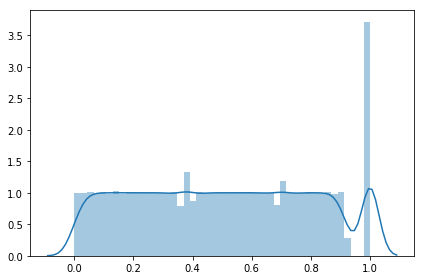

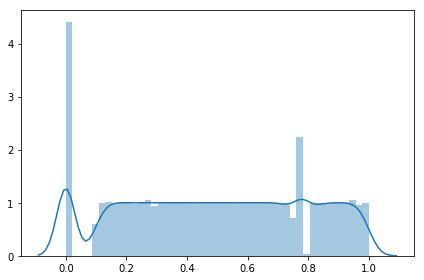

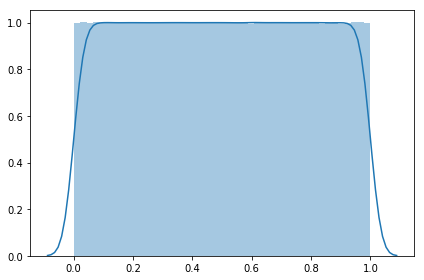

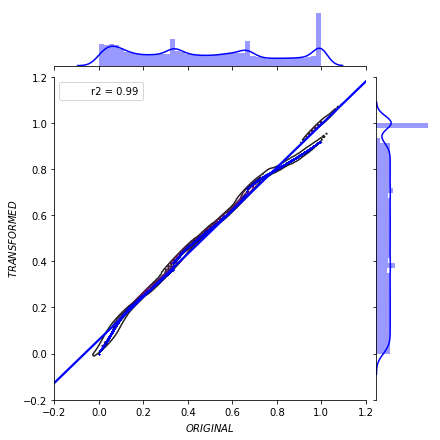

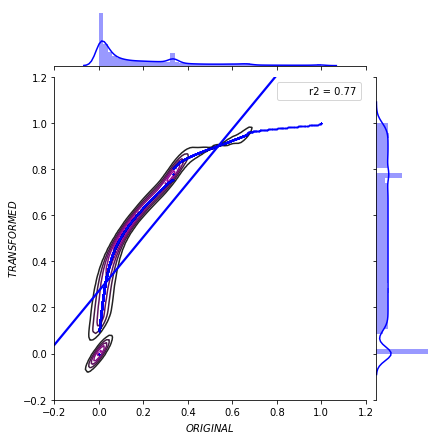

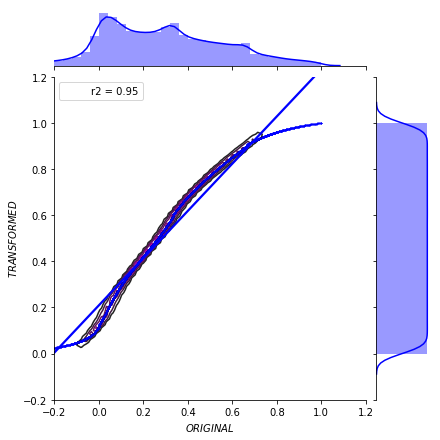

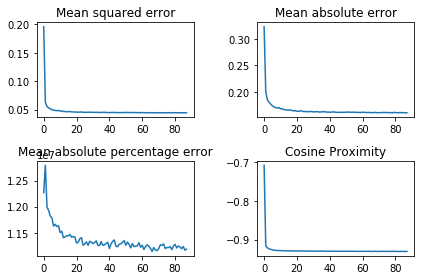

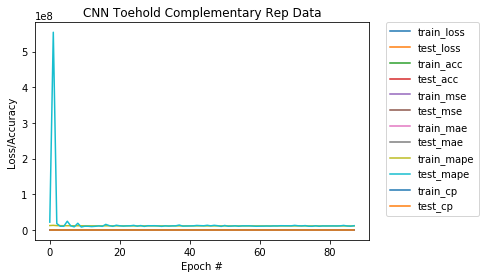

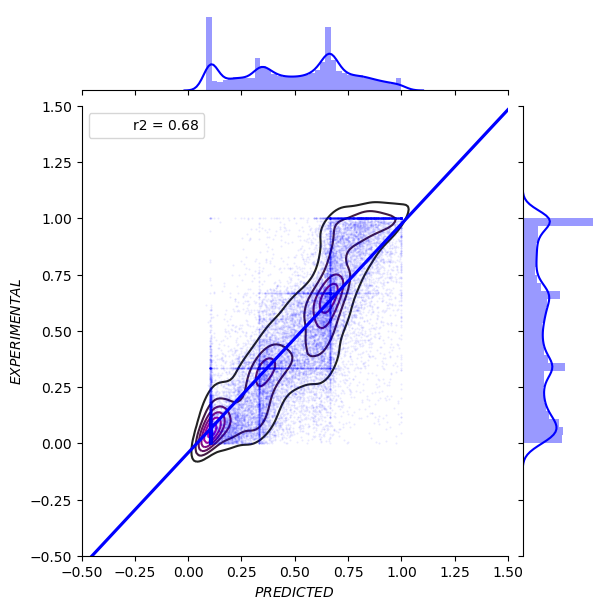

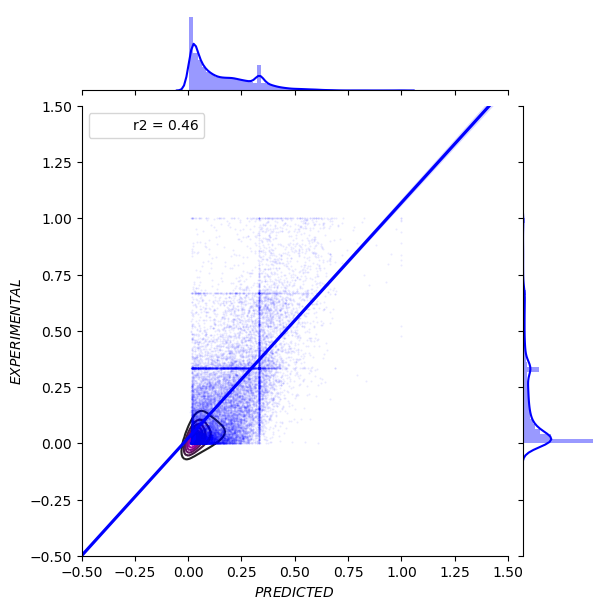

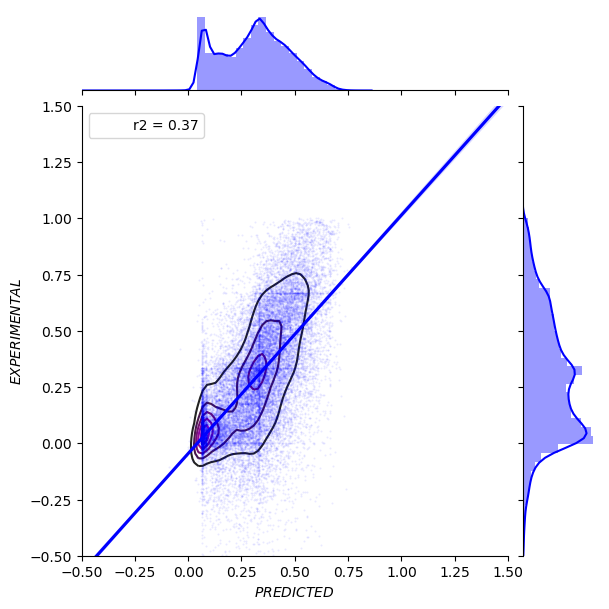

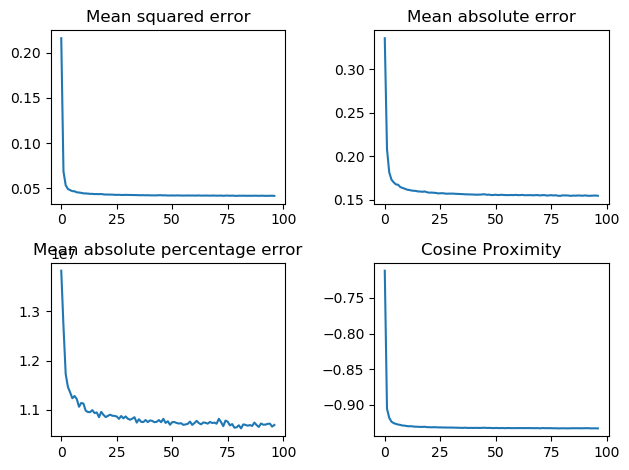

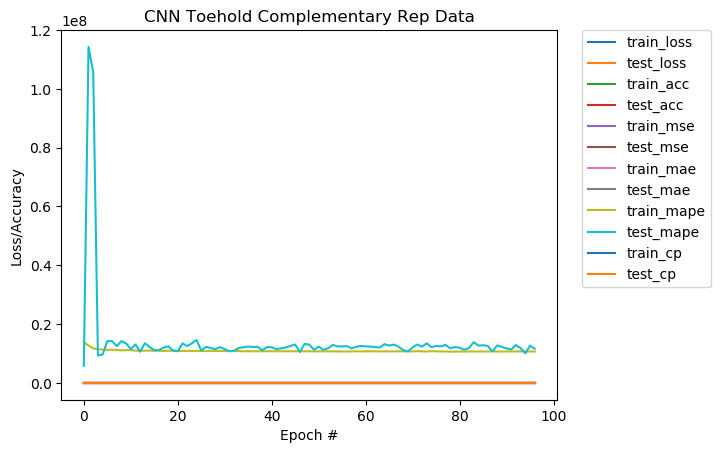

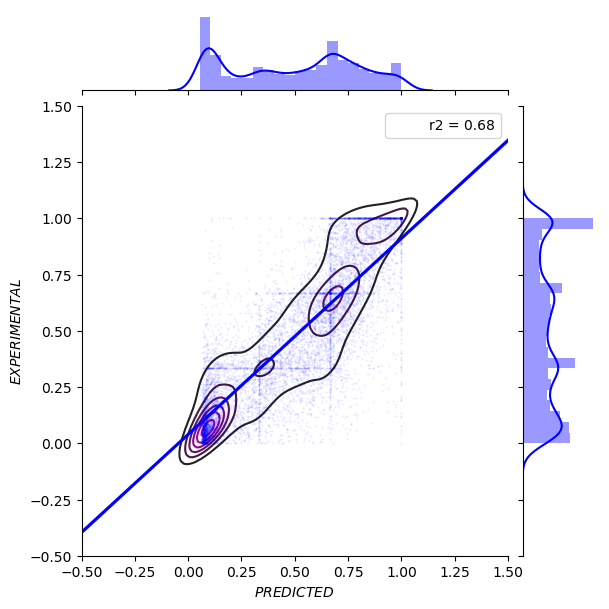

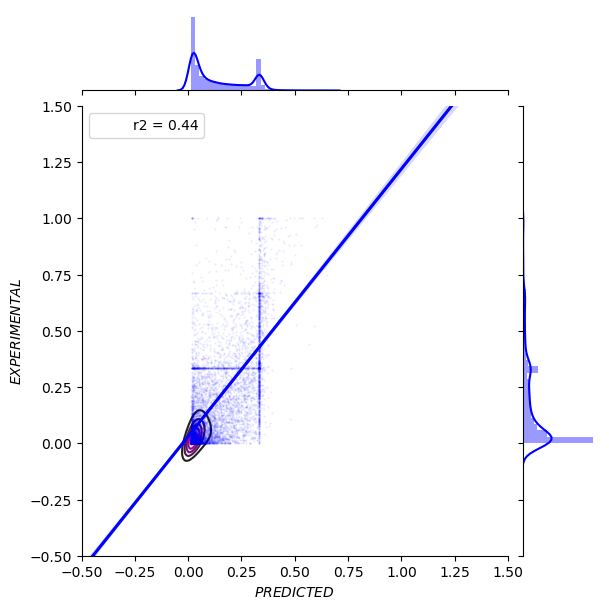

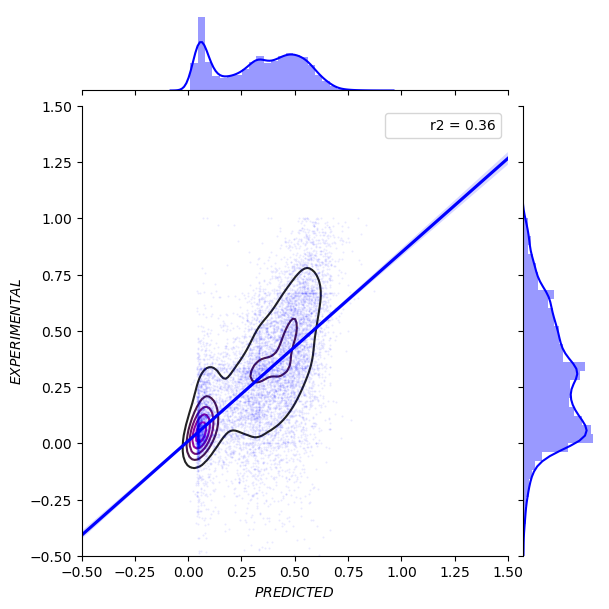

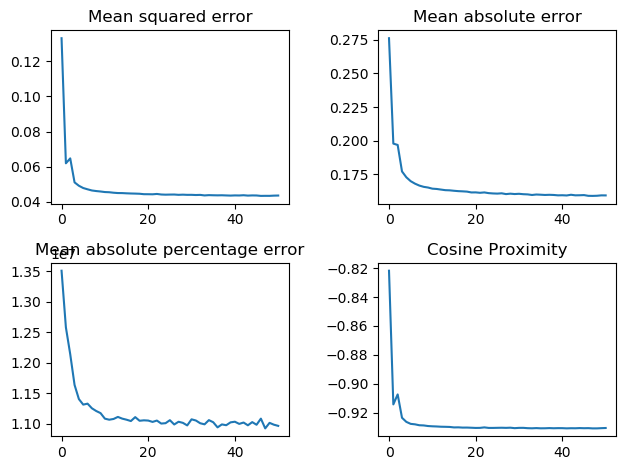

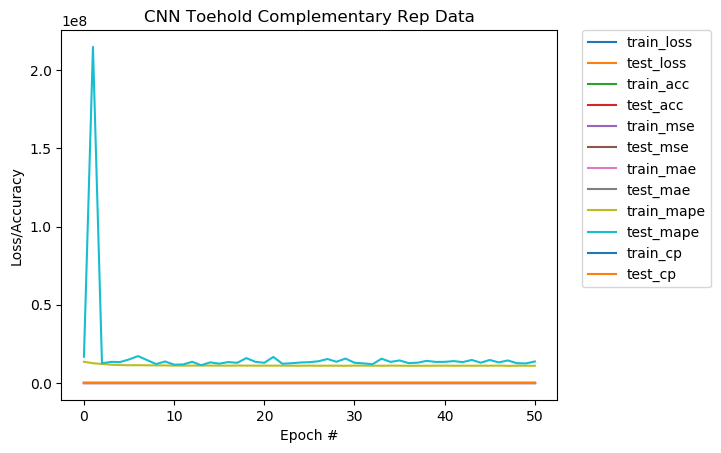

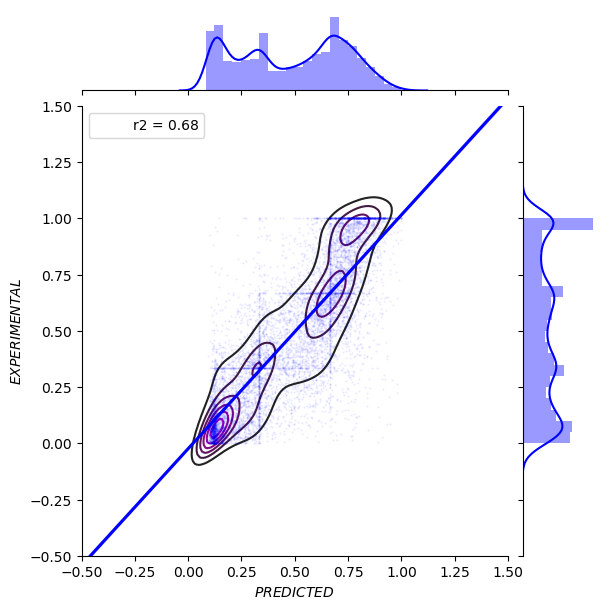

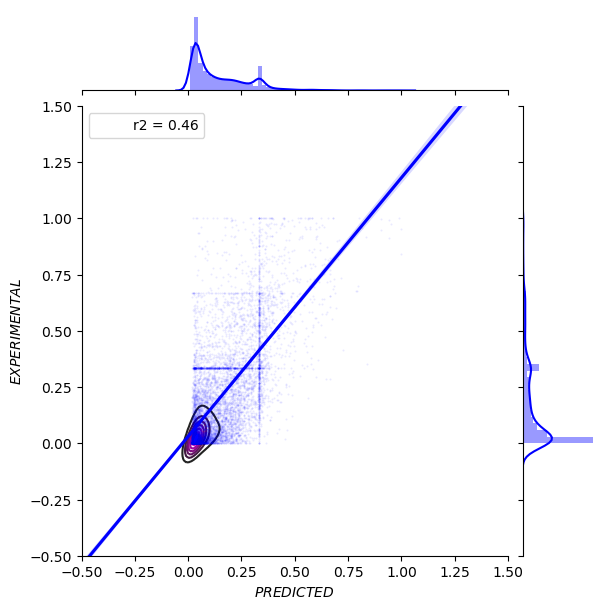

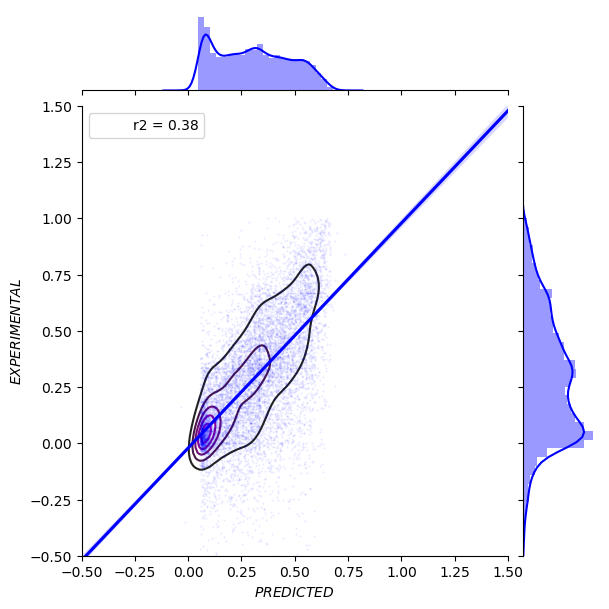

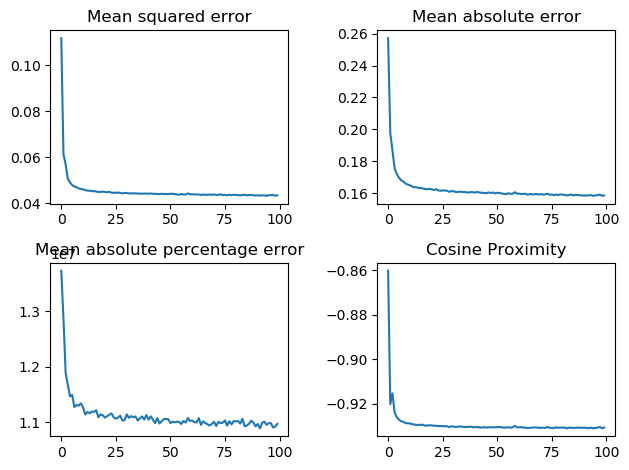

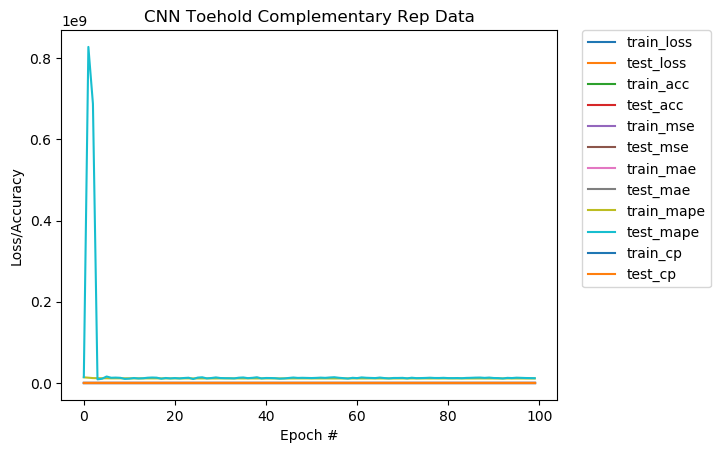

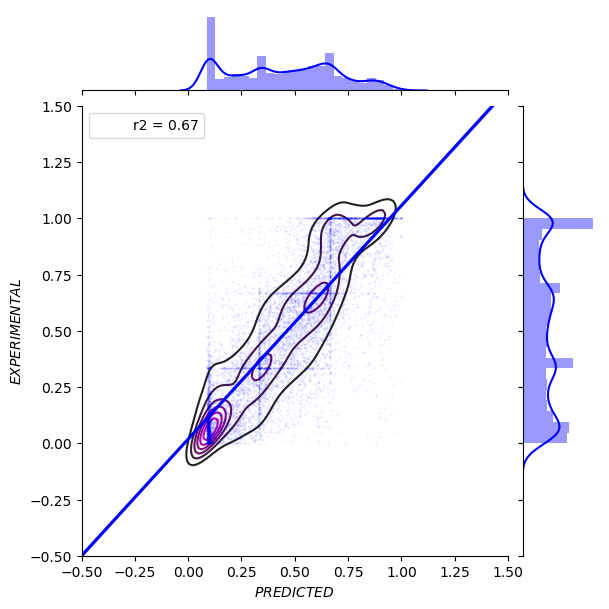

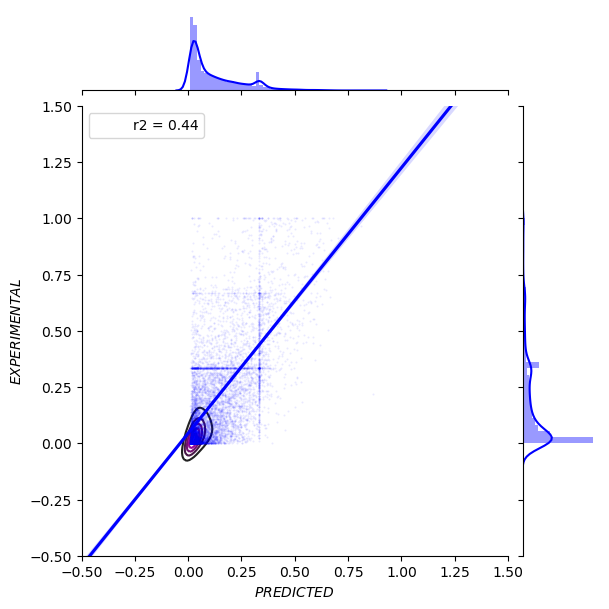

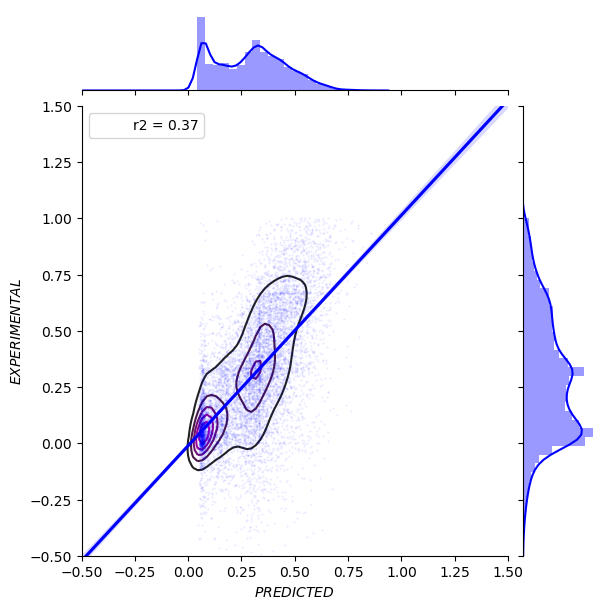

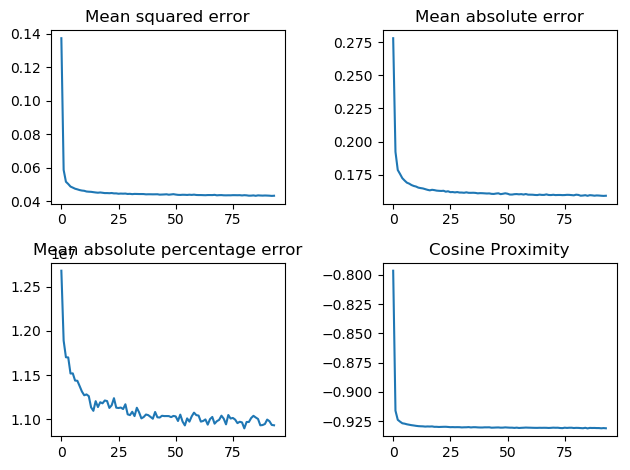

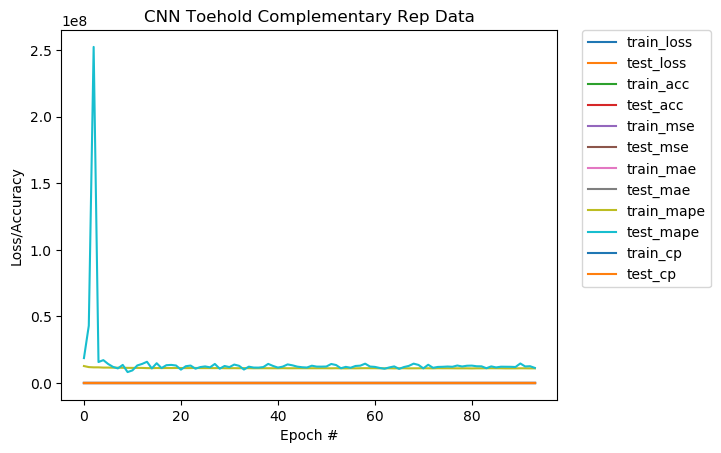

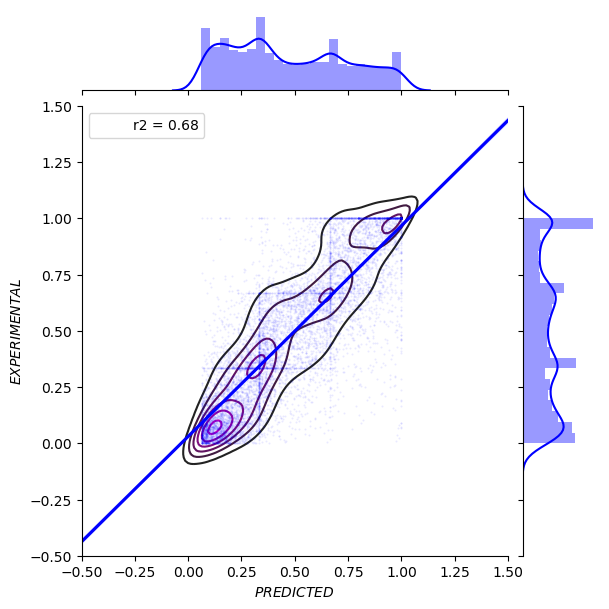

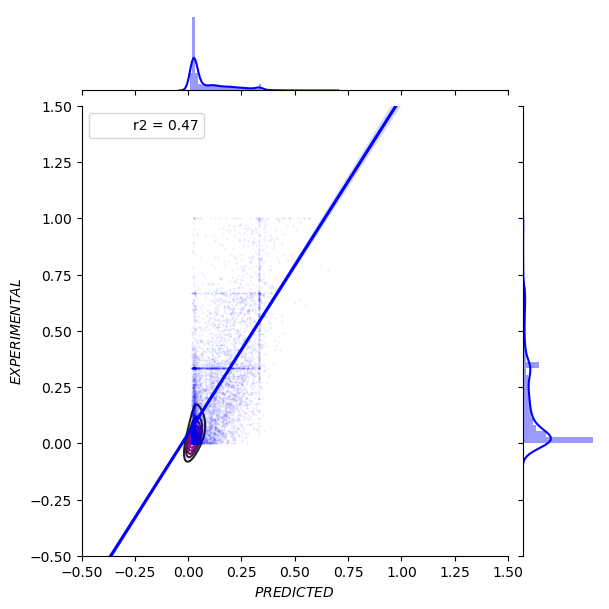

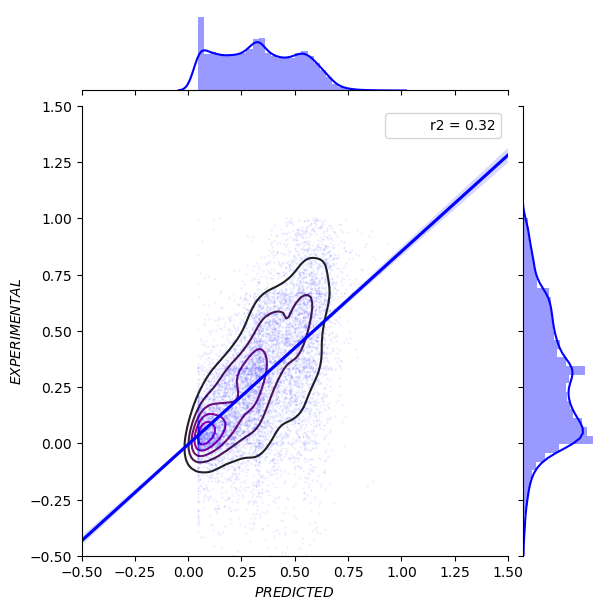

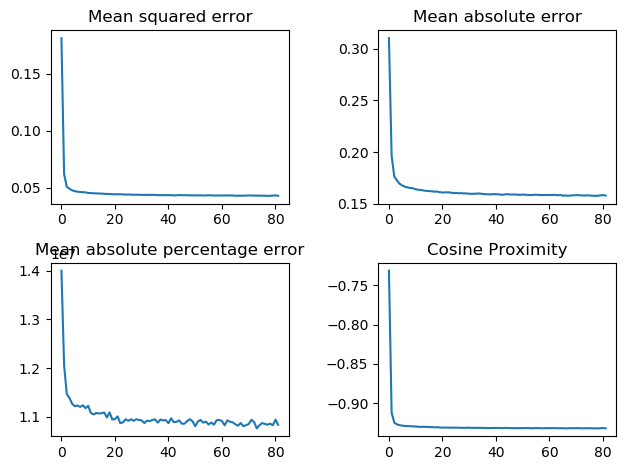

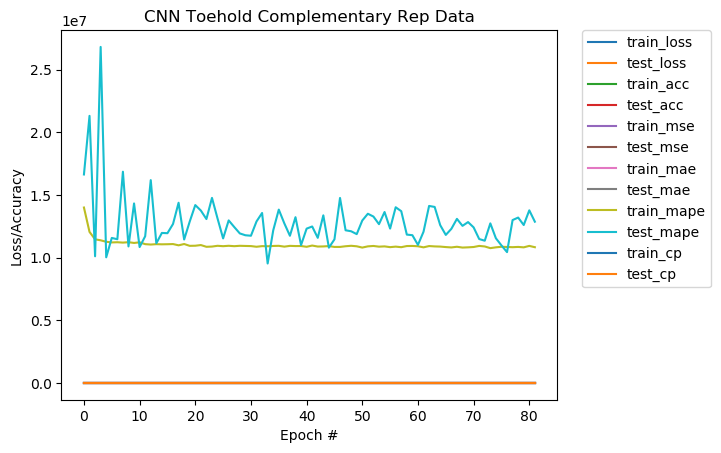

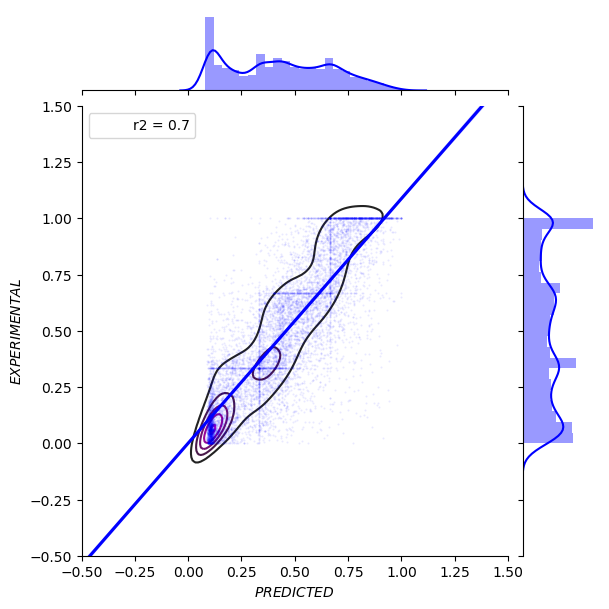

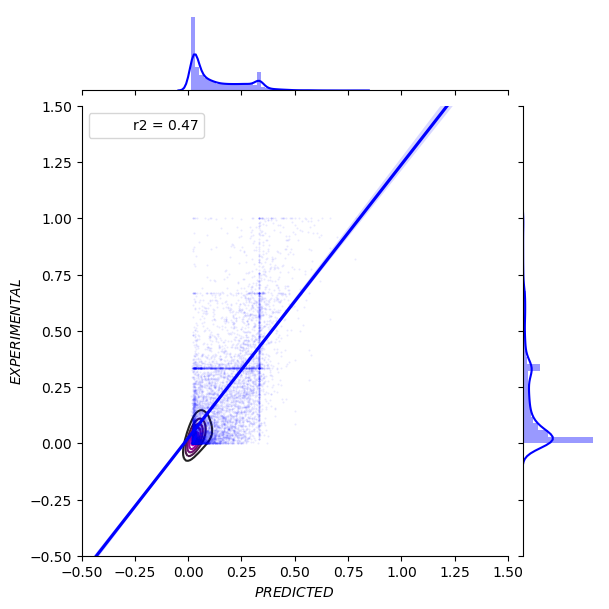

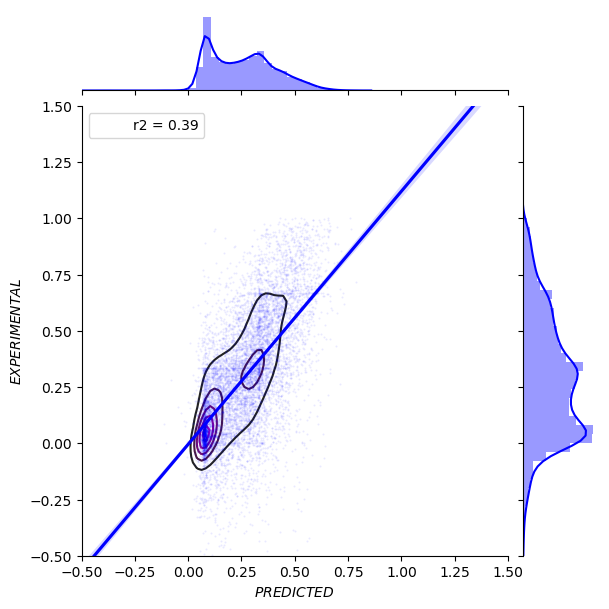

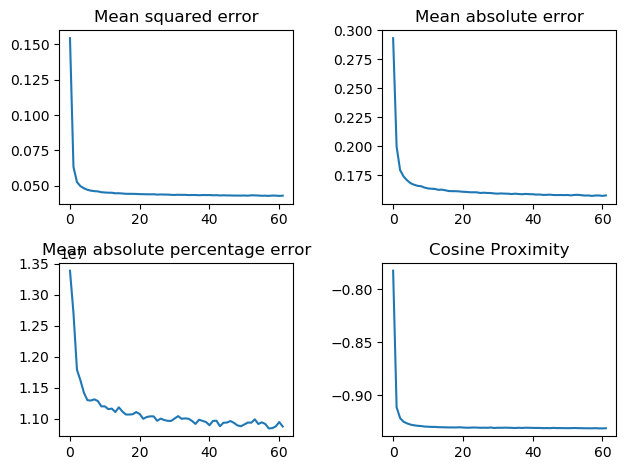

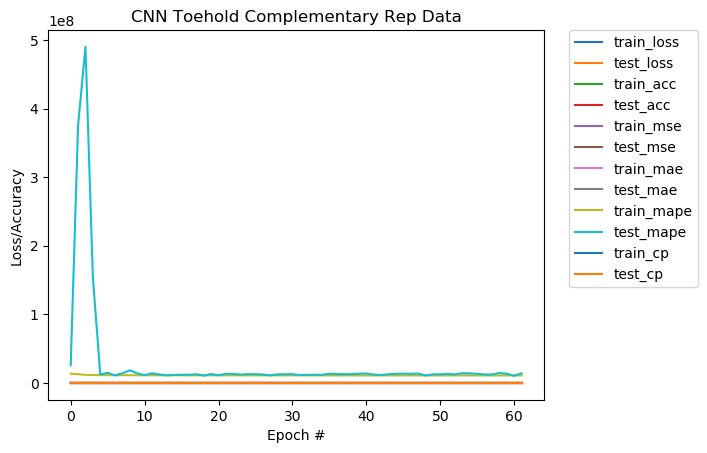

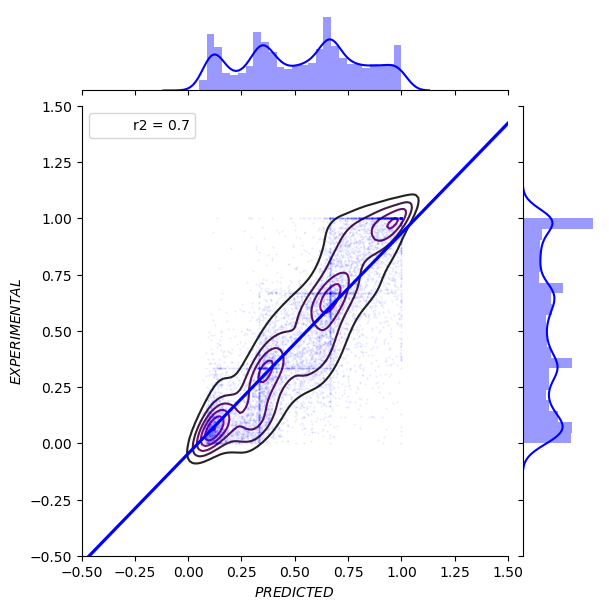

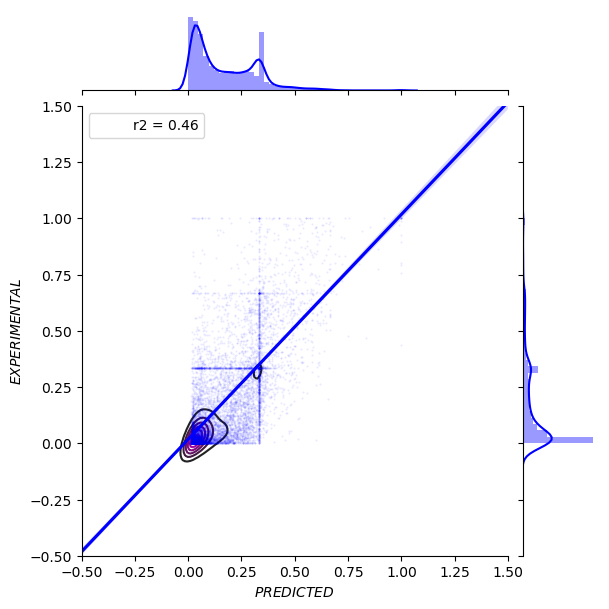

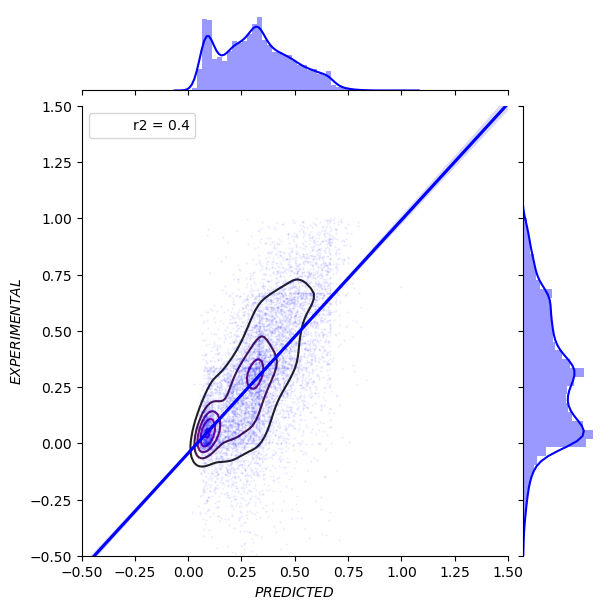

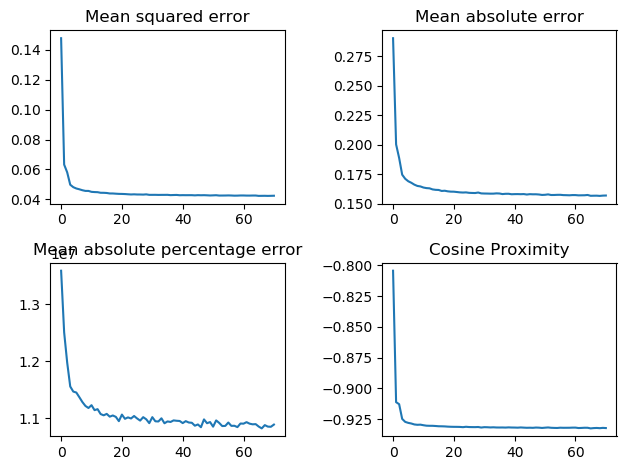

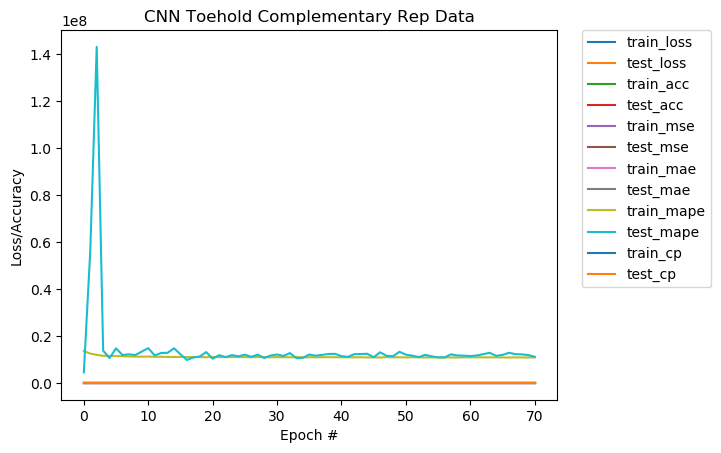

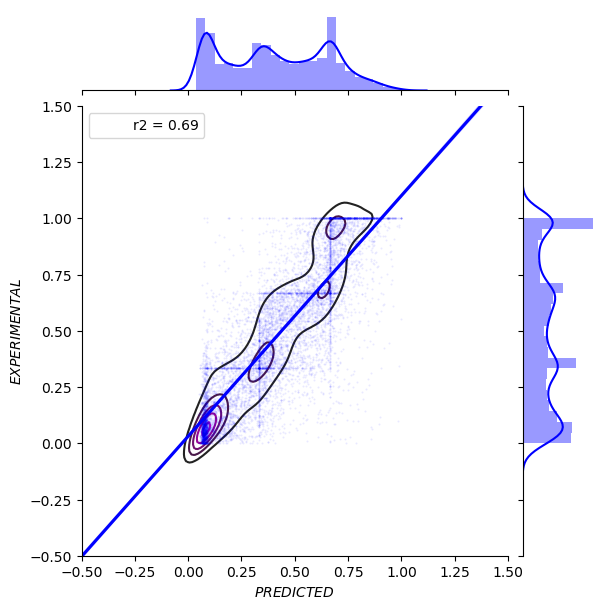

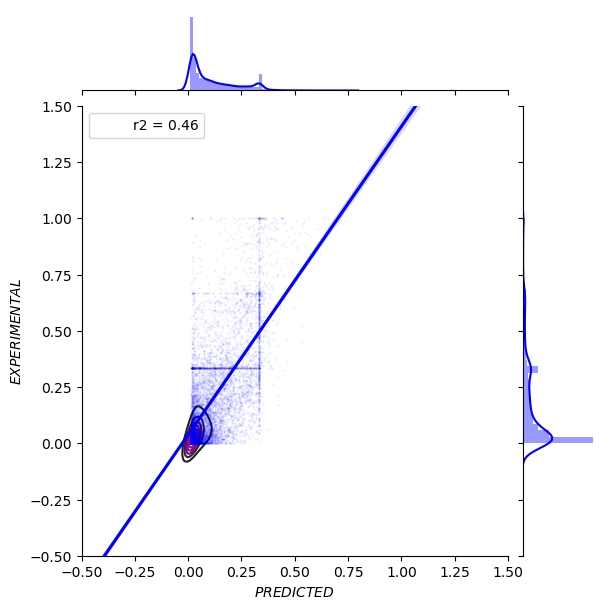

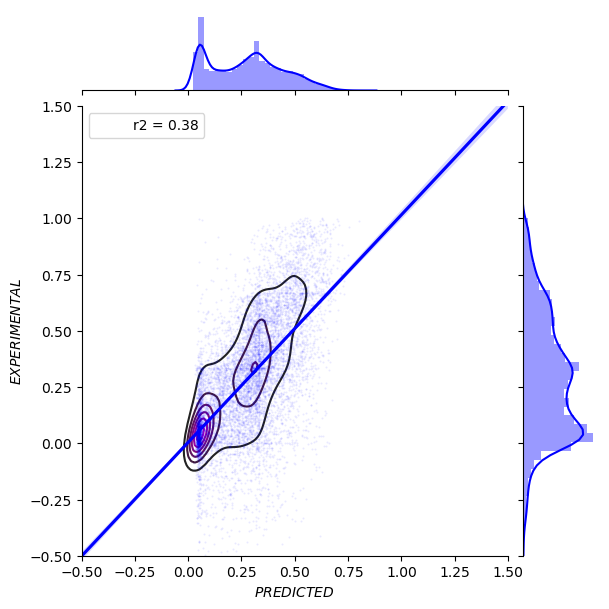

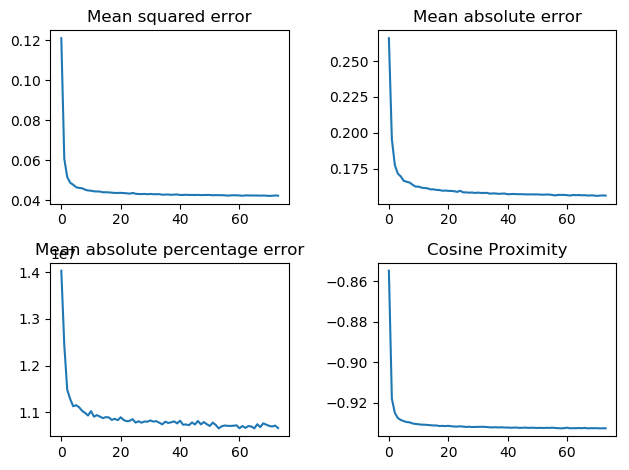

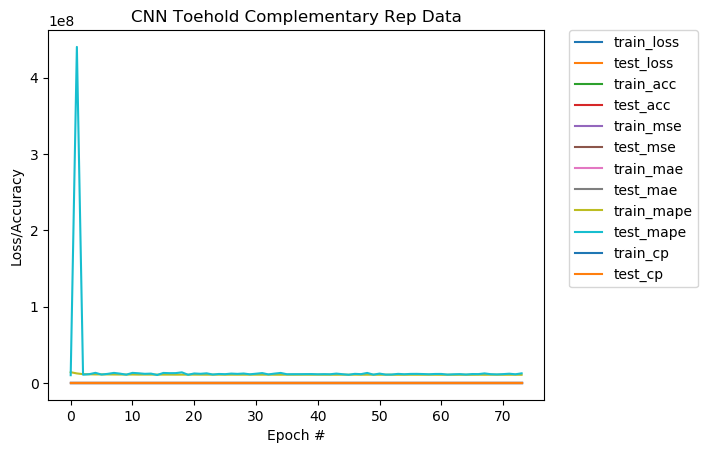

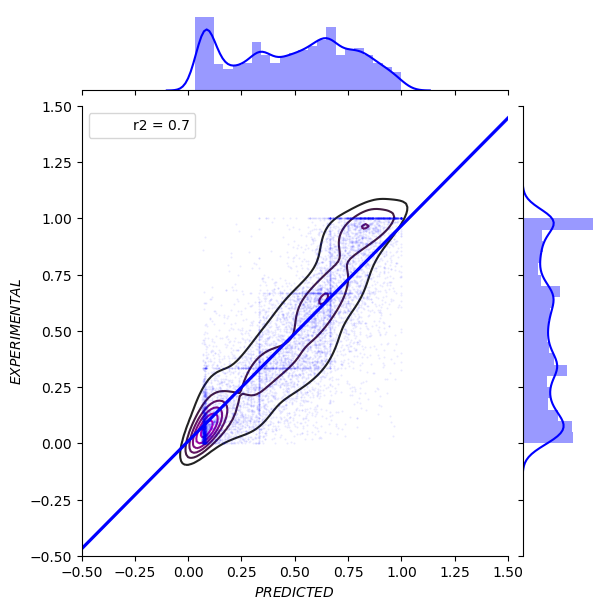

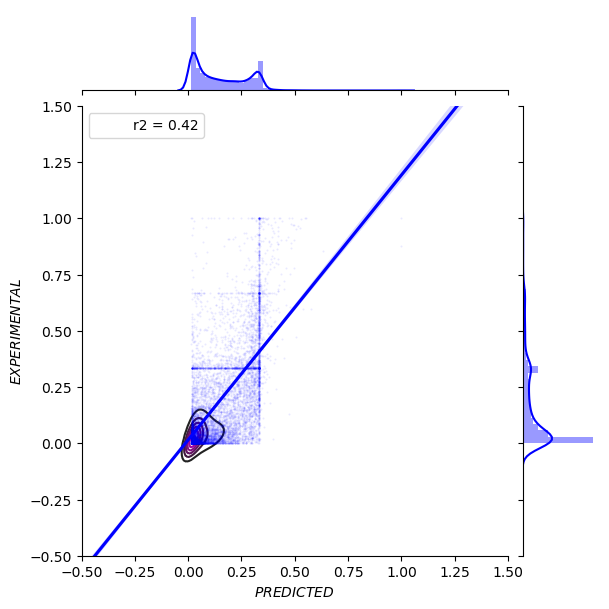

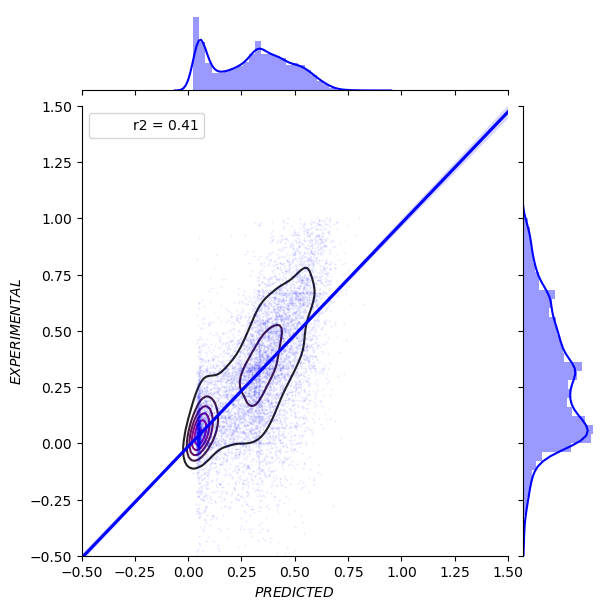

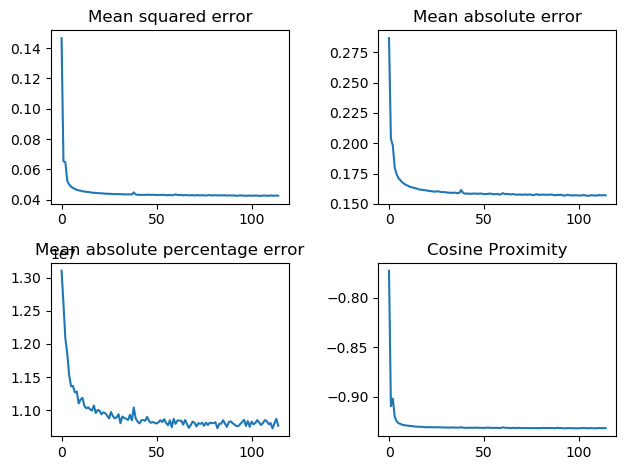

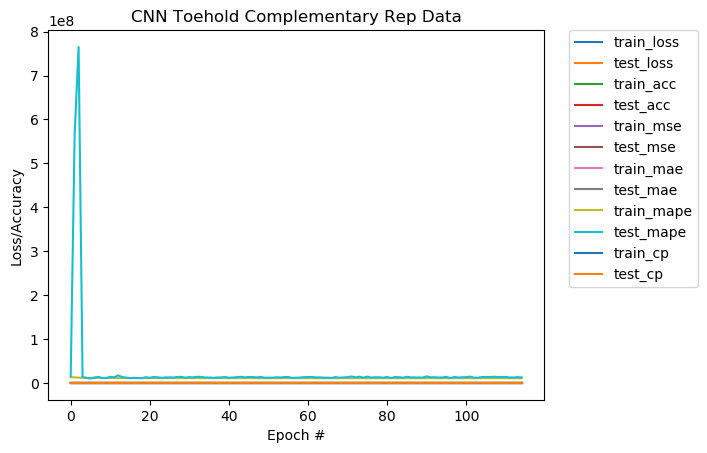

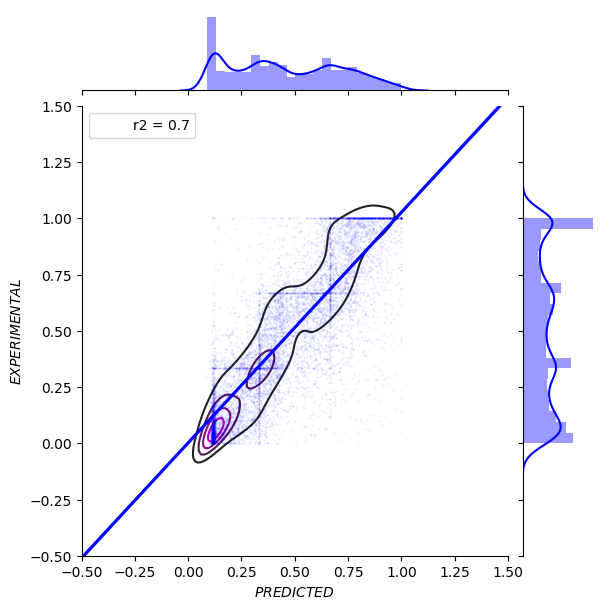

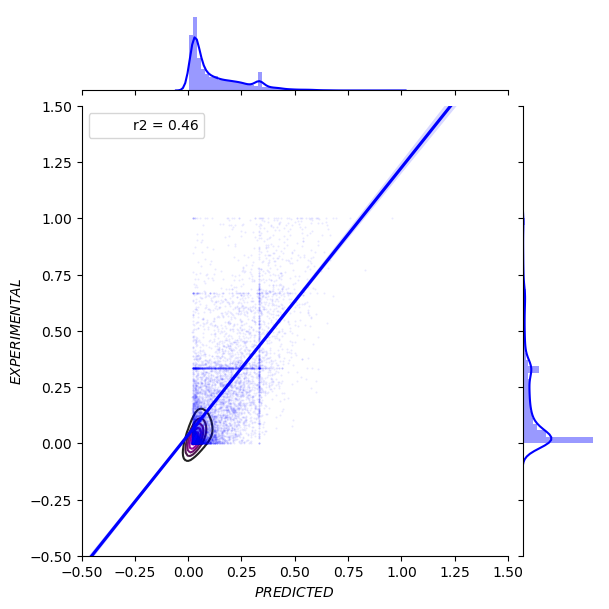

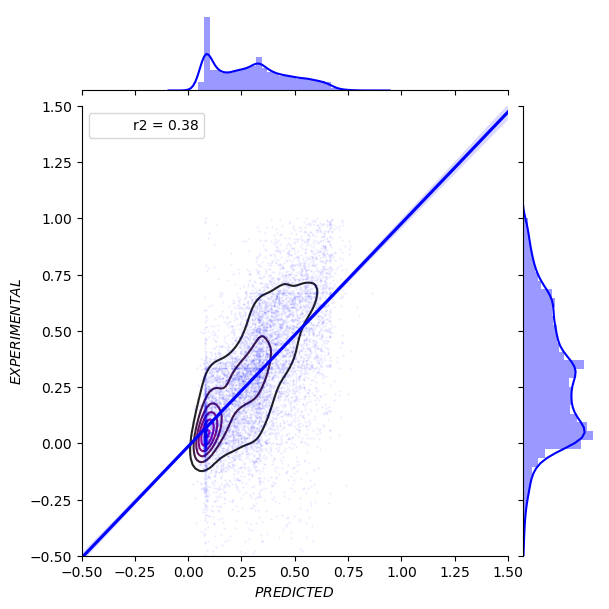

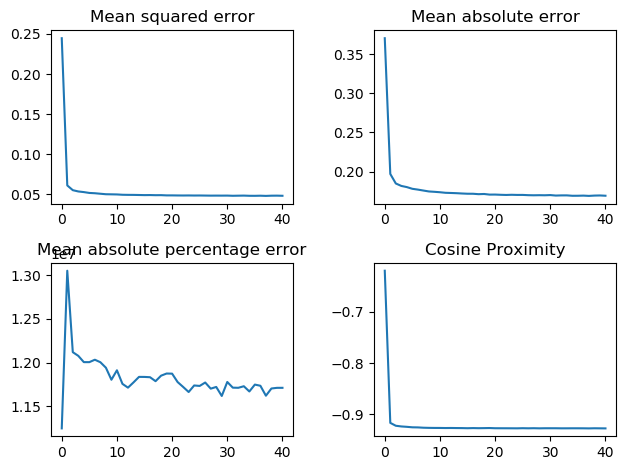

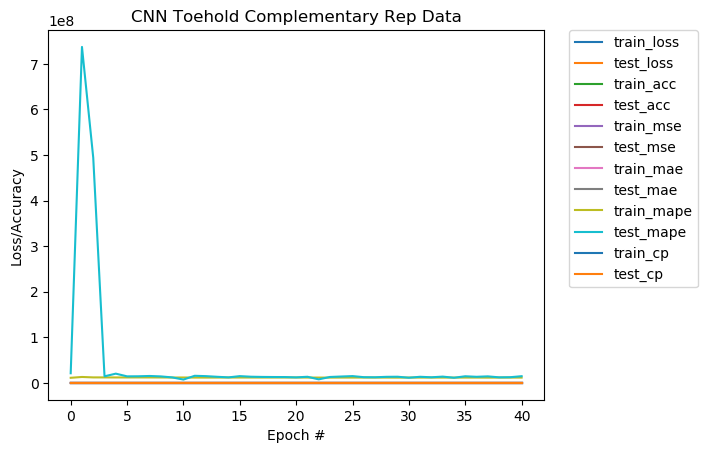

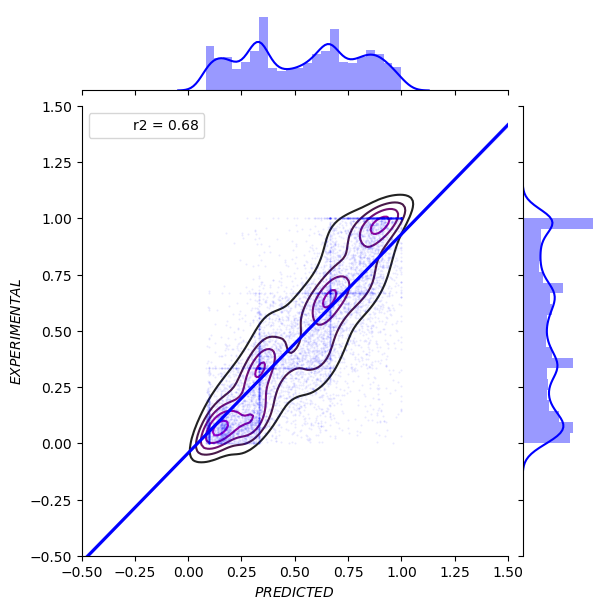

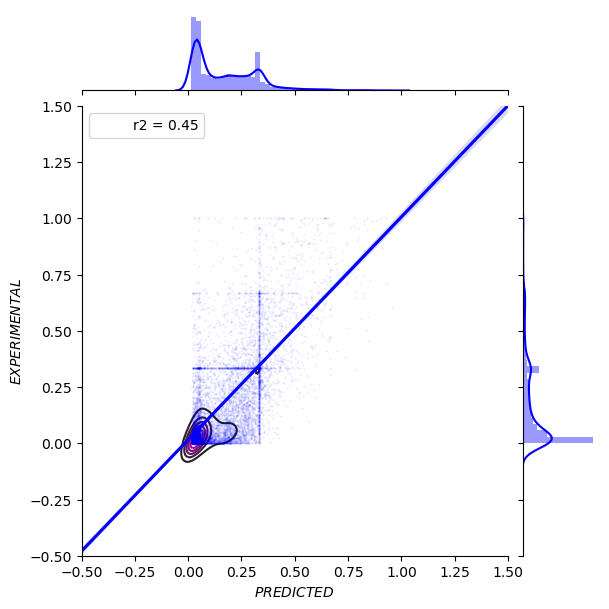

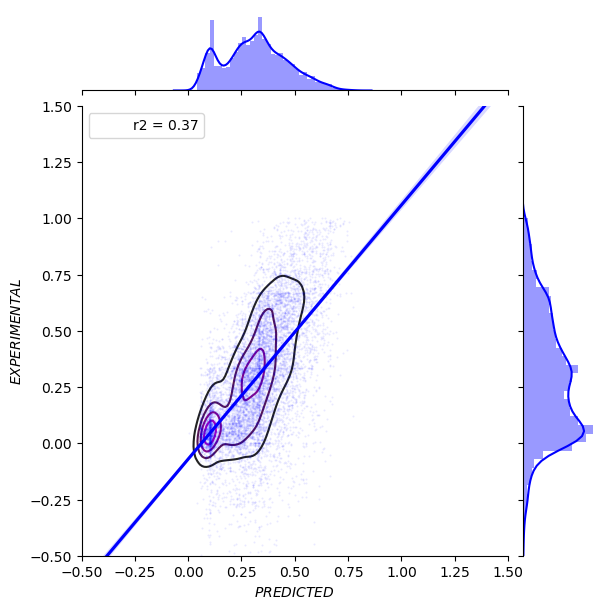

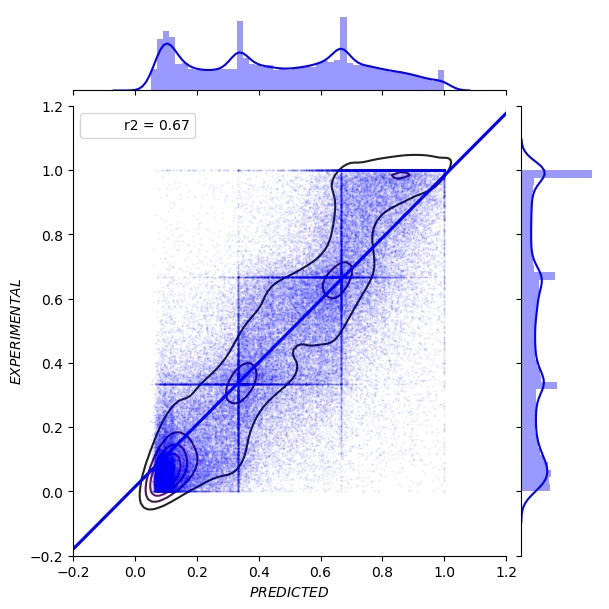

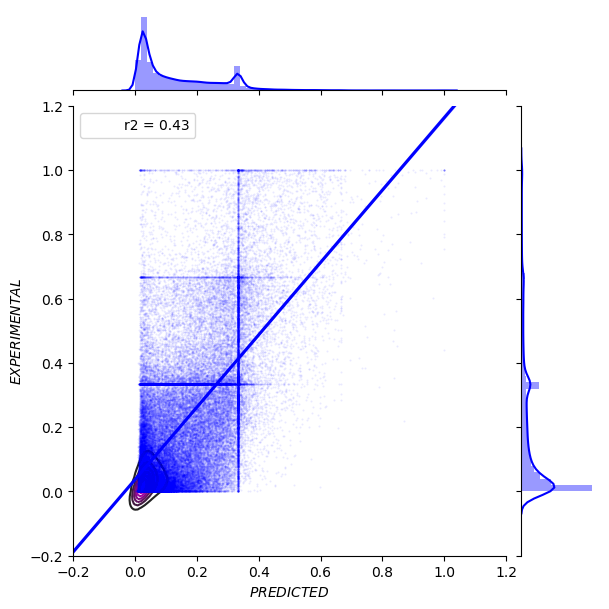

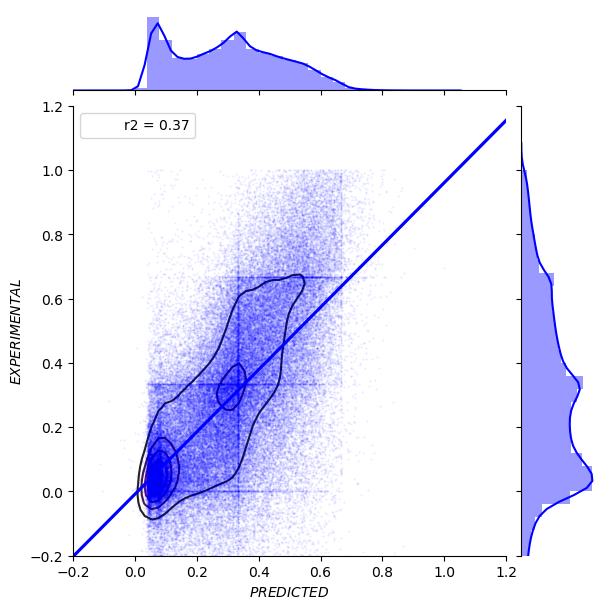

In [13]:
# RUN FULL MODEL ANALYSIS AND REPORTING model
execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate)

-----------------------------------------------------------------------------------------------------------------------------

END OF CODE